# OTP Bank Contest
## Описание задачи

Один из способов повышения эффективности взаимодействия банка с клиентами заключается в том, чтобы отправлять предложение о новой услуге не всем клиентам банка, а только некоторой части, выбираемой по принципу наибольшей склонности к отклику на данное предложение.

Конкурсное задание заключается в том, чтобы предложить алгоритм, который будет выдавать оценку склонности клиента к положительному отклику по его признаковому описанию. Эта оценка может (хотя и не обязана) интерпретироваться как вероятность положительного отклика. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем клиентам, у которых значение оценки выше некоторого порога.

Ссылка на конкурс:
http://poligon.machinelearning.ru/Contests/Card.aspx?synonim=otp

# Быстрое-перемещение

1. [Эксплоративный анализ](#Эксплоративный-анализ)
    1. [Загружаем данные](#Загружаем-данные)
    1. [Дополнительные функции](#Дополнительные-функции)
    1. [Описание полей](#Описание-полей)
    1. [Обрабатываем пропущенные значения](#Обрабатываем-пропущенные-значения)
    1. [Вывод о WORK_TIME](#Вывод-о-WORK_TIME)
    1. [Преобразуем численные значения](#Преобразуем-численные-значения)
    1. [Бининг](#Бининг)
    1. [Добавление фичей](#Добавление-фичей)
    1. [Обработка численных полей](#Обработка-численных-полей)  
      
1. [Data Processing Tool](#Data-Processing-Tool)
    1. [Первая версия](#Первая-версия)
    1. [Вторая версия](#Вторая-версия)
    1. [Построение RF без подгонки параметров](#Построение-RF-без-подгонки-параметров)
1. [Построение моделей](#Построение-моделей)

# Эксплоративный анализ
[Вернуться к быстрому перемещению](#Быстрое-перемещение)

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

from IPython.display import display
plt.rc('font', family='Verdana')

import warnings
warnings.filterwarnings('ignore')

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split

from sklearn.tree import _tree

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [3]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Загружаем данные

In [4]:
data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep = ';')
data.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,0,1,220,18.0000,0,0,1,1,1,6,2,1,1580,1580,nan
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,0,1,137,97.0000,1,0,1,1,1,6,1,1,4020,4020,nan
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,0,1,251,84.0000,0,0,1,2,1,11,0,0,0,0,nan
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,0,36,168.0000,1,1,1,1,1,6,3,1,"1589,923333",1590,nan
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,0,1,83,101.0000,1,0,1,2,1,16,2,1,"1152,15",2230,nan


## Дополнительные функции

In [5]:
def small_categories_aggregation(column, n_samples, value='Укрупненная категория', dataset=data):
    '''
    Укрупняет категории и числовые столбцы в датасете
    :param column: имя стоблца в датасете data
    :param n_samples: порог наблюдений, ниже которого категории объединяются в одну
    :param value: значение, которым будет заполнено
    :param dataset: датасет для изменения
    :return:
    '''

    tmp_small_columns = dataset[column].value_counts()[dataset[column].value_counts() < n_samples].index

    for col in tmp_small_columns:
        dataset.at[dataset[column] == col, column] = value
        
        
def show_columns_with_missing(dataset=data):
    '''
    показать столбцы, где есть пропущенные значения
    :param dataset: датасет
    :return:
    '''
    
    miss_columns = dataset.count(axis=0)[dataset.count(axis=0) < len(dataset)].index

    for i in miss_columns:
        print(dataset.isnull()[i].value_counts())
        print()

    display(miss_columns)
    

def columns(dataset=data):
    
    categorical_columns = [col for col in dataset.columns if dataset[col].dtype.name == 'object']
    numerical_columns = [col for col in dataset.columns if dataset[col].dtype.name != 'object']
    
    return categorical_columns, numerical_columns
    

cat_columns, num_columns = columns()
    
    
def show_binning(dataset=data, categorical_columns=cat_columns):

    columns_to_enlargment = []

    for column in categorical_columns:
        if dataset[column].value_counts().values[-1] < len(dataset)/100:
            columns_to_enlargment.append(column)
            print(dataset[column].value_counts())
            print()
            
    return columns_to_enlargment


# Пишем функцию, которая вычисляет глубину терминальных 
# узлов в отдельном дереве
def leaf_depths(tree, node_id = 0):

    '''
    tree.children_left и tree.children_right записывают идентификационные
    номера левого и правого узлов-потомков для данного узла
    '''

    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    '''
    Если данный узел является терминальным, 
    то оба дочерних узла будут иметь значение _tree.TREE_LEAF,
    что позволяет нам проверить, является ли данный узел терминальным
    '''

    if left_child == _tree.TREE_LEAF:
      
       '''
       Задать глубину терминальных узлов равной 0
       '''
      
       depths = np.array([0])

    else:
     
        '''
        Получить значения глубины узлов-потомков
        и увеличить их на 1
        '''
        
        left_depths = leaf_depths(tree, left_child) + 1
        right_depths = leaf_depths(tree, right_child) + 1
 
        depths = np.append(left_depths, right_depths)
 
    return depths


# Пишем функцию, которая вычисляет минимальное количество наблюдений 
# в терминальных узлах отдельного дерева
def leaf_samples(tree, node_id = 0):
    
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    if left_child == _tree.TREE_LEAF:
        
         samples = np.array([tree.n_node_samples[node_id]])

    else:
        
        left_samples = leaf_samples(tree, left_child)
        right_samples = leaf_samples(tree, right_child)

        samples = np.append(left_samples, right_samples)

    return samples


# Пишем функцию, которая строит гистограмму распределения 
# глубин терминальных узлов и гистограмму распределения 
# количества наблюдений в терминальных узлах по ансамблю
def draw_ensemble(ensemble):

    plt.figure(figsize=(16, 14))
    plt.subplot(211)

    depths_all = np.array([], dtype=int)

    for x in ensemble.estimators_:
        tree = x.tree_
        depths = leaf_depths(tree)
        depths_all = np.append(depths_all, depths)
        plt.hist(depths, histtype='step', color='#ddaaff', 
                 bins=range(min(depths), max(depths)+1))

    plt.hist(depths_all, histtype='step', color='#9933ff', 
             bins=range(min(depths_all), max(depths_all)+1), 
             weights=np.ones(len(depths_all))/len(ensemble.estimators_), 
             linewidth=2)
    plt.xlabel("Глубина терминальных узлов")
   
    samples_all = np.array([], dtype=int)
    
    plt.subplot(212)
    
    for x in ensemble.estimators_:
        tree = x.tree_
        samples = leaf_samples(tree)
        samples_all = np.append(samples_all, samples)
        plt.hist(samples, histtype='step', color='#aaddff', 
                 bins=range(min(samples), max(samples)+1))
    
    plt.hist(samples_all, histtype='step', color='#3399ff', 
             bins=range(min(samples_all), max(samples_all)+1), 
             weights=np.ones(len(samples_all))/len(ensemble.estimators_), 
             linewidth=2)
    plt.xlabel("Количество наблюдений в терминальных узлах")
    
    plt.show()

In [5]:
# указано в условии
data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)

# удаляем id
data.drop('AGREEMENT_RK', axis=1, inplace=True)

## Описание полей

In [6]:
pd.read_excel('data/Credit_OTP_columns_description.xls')

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,TARGET,целевая переменная:отклик на маркетинговую кам...
2,AGE,возраст клиента
3,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...
4,SOCSTATUS_PENS_FL,социальный статус клиента относительно пенсии ...
5,GENDER,"пол клиента (1 - мужчина, 0 - женщина)"
6,CHILD_TOTAL,количество детей клиента
7,DEPENDANTS,количество иждивенцев клиента
8,EDUCATION,образование
9,MARITAL_STATUS,семейное положение


In [7]:
categorical_columns = ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 'EDUCATION', 'MARITAL_STATUS', 
                       'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR',
                       'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE',
                       'REGION_NM', 'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL', 
                       'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
                       'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
                       'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL']

## Обрабатываем пропущенные значения

In [8]:
# уникальные значения
for i in data.columns:
    print(i)
    print(data[i].unique())
    print()

TARGET
[0 1]

AGE
[49 32 52 39 30 29 35 41 53 43 54 26 62 45 38 65 34 28 37 42 33 27 31 40 63
 61 44 59 48 24 23 47 58 51 56 22 36 57 50 46 55 66 25 60 64 21 67]

SOCSTATUS_WORK_FL
[1 0]

SOCSTATUS_PENS_FL
[0 1]

GENDER
[1 0]

CHILD_TOTAL
[ 2  3  4  1  0  5  6  7  8 10]

DEPENDANTS
[1 3 0 2 4 5 6 7]

EDUCATION
['Среднее специальное' 'Среднее' 'Неполное среднее' 'Высшее'
 'Неоконченное высшее' 'Два и более высших образования' 'Ученая степень']

MARITAL_STATUS
['Состою в браке' 'Гражданский брак' 'Разведен(а)' 'Не состоял в браке'
 'Вдовец/Вдова']

GEN_INDUSTRY
['Торговля' 'Информационные технологии' 'Образование'
 'Государственная служба' 'Другие сферы' 'Сельское хозяйство'
 'Здравоохранение' 'Металлургия/Промышленность/Машиностроение' nan
 'Коммунальное хоз-во/Дорожные службы' 'Строительство' 'Транспорт'
 'Банк/Финансы' 'Ресторанный бизнес/Общественное питание' 'Страхование'
 'Нефтегазовая промышленность' 'СМИ/Реклама/PR-агенства' 'Энергетика'
 'Салоны красоты и здоровья' 'ЧОП/Детектив

In [9]:
# одно уникальное значение, удаляем
data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

In [10]:
show_columns_with_missing()

False    13856
True      1367
Name: GEN_INDUSTRY, dtype: int64

False    13856
True      1367
Name: GEN_TITLE, dtype: int64

False    13856
True      1367
Name: ORG_TP_STATE, dtype: int64

False    13858
True      1365
Name: ORG_TP_FCAPITAL, dtype: int64

False    13856
True      1367
Name: JOB_DIR, dtype: int64

False    14928
True       295
Name: TP_PROVINCE, dtype: int64

False    15222
True         1
Name: REGION_NM, dtype: int64

False    13855
True      1368
Name: WORK_TIME, dtype: int64



Index(['GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL',
       'JOB_DIR', 'TP_PROVINCE', 'REGION_NM', 'WORK_TIME'],
      dtype='object')

In [11]:
# переводим в категориальные значения
for i in categorical_columns:
    if i in data.columns:
        data[i]=data[i].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 50 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null object
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDRE

In [12]:
show_columns_with_missing()

False    13855
True      1368
Name: WORK_TIME, dtype: int64



Index(['WORK_TIME'], dtype='object')

In [13]:
# если человек нигде не работает, то WORK_TIME = 0
data.at[(data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0

In [14]:
show_columns_with_missing()

False    15222
True         1
Name: WORK_TIME, dtype: int64



Index(['WORK_TIME'], dtype='object')

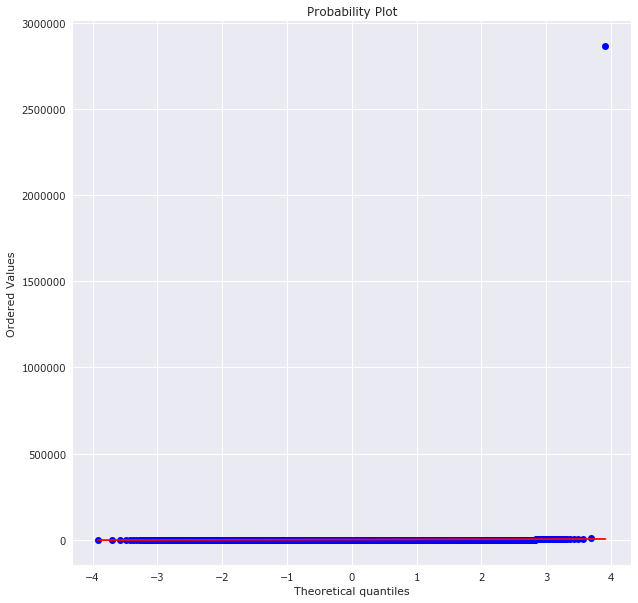

In [15]:
## QQ Plot для всех значений WORK_TIME
plt.subplots(figsize=(10, 10))

stats.probplot(data['WORK_TIME'].dropna().sort_values(), dist="norm", plot=plt)
plt.show()

In [16]:
# эспериментально выбранное значение
heu_const_work_time = 15200

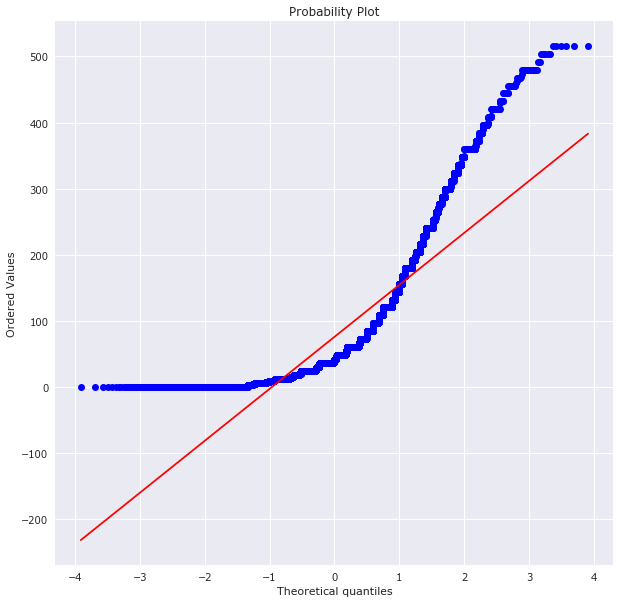

In [17]:
plt.subplots(figsize=(10, 10))

stats.probplot((data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time]), dist="norm", plot=plt)
plt.show()

### Распределения

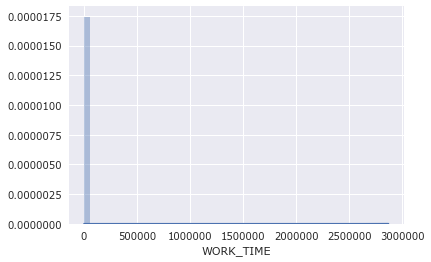

In [18]:
sns.distplot(data['WORK_TIME'].dropna().sort_values().dropna())

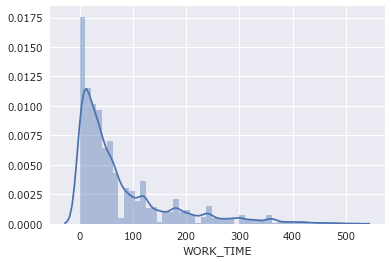

In [19]:
sns.distplot(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].dropna())

In [20]:
# максимальное значение, после которого значения считаются "неправильными"
maxy_work_time = max(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time])
maxy_work_time

516.0

In [21]:
# считаем значения больше maxy_work_time - пропущенными
data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN

# стало не слишком больше пропущенных значений
len(data['WORK_TIME']) - len(data['WORK_TIME'].dropna())

22

In [22]:
# значение медианы, не учитывающее замену некоторых пропущенных значений неработающих людей на 0
data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()

48.0

In [23]:
# аналогичное среднее
data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].mean()

83.04951568599104

median


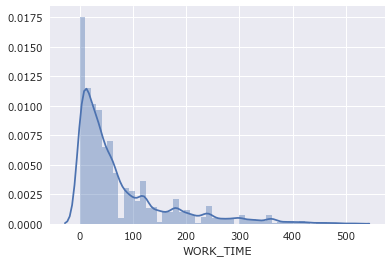

In [24]:
print('median')
sns.distplot(data['WORK_TIME'].fillna(data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()))

In [25]:
true_median = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
data['WORK_TIME'].fillna(true_median, inplace=True)

## Вывод о WORK_TIME
Для неработающих людей WORK_TIME заменили на ноль, было выявлено, что есть "неправильные" значения, то есть нельзя отработать 300 000 месяцев. Порог этих значений я определил по qq plot и выявил значение, больше которого значения считать правдивыми нельзя. Затем я заменил эти значения на пропуски и импутировал пропуски медианным значением WORK_TIME без учета 0 (неработающих) людей

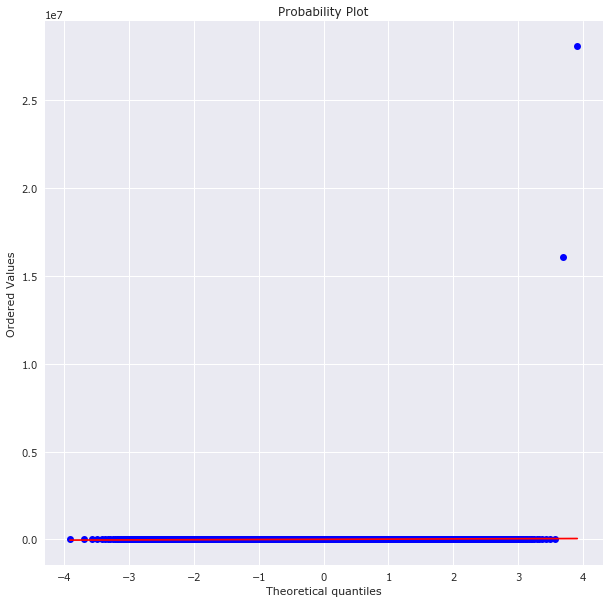

In [26]:
## QQ Plot
plt.subplots(figsize=(10, 10))

stats.probplot(data['FACT_LIVING_TERM'].dropna().sort_values(), dist="norm", plot=plt)
plt.show()

### Ситуация аналогична WORK_TIME

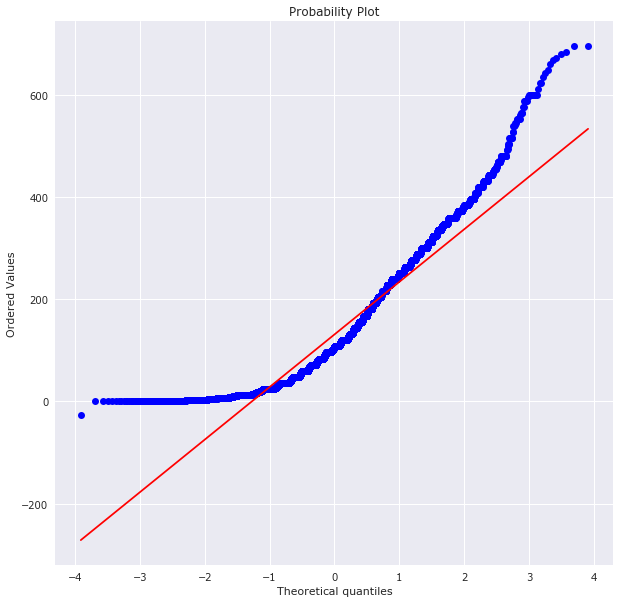

In [27]:
## QQ Plot
plt.subplots(figsize=(10, 10))

stats.probplot(data['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time], dist="norm", plot=plt)
plt.show()

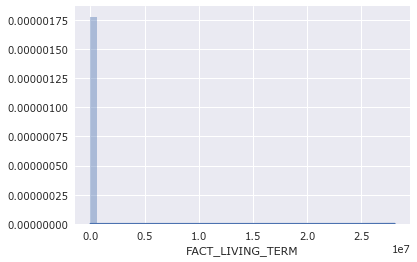

In [28]:
sns.distplot(data['FACT_LIVING_TERM'].dropna().sort_values())

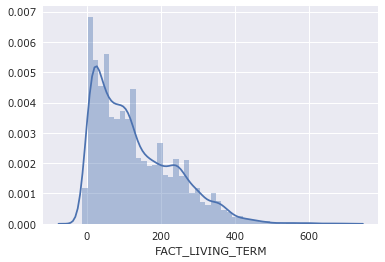

In [29]:
sns.distplot(data['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time])

In [30]:
data[data['FACT_LIVING_TERM'] < 0]

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
6246,0,56,1,0,1,0,0,Высшее,Состою в браке,Строительство,Высококвалифиц. специалист,Частная компания,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,23000,Приморский край,Приморский край,Приморский край,Приморский край,ДАЛЬНЕВОСТОЧНЫЙ,1,1,1,1,1,1,0,0,0,1,0,0,98136,24,40664,1,-26,288.0000,1,0,1,1,0,4,0,0,0,0,0.0000


In [31]:
data.at[data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0

In [32]:
maxy_live_term = max(data['FACT_LIVING_TERM'].sort_values()[:heu_const_work_time])

In [33]:
# считаем значения больше maxy_work_time - пропущенными
data.at[data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN

# стало не слишком больше пропущенных значений
len(data['FACT_LIVING_TERM']) - len(data['FACT_LIVING_TERM'].dropna())

23

median


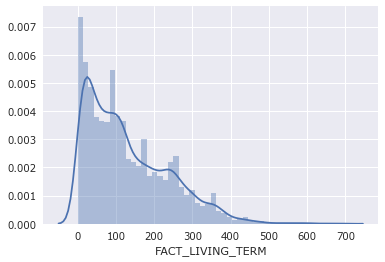

In [34]:
print('median')
sns.distplot(data['FACT_LIVING_TERM'].fillna(data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()))

In [35]:
true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)

## Преобразуем численные значения

In [36]:
for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
    if i in data.columns:
        data[i] = data[i].str.replace(',', '.').astype('float')

In [37]:
cat_columns, num_columns = columns()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 50 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDR

In [38]:
data[cat_columns].describe()

,TARGET,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,GPF_DOCUMENT_FL,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL
count,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223
unique,2,2,2,2,7,5,32,13,6,3,11,5,81,81,80,71,12,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,0,1,0,1,Среднее специальное,Состою в браке,Торговля,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,Кемеровская область,Кемеровская область,Кемеровская область,Краснодарский край,ЮЖНЫЙ,1,1,1,1,1,0,0,0,0,0,0,1,1,0,1
freq,13411,13847,13176,9964,6518,9416,2385,7010,6523,13688,11452,7077,674,674,674,790,2179,12765,14480,13493,12758,13782,10507,14097,11940,15074,14930,14558,8961,9311,14389,13855


In [39]:
data[num_columns].describe()

,AGE,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,OWN_AUTO,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
count,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000
mean,40.4061,1.0994,0.6452,13853.8363,0.1163,14667.9593,8.1010,3398.5627,131.0020,75.5412,1.3878,0.7519,7.8760,0.1954,0.1302,239.4571,243.0216,0.0191
std,11.6011,0.9954,0.8123,9015.4676,0.3208,12147.8735,4.0941,5158.1089,107.6183,89.5994,0.7936,0.9885,7.9557,0.6850,0.3557,827.7004,836.1001,0.1377
min,21.0000,0.0000,0.0000,24.0000,0.0000,2000.0000,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,30.0000,0.0000,0.0000,8000.0000,0.0000,6500.0000,6.0000,1000.0000,41.0000,14.0000,1.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,39.0000,1.0000,0.0000,12000.0000,0.0000,11550.0000,6.0000,2000.0000,107.0000,40.0000,1.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,50.0000,2.0000,1.0000,17000.0000,0.0000,19170.0000,10.0000,4000.0000,204.0000,96.0000,2.0000,1.0000,8.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,67.0000,10.0000,7.0000,250000.0000,2.0000,119700.0000,36.0000,140000.0000,696.0000,516.0000,11.0000,11.0000,114.0000,13.0000,8.0000,28012.2000,28012.2000,2.0000


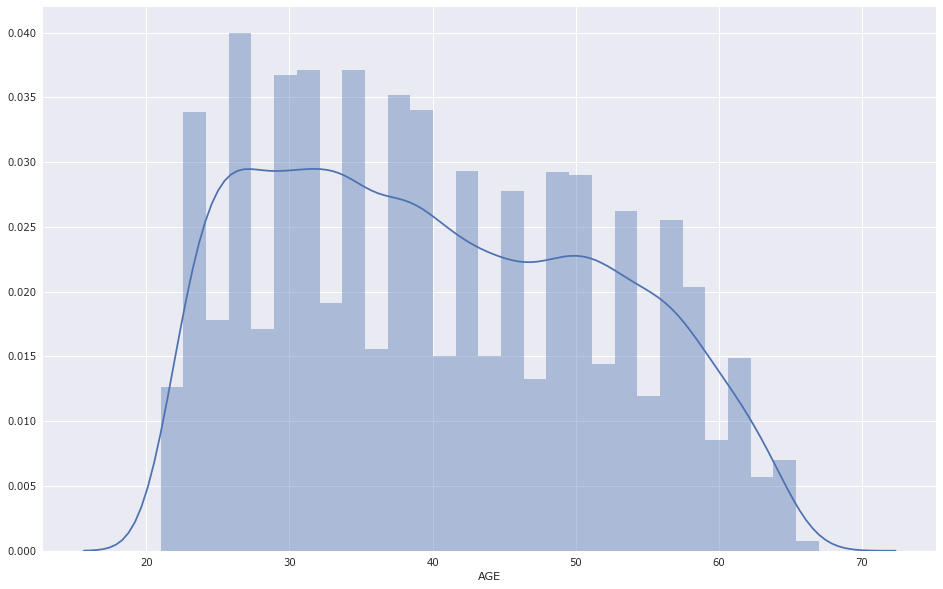

In [40]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[0]])

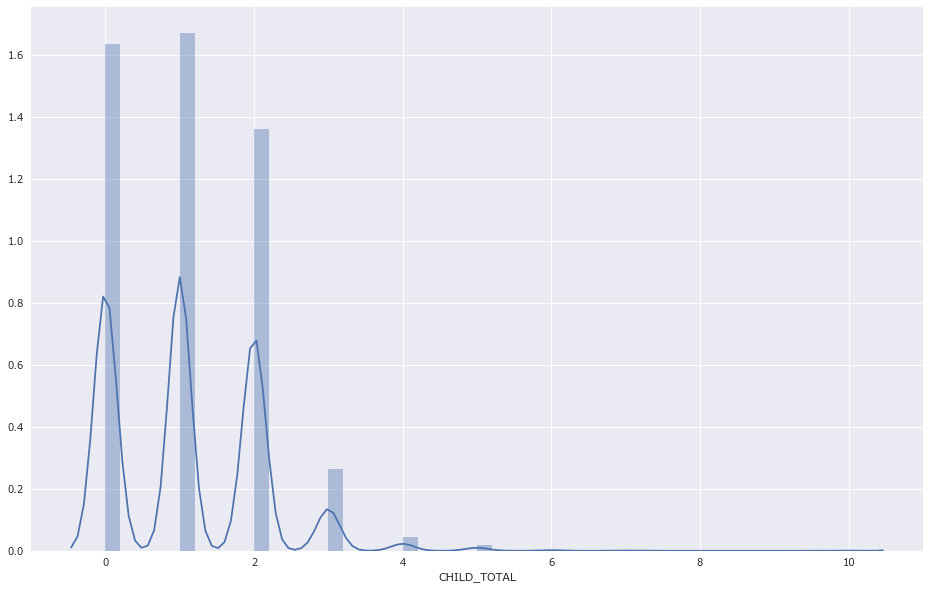

In [41]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[1]])

### Явно видно, что CHILD_TOTAL скорее категориальная переменная

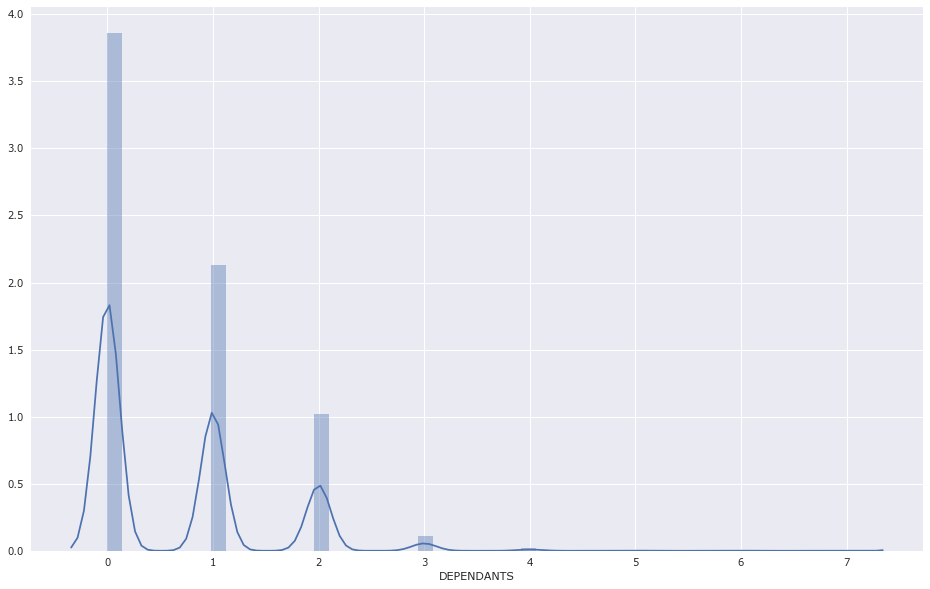

In [42]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[2]])

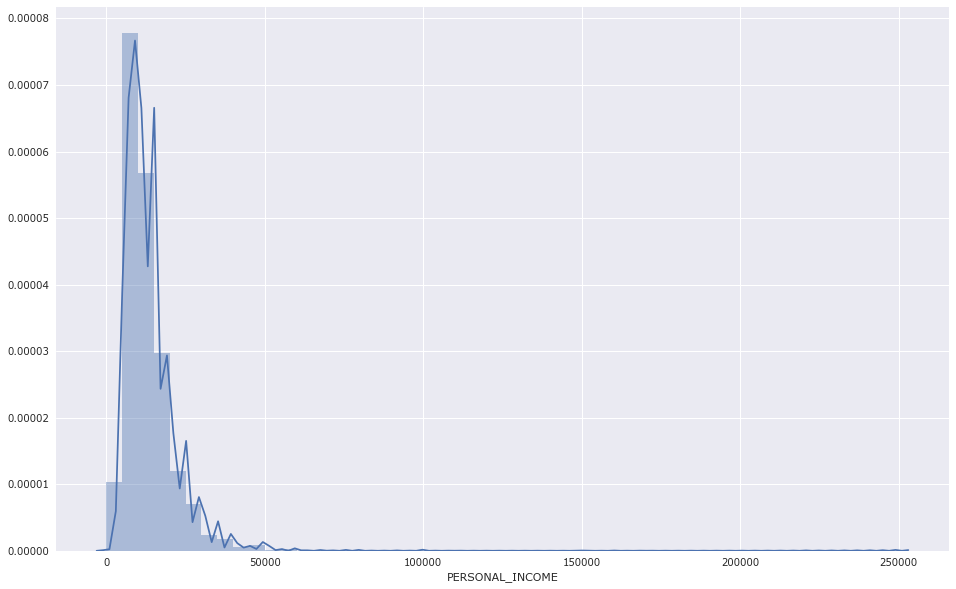

In [43]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[3]])

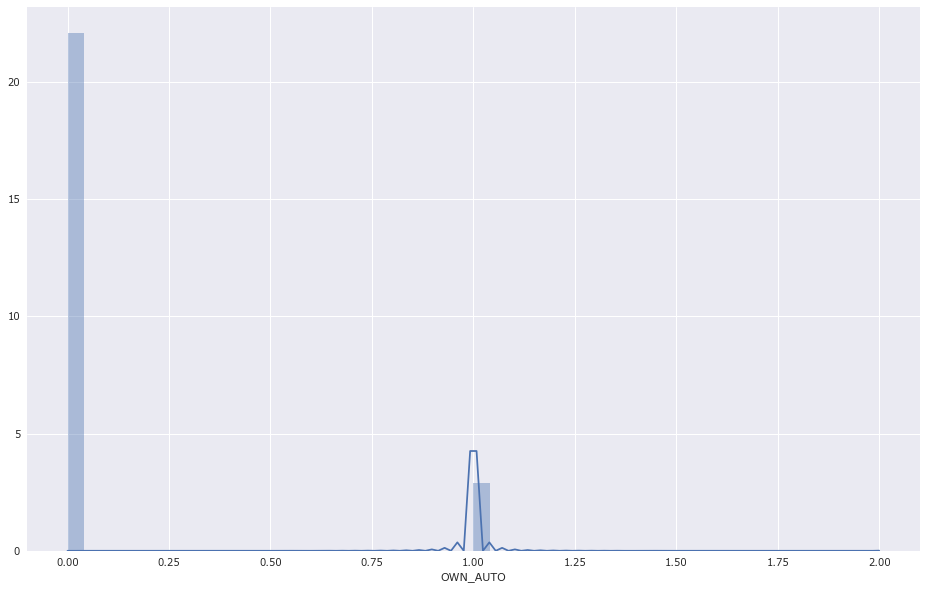

In [44]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[4]])

In [45]:
data['OWN_AUTO'].value_counts()

0    13453
1     1769
2        1
Name: OWN_AUTO, dtype: int64

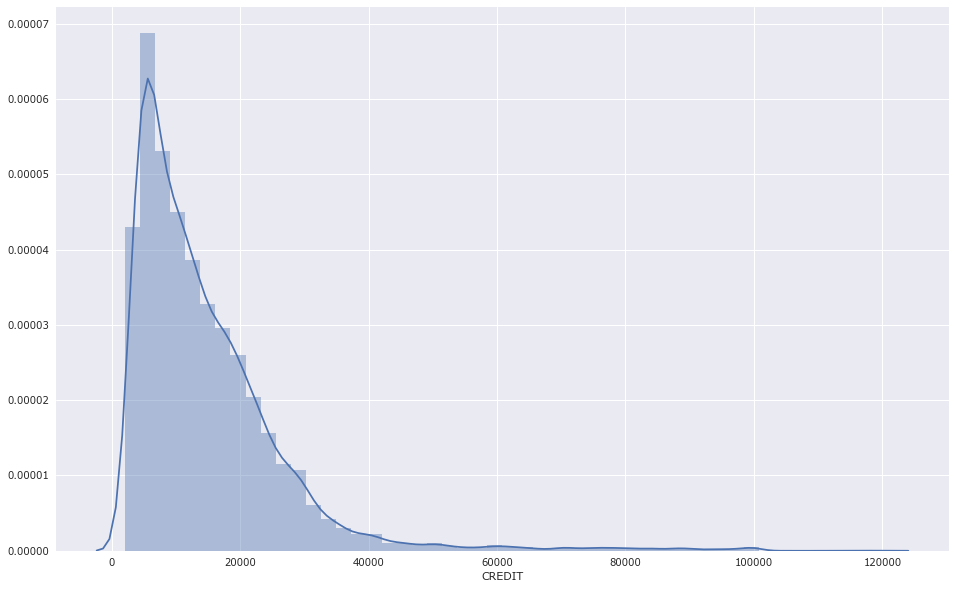

In [46]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[5]])

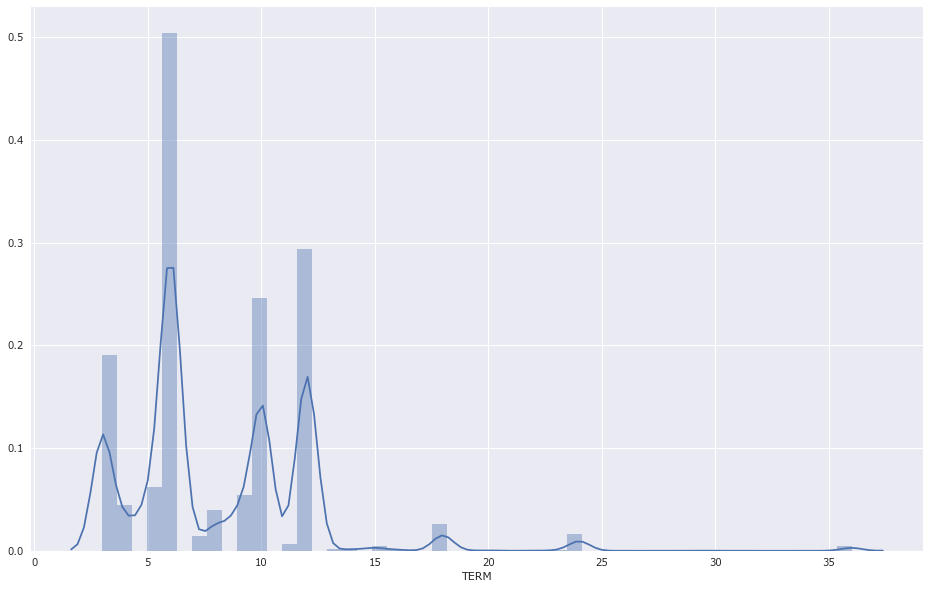

In [47]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[6]])

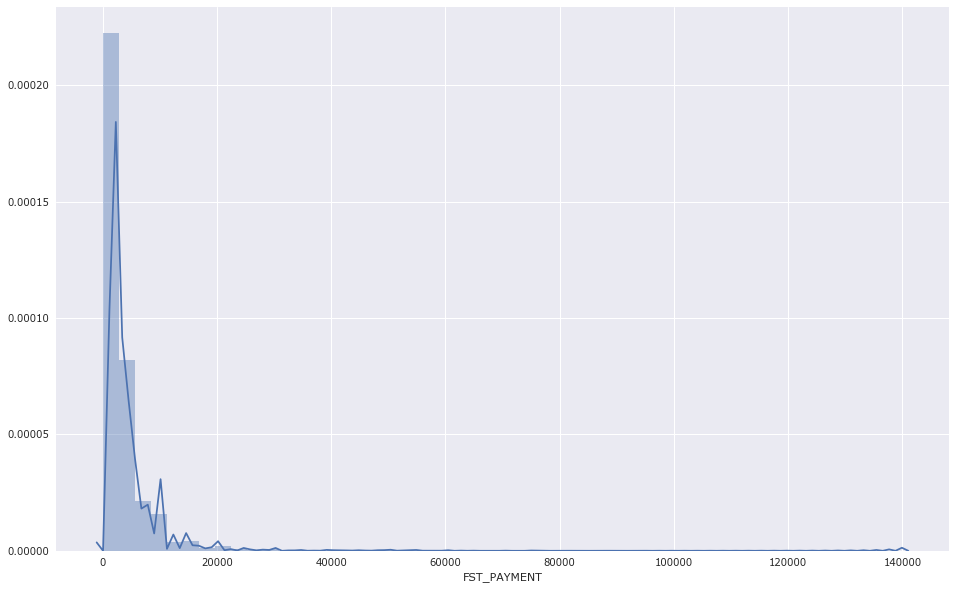

In [48]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[7]])

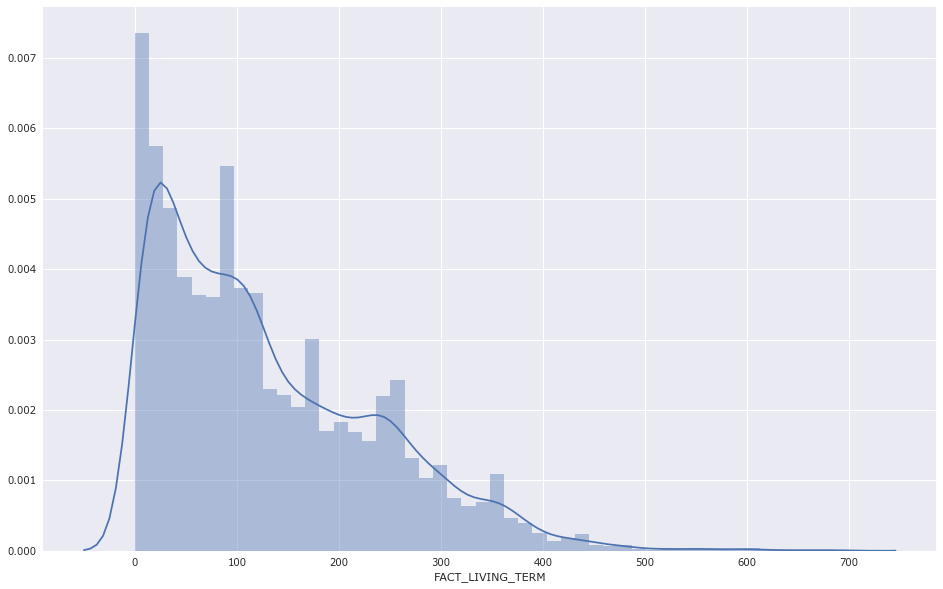

In [49]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[8]])

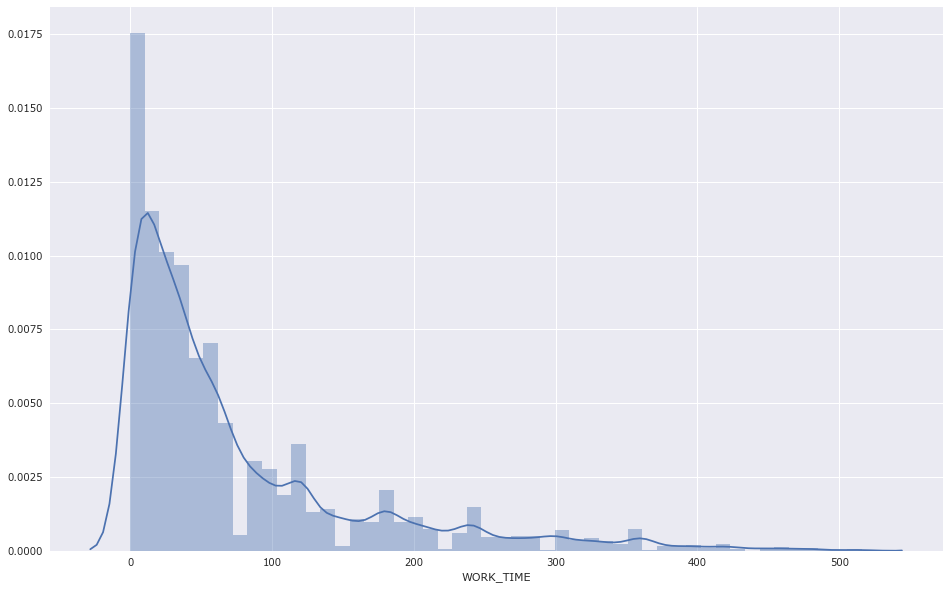

In [50]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[9]])

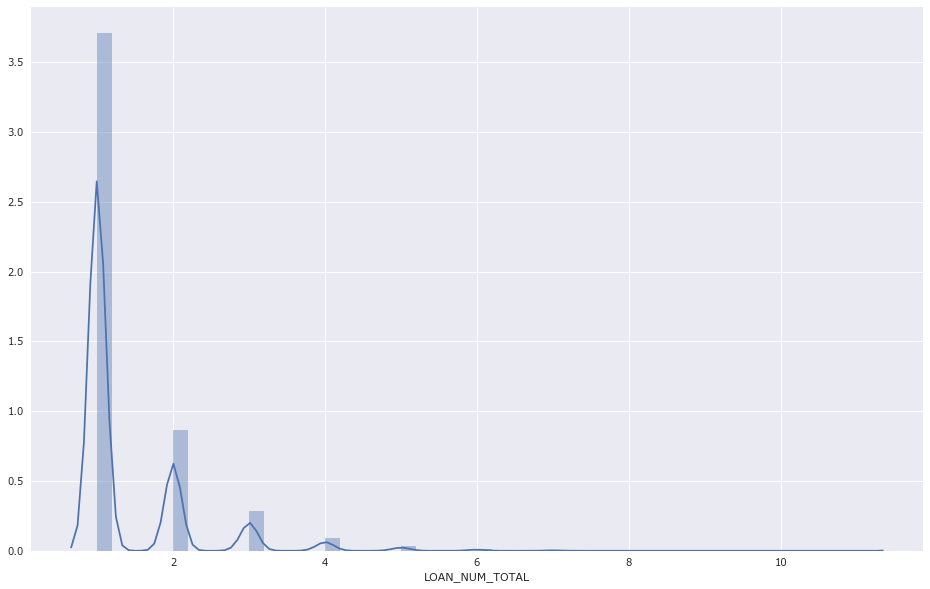

In [51]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[10]])

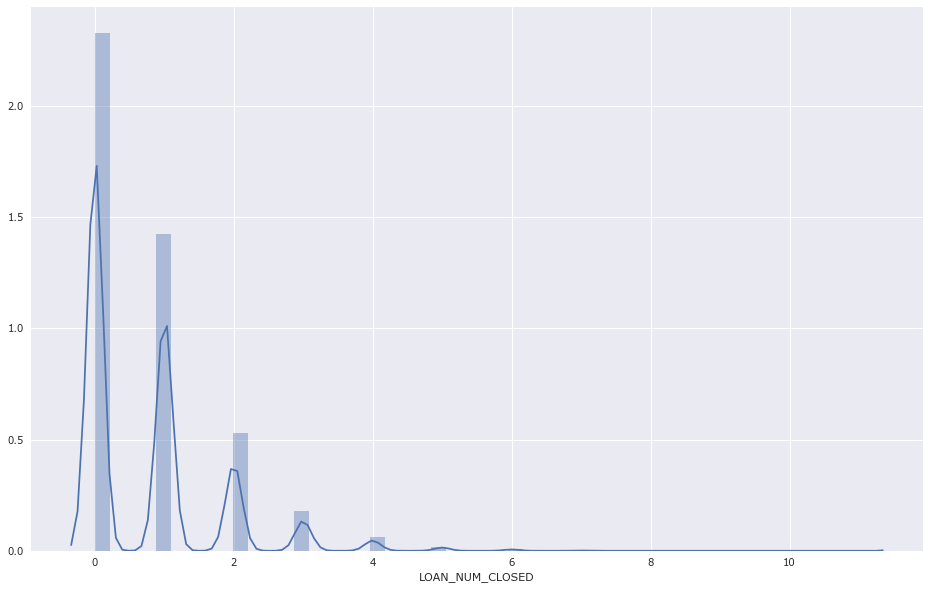

In [52]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[11]])

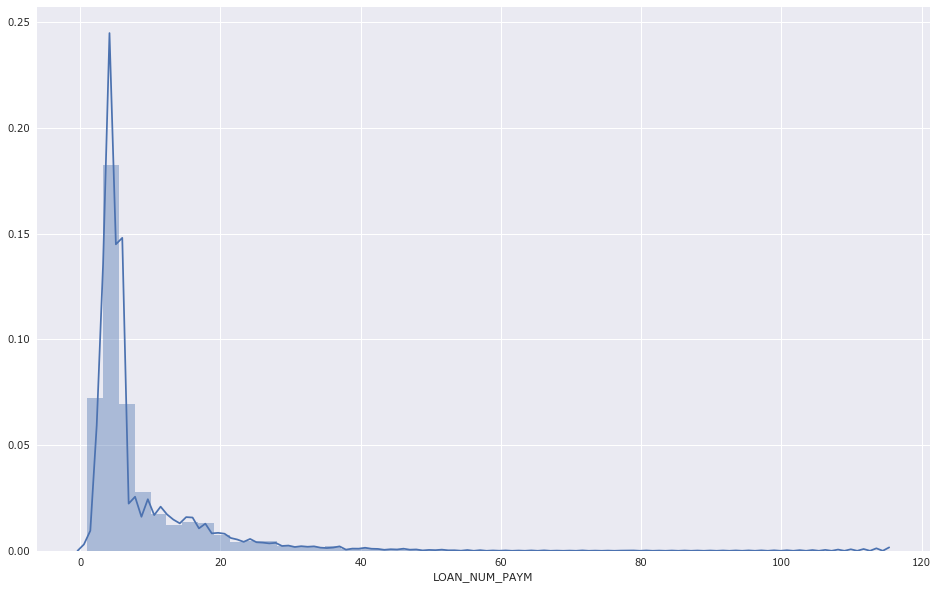

In [53]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[12]])

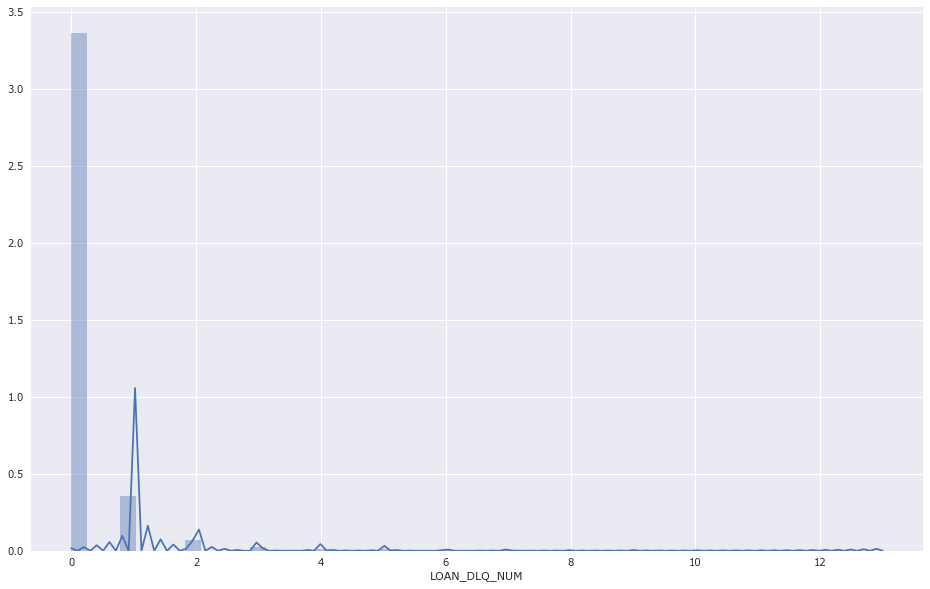

In [54]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[13]])

In [55]:
data['LOAN_DLQ_NUM'].value_counts()

0     13301
1      1416
2       280
3        96
4        48
5        39
6        16
7        14
9         4
8         3
13        2
10        2
12        1
11        1
Name: LOAN_DLQ_NUM, dtype: int64

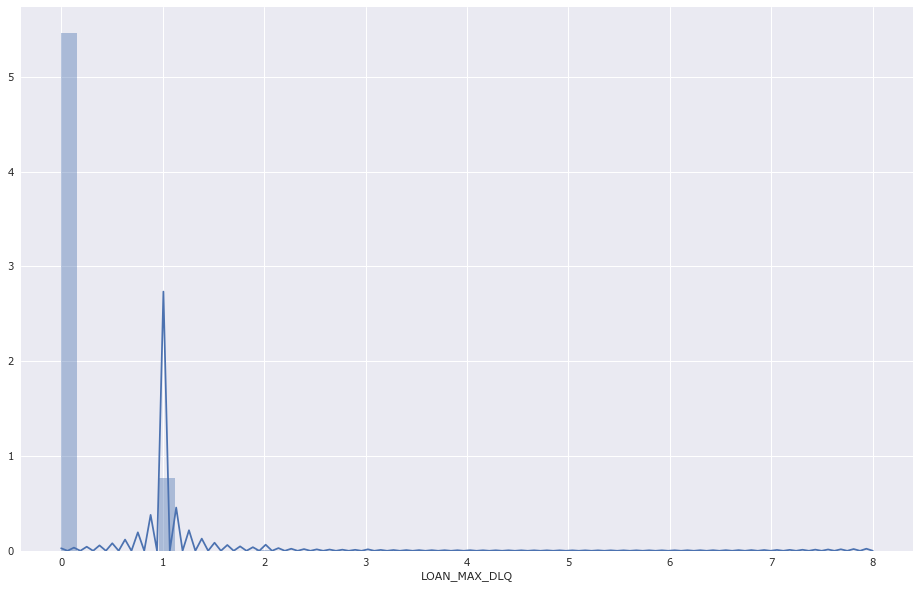

In [56]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[14]])

In [57]:
data['LOAN_MAX_DLQ'].value_counts()

0    13301
1     1881
2       31
3        7
6        1
4        1
8        1
Name: LOAN_MAX_DLQ, dtype: int64

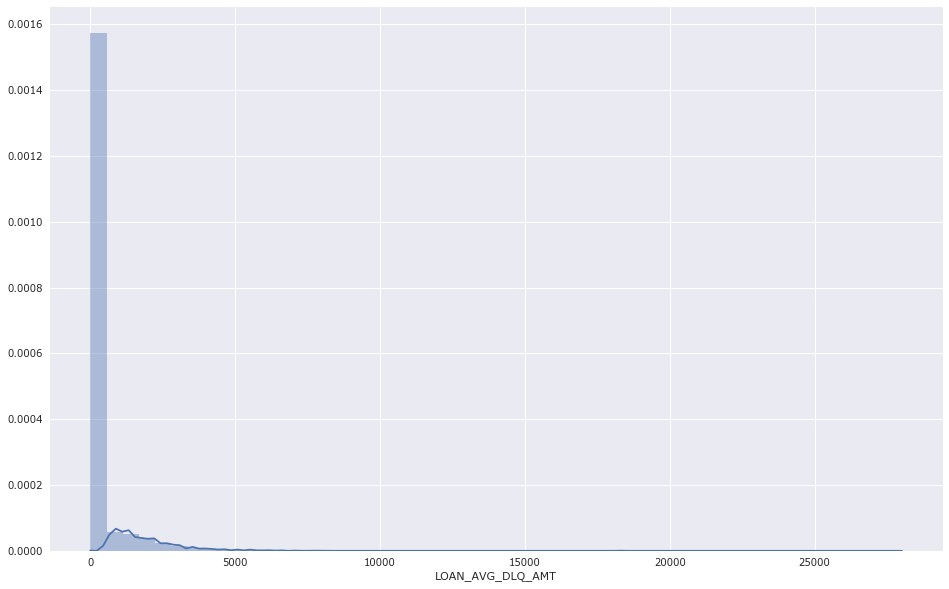

In [58]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[15]])

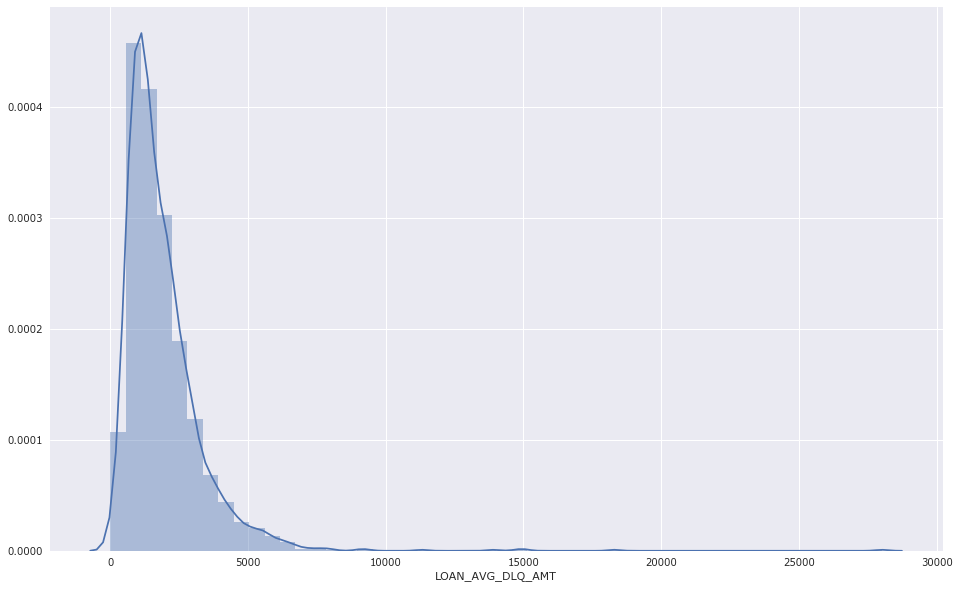

In [59]:
# без нуля
plt.subplots(figsize=(16, 10))

sns.distplot(data[data['LOAN_AVG_DLQ_AMT'] != 0]['LOAN_AVG_DLQ_AMT'])

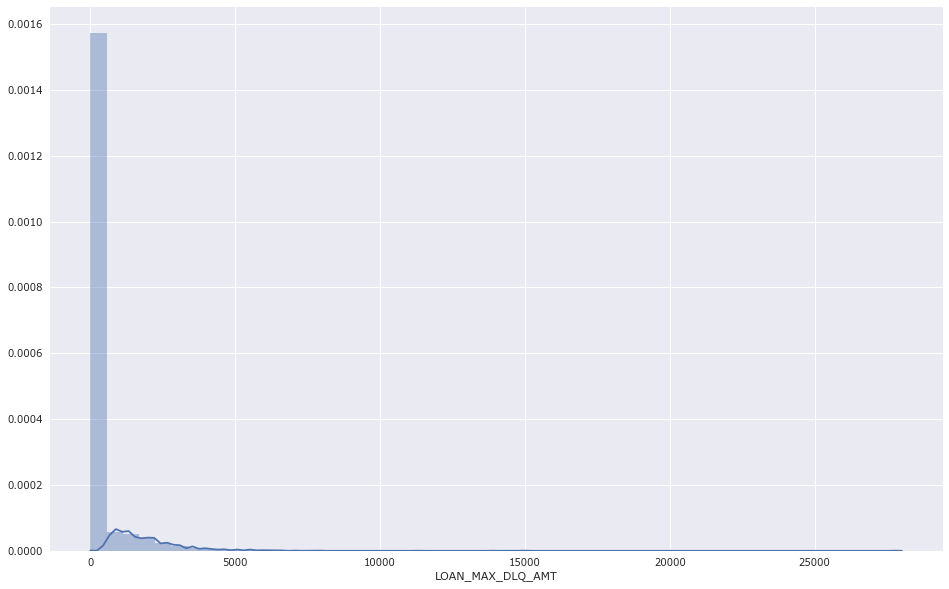

In [60]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[16]])

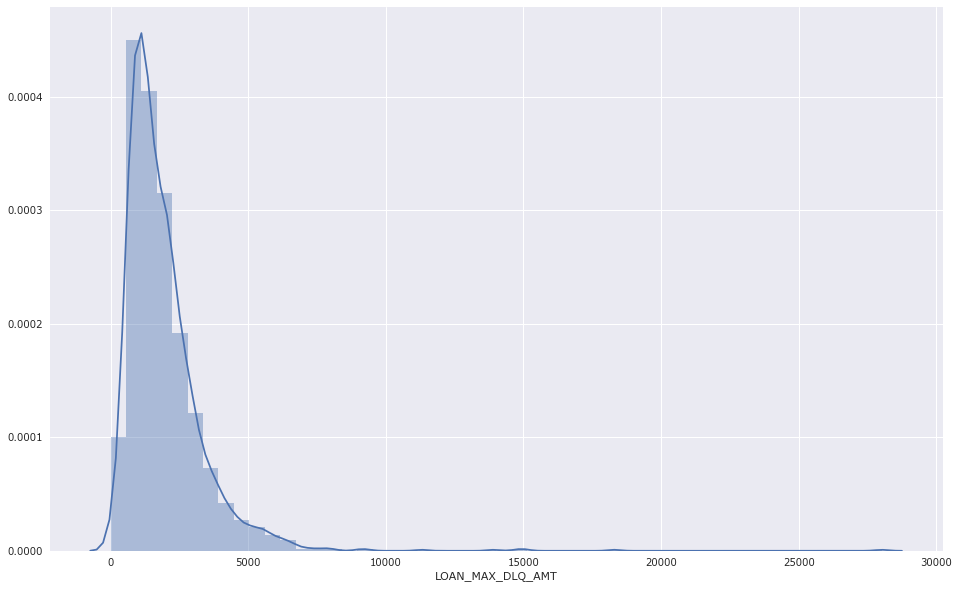

In [61]:
# без нуля
plt.subplots(figsize=(16, 10))

sns.distplot(data[data['LOAN_MAX_DLQ_AMT'] != 0]['LOAN_MAX_DLQ_AMT'])

## Бининг

In [62]:
cat_columns, num_columns = columns()

In [63]:
cols_enl = show_binning(categorical_columns=cat_columns)

Среднее специальное               6518
Среднее                           4679
Высшее                            3133
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образования      20
Ученая степень                       1
Name: EDUCATION, dtype: int64

Торговля                                     2385
Другие сферы                                 1709
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   

In [64]:
data[cols_enl[0]].value_counts()

Среднее специальное               6518
Среднее                           4679
Высшее                            3133
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образования      20
Ученая степень                       1
Name: EDUCATION, dtype: int64

In [65]:
data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'

In [66]:
data[cols_enl[1]].value_counts()

Торговля                                     2385
Другие сферы                                 1709
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [67]:
data.at[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
small_categories_aggregation(column='GEN_INDUSTRY', n_samples=20, value='Другие сферы')
data[cols_enl[1]].value_counts()

Торговля                                     2385
Другие сферы                                 1756
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [68]:
data[cols_enl[2]].value_counts()

Специалист                        7010
Рабочий                           3075
nan                               1367
Служащий                           904
Руководитель среднего звена        697
Работник сферы услуг               563
Высококвалифиц. специалист         549
Руководитель высшего звена         427
Индивидуальный предприниматель     217
Другое                             177
Руководитель низшего звена         136
Военнослужащий по контракту         88
Партнер                             13
Name: GEN_TITLE, dtype: int64

In [69]:
data[cols_enl[3]].value_counts()

Частная компания                  6523
Государственная комп./учреж.      6112
nan                               1367
Индивидуальный предприниматель     957
Некоммерческая организация         243
Частная ком. с инос. капиталом      21
Name: ORG_TP_STATE, dtype: int64

In [70]:
data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'

In [71]:
data[cols_enl[4]].value_counts()

Участие в основ. деятельности    11452
nan                               1367
Вспомогательный техперсонал       1025
Бухгалтерия, финансы, планир.      481
Адм-хоз. и трансп. службы          279
Снабжение и сбыт                   217
Служба безопасности                164
Кадровая служба и секретариат      101
Пр-техн. обесп. и телеком.          75
Юридическая служба                  53
Реклама и маркетинг                  9
Name: JOB_DIR, dtype: int64

In [128]:
data.at[data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Юридическая служба'

In [72]:
data[cols_enl[5]].value_counts()

от 10000 до 20000 руб.    7077
от 20000 до 50000 руб.    6082
от 5000 до 10000 руб.     1512
свыше 50000 руб.           492
до 5000 руб.                60
Name: FAMILY_INCOME, dtype: int64

In [73]:
data[cols_enl[6]].value_counts()

Кемеровская область            674
Краснодарский край             674
Алтайский край                 459
Читинская область              426
Приморский край                416
Ростовская область             407
Свердловская область           349
Саратовская область            331
Волгоградская область          331
Воронежская область            301
Вологодская область            292
Челябинская область            292
Татарстан                      287
Омская область                 287
Кировская область              264
Архангельская область          257
Оренбургская область           253
Хабаровский край               252
Тульская область               252
Красноярский край              239
Самарская область              235
Башкирия                       222
Курская область                217
Белгородская область           215
Новосибирская область          214
Липецкая область               206
Иркутская область              202
Тюменская область              199
Бурятия             

In [74]:
data.at[data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'

In [75]:
data[cols_enl[7]].value_counts()

Кемеровская область            674
Краснодарский край             674
Алтайский край                 454
Читинская область              426
Приморский край                415
Ростовская область             404
Свердловская область           348
Волгоградская область          332
Саратовская область            324
Воронежская область            301
Челябинская область            292
Вологодская область            292
Татарстан                      286
Омская область                 286
Кировская область              266
Архангельская область          255
Хабаровский край               254
Оренбургская область           250
Тульская область               249
Самарская область              239
Красноярский край              237
Башкирия                       221
Новосибирская область          216
Белгородская область           214
Курская область                213
Московская область             207
Иркутская область              203
Липецкая область               202
Тюменская область   

In [76]:
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'

In [77]:
data[cols_enl[8]].value_counts()

Кемеровская область            674
Краснодарский край             674
Алтайский край                 456
Читинская область              426
Приморский край                415
Ростовская область             404
Свердловская область           348
Волгоградская область          331
Саратовская область            326
Воронежская область            302
Вологодская область            293
Челябинская область            292
Татарстан                      287
Омская область                 286
Кировская область              266
Архангельская область          255
Хабаровский край               254
Оренбургская область           251
Тульская область               249
Красноярский край              239
Самарская область              239
Башкирия                       221
Новосибирская область          215
Курская область                214
Белгородская область           212
Липецкая область               204
Московская область             203
Иркутская область              202
Тюменская область   

In [78]:
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'

In [79]:
data[cols_enl[9]].value_counts()

Краснодарский край         790
Кемеровская область        668
Алтайский край             436
Приморский край            413
Читинская область          412
Ставропольский край        411
Ростовская область         405
Челябинская область        354
Свердловская область       340
Волгоградская область      339
Кировская область          333
Саратовская область        317
Воронежская область        312
Красноярский край          295
nan                        295
Вологодская область        292
Омская область             286
Татарстан                  272
Хабаровский край           258
Санкт-Петербург            254
Оренбургская область       251
Тульская область           245
Архангельская область      243
Новосибирская область      238
Самарская область          236
Амурская область           224
Курская область            212
Белгородская область       211
Бурятия                    211
Ярославская область        208
                          ... 
Пермская область           162
Чувашия 

In [80]:
# потому что соседи
data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'

In [81]:
data[cols_enl[10]].value_counts()

ЮЖНЫЙ                 2179
ЦЕНТРАЛЬНЫЙ 2         1934
ЗАПАДНО-СИБИРСКИЙ     1835
ЦЕНТРАЛЬНЫЙ 1         1653
ПОВОЛЖСКИЙ            1436
ПРИВОЛЖСКИЙ           1270
ВОСТОЧНО-СИБИРСКИЙ    1256
УРАЛЬСКИЙ             1195
ДАЛЬНЕВОСТОЧНЫЙ       1141
СЕВЕРО-ЗАПАДНЫЙ       1028
ЦЕНТРАЛЬНЫЙ ОФИС       295
nan                      1
Name: REGION_NM, dtype: int64

In [82]:
data.at[data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'

In [83]:
data[cols_enl[11]].value_counts()

0    15074
1      149
Name: COT_PRESENCE_FL, dtype: int64

## Добавление фичей

In [85]:
data['SOLVENCY'] = (data['CREDIT']/data['TERM'])/data['PERSONAL_INCOME']

In [86]:
# просрачивал ли клиент когда-либо оплату кредита
data['DELAY'] = '0'
data.at[data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
data.at[data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
data['DELAY'].value_counts()

0    13301
1     1922
Name: DELAY, dtype: int64

In [87]:
cat_columns, num_columns = columns()

In [88]:
for i in cat_columns:
    if len(data[i].value_counts()) > 15:
        print(data[i].value_counts())
        print()

Торговля                                     2385
Другие сферы                                 1756
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [89]:
data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())
data['POSTAL_ADDRESS_PROVINCE'] = data['POSTAL_ADDRESS_PROVINCE'].map(data['POSTAL_ADDRESS_PROVINCE'].value_counts())
data['TP_PROVINCE'] = data['TP_PROVINCE'].map(data['TP_PROVINCE'].value_counts())

## Обработка численных полей

In [90]:
columns_to_category = ['CHILD_TOTAL', 'DEPENDANTS', 'OWN_AUTO', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED', 'LOAN_DLQ_NUM']

In [91]:
data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)

In [92]:
# переводим в категориальные значения
for i in columns_to_category:
    if i in data.columns:
        data[i]=data[i].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 51 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null object
DEPENDANTS                    15223 non-null object
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null int64
FACT_ADD

In [93]:
for col in columns_to_category:
    print(data[col].value_counts())
    print()

1     5087
0     4984
2     4140
3      799
4      133
5       59
6       12
7        5
10       3
8        1
Name: CHILD_TOTAL, dtype: int64

0    8226
1    4535
2    2167
3     243
4      42
5       5
6       4
7       1
Name: DEPENDANTS, dtype: int64

0    13453
1     1769
2        1
Name: OWN_AUTO, dtype: int64

1     11288
2      2633
3       871
4       275
5       102
6        36
7        14
8         3
11        1
Name: LOAN_NUM_TOTAL, dtype: int64

0     7791
1     4761
2     1770
3      603
4      202
5       62
6       26
7        5
8        2
11       1
Name: LOAN_NUM_CLOSED, dtype: int64

0     13301
1      1416
2       280
3        96
4        48
5        39
6        16
7        14
9         4
8         3
10        2
13        2
12        1
11        1
Name: LOAN_DLQ_NUM, dtype: int64



In [94]:
data.at[data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'

In [95]:
data.at[data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
data.at[data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
data.at[data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'

In [96]:
data.at[data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'

In [97]:
data.at[data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
data.at[data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'

In [98]:
data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'

In [99]:
data.at[data['LOAN_DLQ_NUM'] == '9', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '8', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '10', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '13', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '11', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '12', 'LOAN_DLQ_NUM'] = '7'

In [100]:
cats, nums = columns()

In [101]:
data.describe()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,SOLVENCY
count,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000
mean,40.4061,13853.8363,270.7468,269.9668,270.2251,295.1775,14667.9593,8.1010,3398.5627,131.0020,75.5412,7.8760,239.4571,243.0216,0.0191,0.1683
std,11.6011,9015.4676,157.6221,157.3229,157.3993,172.4570,12147.8735,4.0941,5158.1089,107.6183,89.5994,7.9557,827.7004,836.1001,0.1377,1.1911
min,21.0000,24.0000,22.0000,22.0000,22.0000,19.0000,2000.0000,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0058
25%,30.0000,8000.0000,167.0000,165.0000,166.0000,164.0000,6500.0000,6.0000,1000.0000,41.0000,14.0000,4.0000,0.0000,0.0000,0.0000,0.0846
50%,39.0000,12000.0000,217.0000,216.0000,215.0000,251.0000,11550.0000,6.0000,2000.0000,107.0000,40.0000,5.0000,0.0000,0.0000,0.0000,0.1325
75%,50.0000,17000.0000,331.0000,324.0000,326.0000,354.0000,19170.0000,10.0000,4000.0000,204.0000,96.0000,8.0000,0.0000,0.0000,0.0000,0.2027
max,67.0000,250000.0000,674.0000,674.0000,674.0000,790.0000,119700.0000,36.0000,140000.0000,696.0000,516.0000,114.0000,28012.2000,28012.2000,2.0000,146.5417


In [102]:
data[cats].describe()

,TARGET,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,GPF_DOCUMENT_FL,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,DELAY
count,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223
unique,2,2,2,2,5,5,5,5,27,13,5,3,11,5,11,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,7,8,8,2
top,0,1,0,1,1,0,Среднее специальное,Состою в браке,Торговля,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,ЮЖНЫЙ,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0
freq,13411,13847,13176,9964,5087,8226,6518,9416,2385,7010,6544,13688,11452,7077,2180,12765,14480,13493,12758,13782,10507,13453,14097,11940,15074,14930,14558,8961,9311,14389,13855,11288,7791,13301,13301


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 51 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null object
DEPENDANTS                    15223 non-null object
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null int64
FACT_ADD

In [104]:
dummy_data = pd.get_dummies(data)

# Data Processing Tool
[Вернуться к быстрому перемещению](#Быстрое-перемещение)

## Первая версия

In [11]:
def process_data(data):

    # указано в условии
    data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)
    
    # удаляем id
    data.drop('AGREEMENT_RK', axis=1, inplace=True)
    
    # одно уникальное значение
    data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)
    
    categorical_columns = ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 'EDUCATION', 'MARITAL_STATUS',
                           'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR',
                           'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE',
                           'REGION_NM', 'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
                           'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
                           'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
                           'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL', 
                           'PREVIOUS_CARD_NUM_UTILIZED']
    
    for i in categorical_columns:
        if i in data.columns:
            data[i] = data[i].astype('str')
    
    # если человек нигде не работает, то WORK_TIME = 0
    data.at[(data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0
    
    # максимальное значение, после которого значения считаются "неправильными"
    maxy_work_time = max(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN
    
    true_median = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
    data['WORK_TIME'].fillna(true_median, inplace=True)
    
    data.at[data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    
    maxy_live_term = max(data['FACT_LIVING_TERM'].sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN
    
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
    
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[
                            :heu_const_work_time].median()
    data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)
    
    for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
        if i in data.columns:
            data[i] = data[i].str.replace(',', '.').astype('float')
    
    cat_columns, num_columns = columns()
    
    data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'
    
    data.at[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
    small_categories_aggregation(column='GEN_INDUSTRY', n_samples=20, value='Другие сферы')
    
    data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'
    
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[
        data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    # потому что соседи
    data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'
    
    data.at[data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'
    
    # просрачивал ли клиент когда-либо оплату кредита
    data['DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
    
    cat_columns, num_columns = columns()
    
    data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
    data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())
    data['POSTAL_ADDRESS_PROVINCE'] = data['POSTAL_ADDRESS_PROVINCE'].map(data['POSTAL_ADDRESS_PROVINCE'].value_counts())
    data['TP_PROVINCE'] = data['TP_PROVINCE'].map(data['TP_PROVINCE'].value_counts())
    
    columns_to_category = ['CHILD_TOTAL', 'DEPENDANTS', 'OWN_AUTO', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED', 'LOAN_DLQ_NUM']
    
    data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)
    
    # переводим в категориальные значения
    for i in columns_to_category:
        if i in data.columns:
            data[i] = data[i].astype('str')
    
    data.at[data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'
    
    data.at[data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'
    
    data.at[data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'
    
    data.at[data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
    data.at[data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'
    
    data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    
    data.at[data['LOAN_NUM_CLOSED'] == '9', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '10', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '13', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    
    cats, nums = columns()
    
    return pd.get_dummies(data), data, cats, nums

## Вторая версия

In [6]:
def process_data():
    
    pre_data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep=';')

    pre_data = pre_data.reindex(np.random.permutation(pre_data.index))
    
    data = pre_data[:int(len(pre_data)*0.7)]
    test_data = pre_data[int(len(pre_data)*0.7):]

#     data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep=';')
#     test_data = pd.read_csv("data/Credit_OTP_new.csv", encoding='cp1251', sep=';')
    
    categorical_columns = ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 'EDUCATION', 'MARITAL_STATUS',
                           'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR',
                           'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE',
                           'REGION_NM', 'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
                           'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
                           'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
                           'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL', 
                           'PREVIOUS_CARD_NUM_UTILIZED']        

    # указано в условии
    data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)
    test_data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)
    
    # удаляем id
    data.drop('AGREEMENT_RK', axis=1, inplace=True)
    test_data.drop('AGREEMENT_RK', axis=1, inplace=True)
    
    # одно уникальное значение
    data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)
    test_data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

    
    for i in categorical_columns:
        if i in data.columns:
            data[i] = data[i].astype('str')
            test_data[i] = test_data[i].astype('str')
    
    
    # если человек нигде не работает, то WORK_TIME = 0
    data.at[(data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0
    test_data.at[(test_data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0
    
    # эспериментально выбранное значение
    heu_const_work_time = 15200
    true_median = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
    
    # максимальное значение, после которого значения считаются "неправильными"
    maxy_work_time = max(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN
    
    try:
        test_data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN
    except:
        pass
    
    true_median_work_time = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
    data['WORK_TIME'].fillna(true_median_work_time, inplace=True)
    test_data['WORK_TIME'].fillna(true_median_work_time, inplace=True)
    
    data.at[data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    test_data.at[test_data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    
    maxy_live_term = 696
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN
    test_data.at[test_data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN
    
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
    data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)
    test_data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)
    
    for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
        if i in data.columns:
            data[i] = data[i].str.replace(',', '.').astype('float')
            test_data[i] = test_data[i].str.replace(',', '.').astype('float')
    
    cat_columns, num_columns = columns()
    
    data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'
    test_data.at[test_data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    test_data.at[test_data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'
    
    
    data.at[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
    test_data.at[test_data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
    
    tmp_small_columns = data['GEN_INDUSTRY'].value_counts()[data['GEN_INDUSTRY'].value_counts() < 20].index

    for col in tmp_small_columns:
        data.at[data['GEN_INDUSTRY'] == col, 'GEN_INDUSTRY'] = 'Другие сферы'
        test_data.at[test_data['GEN_INDUSTRY'] == col, 'GEN_INDUSTRY'] = 'Другие сферы'
    
    
    data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'
    test_data.at[test_data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'
    
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    # потому что соседи
    data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'
    test_data.at[test_data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'
    
    data.at[data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'
    test_data.at[test_data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'
    
    # просрачивал ли клиент когда-либо оплату кредита
    data['DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
    test_data['DELAY'] = '0'
    test_data.at[test_data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
    test_data.at[test_data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
    
    cat_columns, num_columns = columns()
    
    tmp_data = data.copy()
    
    data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
    data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())
    data['POSTAL_ADDRESS_PROVINCE'] = data['POSTAL_ADDRESS_PROVINCE'].map(data['POSTAL_ADDRESS_PROVINCE'].value_counts())
    data['TP_PROVINCE'] = data['TP_PROVINCE'].map(data['TP_PROVINCE'].value_counts())
    
    test_data_freq_func_reg = lambda x: DataFrame(tmp_data['REG_ADDRESS_PROVINCE'].value_counts()).loc[x, 'REG_ADDRESS_PROVINCE']
    test_data_freq_func_fact = lambda x: DataFrame(tmp_data['FACT_ADDRESS_PROVINCE'].value_counts()).loc[x, 'FACT_ADDRESS_PROVINCE']
    test_data_freq_func_postal = lambda x: DataFrame(tmp_data['POSTAL_ADDRESS_PROVINCE'].value_counts()).loc[x, 'POSTAL_ADDRESS_PROVINCE']
    test_data_freq_func_tp = lambda x: DataFrame(tmp_data['TP_PROVINCE'].value_counts()).loc[x, 'TP_PROVINCE']

    test_data['REG_ADDRESS_PROVINCE'] = test_data['REG_ADDRESS_PROVINCE'].map(test_data_freq_func_reg)
    test_data['FACT_ADDRESS_PROVINCE'] = test_data['FACT_ADDRESS_PROVINCE'].map(test_data_freq_func_fact)
    test_data['POSTAL_ADDRESS_PROVINCE'] = test_data['POSTAL_ADDRESS_PROVINCE'].map(test_data_freq_func_postal)
    test_data['TP_PROVINCE'] = test_data['TP_PROVINCE'].map(test_data_freq_func_tp)
    
    data.at[data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Юридическая служба'
    test_data.at[test_data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Юридическая служба'
    
    columns_to_category = ['CHILD_TOTAL', 'DEPENDANTS', 'OWN_AUTO', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED',
                           'LOAN_DLQ_NUM']
    
    data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)
    test_data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)
    
    # переводим в категориальные значения
    for i in columns_to_category:
        if i in data.columns:
            data[i] = data[i].astype('str')
            test_data[i] = test_data[i].astype('str')  
    
    data.at[data['PREVIOUS_CARD_NUM_UTILIZED'] == '2.0', 'PREVIOUS_CARD_NUM_UTILIZED'] = '1.0'
    test_data.at[test_data['PREVIOUS_CARD_NUM_UTILIZED'] == '2.0', 'PREVIOUS_CARD_NUM_UTILIZED'] = '1.0'
    
    data.at[data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'
    
    data.at[data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'    
    test_data.at[test_data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
    test_data.at[test_data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
    test_data.at[test_data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'
    
    data.at[data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'
    test_data.at[test_data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'
    
    data.at[data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
    data.at[data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'
    test_data.at[test_data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
    test_data.at[test_data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'
    
#     data.at[data['LOAN_NUM_CLOSED'] == '7', 'LOAN_NUM_CLOSED'] = '6'
    data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
#     test_data.at[test_data['LOAN_NUM_CLOSED'] == '7', 'LOAN_NUM_CLOSED'] = '6'
    test_data.at[test_data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    test_data.at[test_data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    
#     data.drop('LOAN_NUM_CLOSED', axis=1, inplace=True)
#     test_data.drop('LOAN_NUM_CLOSED', axis=1, inplace=True)
    
    data.at[data['LOAN_DLQ_NUM'] == '9', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '8', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '10', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '13', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '11', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '12', 'LOAN_DLQ_NUM'] = '7'
    
    test_data.at[test_data['LOAN_DLQ_NUM'] == '9', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '8', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '10', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '13', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '11', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '12', 'LOAN_DLQ_NUM'] = '7'
    
#     aggr_cols = ['AUTO_RUS_FL', 'HS_PRESENCE_FL', 'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL']
    
#     for i in aggr_cols:
        
#         data['AGGR_COLS'] = 0
#         test_data['AGGR_COLS'] = 0
        
#         data['AGGR_COLS'] += data[i].astype('int32')
#         test_data['AGGR_COLS'] += test_data[i].astype('int32')
        
#         data.drop(i, axis=1, inplace=True)
#         test_data.drop(i, axis=1, inplace=True)
    
    data['SOLVENCY'] = (data['CREDIT']/data['TERM'])/data['PERSONAL_INCOME']
    test_data['SOLVENCY'] = (test_data['CREDIT']/test_data['TERM'])/test_data['PERSONAL_INCOME']
    
    data.at[data['SOLVENCY'] > 100, 'SOLVENCY'] = data[data['SOLVENCY'] < 100]['SOLVENCY'].median()
    test_data.at[test_data['SOLVENCY'] > 100, 'SOLVENCY'] = test_data[test_data['SOLVENCY'] < 100]['SOLVENCY'].median()

    
#     data['PERCENT_FIRST_PAYMENT'] = data['FST_PAYMENT']/data['PERSONAL_INCOME']
#     test_data['PERCENT_FIRST_PAYMENT'] = test_data['FST_PAYMENT']/test_data['PERSONAL_INCOME']
    
    cats, nums = columns(data)
    
    data.reset_index(inplace=True)
    test_data.reset_index(inplace=True)
    
    data.drop('index', axis=1, inplace=True)
    test_data.drop('index', axis=1, inplace=True)
    
    dummy_train = pd.get_dummies(data)
    dummy_test = pd.get_dummies(test_data)
    
    return dummy_train, data, dummy_test, test_data, cats, nums

In [7]:
train_dummy, train_data, test_dummy, test_data, cats, nums = process_data()

In [8]:
cats

['TARGET',
 'SOCSTATUS_WORK_FL',
 'SOCSTATUS_PENS_FL',
 'GENDER',
 'CHILD_TOTAL',
 'DEPENDANTS',
 'EDUCATION',
 'MARITAL_STATUS',
 'GEN_INDUSTRY',
 'GEN_TITLE',
 'ORG_TP_STATE',
 'ORG_TP_FCAPITAL',
 'JOB_DIR',
 'FAMILY_INCOME',
 'REGION_NM',
 'REG_FACT_FL',
 'FACT_POST_FL',
 'REG_POST_FL',
 'REG_FACT_POST_FL',
 'REG_FACT_POST_TP_FL',
 'FL_PRESENCE_FL',
 'OWN_AUTO',
 'AUTO_RUS_FL',
 'HS_PRESENCE_FL',
 'COT_PRESENCE_FL',
 'GAR_PRESENCE_FL',
 'LAND_PRESENCE_FL',
 'GPF_DOCUMENT_FL',
 'FACT_PHONE_FL',
 'REG_PHONE_FL',
 'GEN_PHONE_FL',
 'LOAN_NUM_TOTAL',
 'LOAN_NUM_CLOSED',
 'LOAN_DLQ_NUM',
 'PREVIOUS_CARD_NUM_UTILIZED',
 'DELAY']

In [9]:
nums

['AGE',
 'PERSONAL_INCOME',
 'REG_ADDRESS_PROVINCE',
 'FACT_ADDRESS_PROVINCE',
 'POSTAL_ADDRESS_PROVINCE',
 'TP_PROVINCE',
 'CREDIT',
 'TERM',
 'FST_PAYMENT',
 'FACT_LIVING_TERM',
 'WORK_TIME',
 'LOAN_NUM_PAYM',
 'LOAN_AVG_DLQ_AMT',
 'LOAN_MAX_DLQ_AMT',
 'SOLVENCY']

In [8]:
train_dummy.head()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,SOLVENCY,TARGET_0,TARGET_1,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,...,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
0,22,6500.0000,119,123,122,122,11590.0000,12,4000.0000,108.0000,15.0000,5,0.0000,0.0000,0.1486,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,57,17000.0000,177,178,178,180,10804.0000,3,3385.0000,230.0000,6.0000,3,0.0000,0.0000,0.2118,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,50,10000.0000,170,168,170,203,3222.9000,5,358.1000,155.0000,72.0000,4,0.0000,0.0000,0.0645,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
3,39,10000.0000,109,108,108,107,6490.0000,6,5050.0000,2.0000,180.0000,5,0.0000,0.0000,0.1082,1,0,0,1,1,0,0,1,0,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,29,11000.0000,473,472,472,466,18553.0000,7,10000.0000,17.0000,39.0000,21,0.0000,0.0000,0.2409,1,0,0,1,1,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [9]:
test_dummy.head()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,SOLVENCY,TARGET_0,TARGET_1,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,...,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
0,44,16000.0000,63,63,63,322,25140.0000,6,6000.0000,132.0000,96.0000,3,0.0000,0.0000,0.2619,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,41,17000.0000,95,95,95,95,7498.0000,6,7500.0000,108.0000,276.0000,4,0.0000,0.0000,0.0735,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,50,10000.0000,473,472,472,466,2629.8000,5,292.2000,205.0000,120.0000,5,0.0000,0.0000,0.0526,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
3,35,20000.0000,473,472,472,466,13490.0000,9,1500.0000,142.0000,120.0000,6,0.0000,0.0000,0.0749,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,25,8000.0000,109,108,108,107,3490.0000,3,1000.0000,5.0000,24.0000,3,0.0000,0.0000,0.1454,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [10]:
len(train_data), len(test_data)

(10656, 4567)

In [11]:
train_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Columns: 175 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(160)
memory usage: 2.8 MB


In [12]:
test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4567 entries, 0 to 4566
Columns: 175 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(160)
memory usage: 1.2 MB


In [13]:
for i in test_dummy.columns:
    if i not in list(train_dummy.columns):
        print(i)

In [14]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                train_dummy.loc[:, 'TARGET_1'], test_size=0.3)

In [15]:
Xtrain.head()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,SOLVENCY,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,DEPENDANTS_2,DEPENDANTS_3,...,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
4901,63,6000.0000,292,292,292,282,8100.0000,6,900.0000,346.0000,0.0000,4,1550.0000,1550.0000,0.2250,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
9529,39,16000.0000,242,242,242,235,5089.0000,6,2000.0000,139.0000,18.0000,4,0.0000,0.0000,0.0530,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
6262,61,4500.0000,139,136,137,135,5000.0000,6,800.0000,156.0000,0.0000,6,940.0000,940.0000,0.1852,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
6454,31,14000.0000,131,125,126,119,20630.0000,12,2300.0000,17.0000,93.0000,5,0.0000,0.0000,0.1228,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1644,45,12000.0000,292,292,292,282,7473.0000,12,1400.0000,192.0000,180.0000,14,0.0000,0.0000,0.0519,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [16]:
Xtrain.reset_index(inplace=True)
Xtrain.drop('index', axis=1, inplace=True)

Xtest.reset_index(inplace=True)
Xtest.drop('index', axis=1, inplace=True)

ytrain = ytrain.reset_index()
ytrain.drop('index', axis=1, inplace=True)
ytrain = ytrain['TARGET_1']

ytest = ytest.reset_index()
ytest.drop('index', axis=1, inplace=True)
ytest = ytest['TARGET_1']

## Построение RF без подгонки параметров

In [17]:
forest = RandomForestClassifier(n_estimators=250, max_depth=9, max_features=15, n_jobs=-1, random_state=42)
forest.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict_proba(Xtest)[:, 1])

0.66061970242642509

In [18]:
X = test_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1)
y = test_dummy.loc[:, 'TARGET_1']

In [19]:
for i in Xtrain.columns:
    if i not in list(X.columns):
        print(i)

In [20]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7459 entries, 0 to 7458
Columns: 173 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(158)
memory usage: 2.0 MB


In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4567 entries, 0 to 4566
Columns: 173 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(158)
memory usage: 1.2 MB


In [22]:
roc_auc_score(y, forest.predict_proba(X)[:, 1])

0.68368868817276207

# Построение моделей
[Вернуться к быстрому перемещению](#Быстрое-перемещение)

## Случайный лес

### Кривые валидации

In [34]:
strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Trained on value: 100, AUC: 0.663
Trained on value: 150, AUC: 0.668
Trained on value: 200, AUC: 0.670
Trained on value: 250, AUC: 0.671
Trained on value: 300, AUC: 0.672
Trained on value: 350, AUC: 0.671
Trained on value: 400, AUC: 0.672
Trained on value: 450, AUC: 0.674
Trained on value: 500, AUC: 0.674
Trained on value: 550, AUC: 0.673


,AUC,Value
Best,0.6743,500


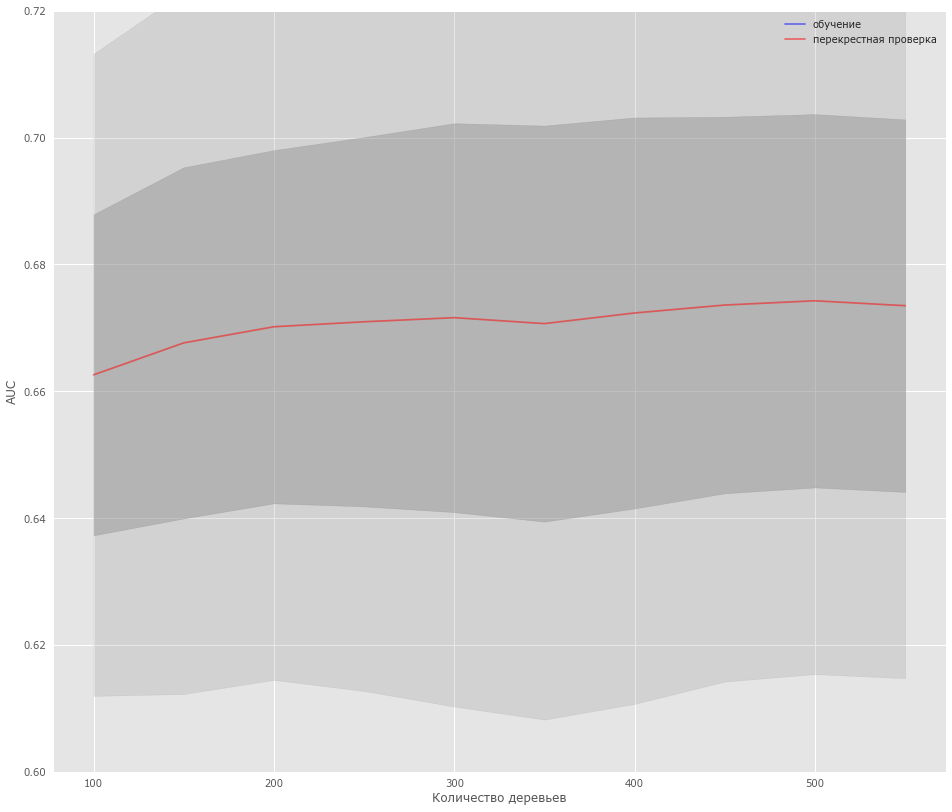

In [60]:
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
trees_grid = list(range(100, 551, 50))

for ntrees in trees_grid:
    rf = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(Xtrain, ytrain):
        X_train, X_test = Xtrain.iloc[train_index], Xtrain.iloc[test_index]
        y_train, y_test = ytrain[train_index], ytrain[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    print('Trained on value: {}, AUC: {:.3f}'.format(ntrees, np.array(temp_test_auc).mean()))

train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
display(DataFrame({'AUC': [max(test_auc.mean(axis=1))],
                   'Value': [trees_grid[np.argmax(test_auc.mean(axis=1))]]}, index=['Best']))

fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(trees_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', 
        label='обучение')
ax.plot(trees_grid, test_auc.mean(axis=1), alpha=0.5, color='red', 
        label='перекрестная проверка')
ax.fill_between(trees_grid, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.6, 0.72])
ax.set_ylabel("AUC")
ax.set_xlabel("Количество деревьев")

In [66]:
len(Xtrain.columns)**(1/2)*1/3, len(Xtrain.columns)**(1/2)*2

(4.384315479321969, 26.30589287593181)

Trained on value: 3, AUC: 0.677
Trained on value: 6, AUC: 0.683
Trained on value: 9, AUC: 0.683
Trained on value: 12, AUC: 0.678
Trained on value: 15, AUC: 0.678
Trained on value: 18, AUC: 0.678
Trained on value: 21, AUC: 0.673
Trained on value: 24, AUC: 0.673
Trained on value: 27, AUC: 0.668
Trained on value: 30, AUC: 0.667
Trained on value: 33, AUC: 0.672


,AUC,Value
Best,0.6829,6


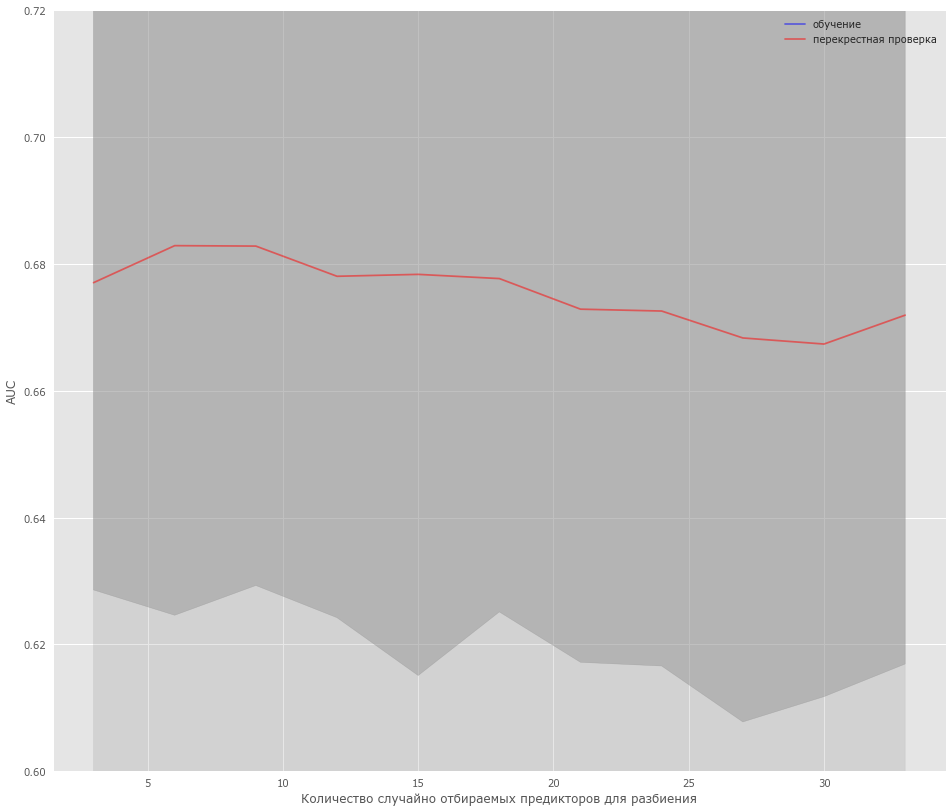

In [70]:
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
max_features_grid = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]

for max_features in max_features_grid:
    rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_features=max_features)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    print('Trained on value: {}, AUC: {:.3f}'.format(max_features, np.array(temp_test_auc).mean()))

train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
display(DataFrame({'AUC': [max(test_auc.mean(axis=1))],
                   'Value': max_features_grid[np.argmax(test_auc.mean(axis=1))]}, index=['Best']))

fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(max_features_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(max_features_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(max_features_grid, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.6, 0.72])
ax.set_ylabel("AUC")
ax.set_xlabel("Количество случайно отбираемых предикторов для разбиения")

Trained on value: 4, AUC: 0.680
Trained on value: 6, AUC: 0.682
Trained on value: 8, AUC: 0.685
Trained on value: 9, AUC: 0.685
Trained on value: 10, AUC: 0.683
Trained on value: 12, AUC: 0.682
Trained on value: 14, AUC: 0.681
Trained on value: 16, AUC: 0.680
Trained on value: 18, AUC: 0.683
Trained on value: 20, AUC: 0.681
Trained on value: 22, AUC: 0.679


,AUC,Value
Best,0.6847,9


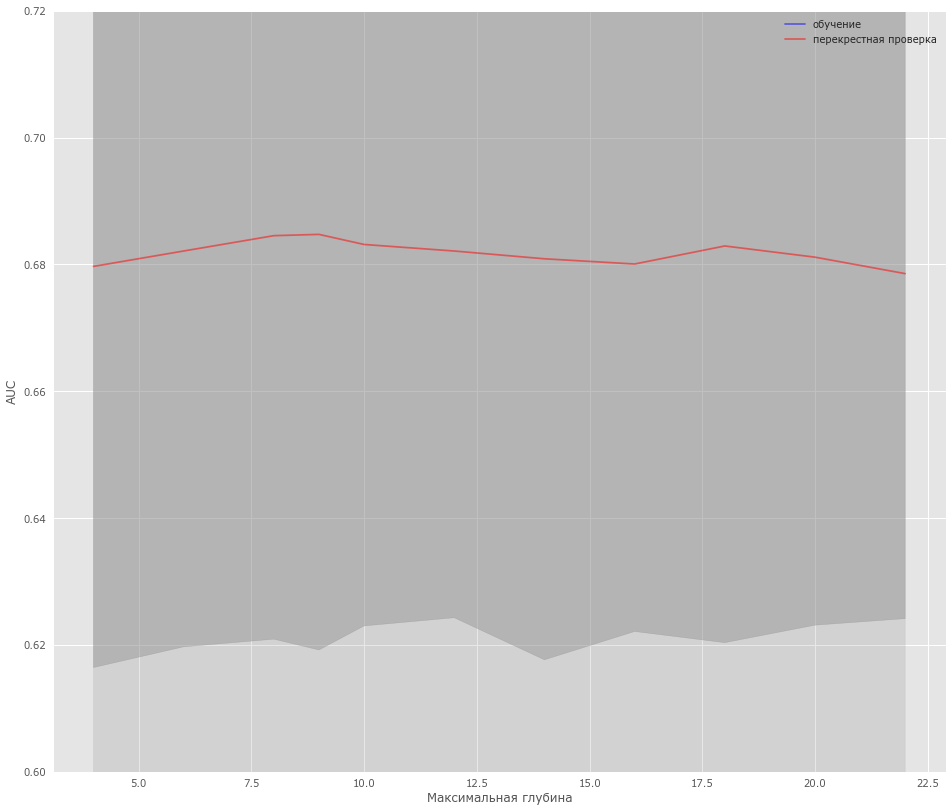

In [76]:
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
max_depth_grid = [4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22]

for max_depth in max_depth_grid:
    rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1,
                                max_depth=max_depth, max_features=8)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    print('Trained on value: {}, AUC: {:.3f}'.format(max_depth, np.array(temp_test_auc).mean()))

train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
display(DataFrame({'AUC': [max(test_auc.mean(axis=1))],
                   'Value': max_depth_grid[np.argmax(test_auc.mean(axis=1))]}, index=['Best']))

fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(max_depth_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(max_depth_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(max_depth_grid, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.6, 0.72])
ax.set_ylabel("AUC")
ax.set_xlabel("Максимальная глубина")

Trained on value: 1, AUC: 0.685
Trained on value: 3, AUC: 0.691
Trained on value: 5, AUC: 0.692
Trained on value: 7, AUC: 0.692
Trained on value: 9, AUC: 0.691
Trained on value: 11, AUC: 0.693
Trained on value: 13, AUC: 0.693
Trained on value: 15, AUC: 0.693
Trained on value: 17, AUC: 0.692
Trained on value: 20, AUC: 0.691
Trained on value: 22, AUC: 0.691
Trained on value: 24, AUC: 0.691


,AUC,Value
Best,0.6931,13


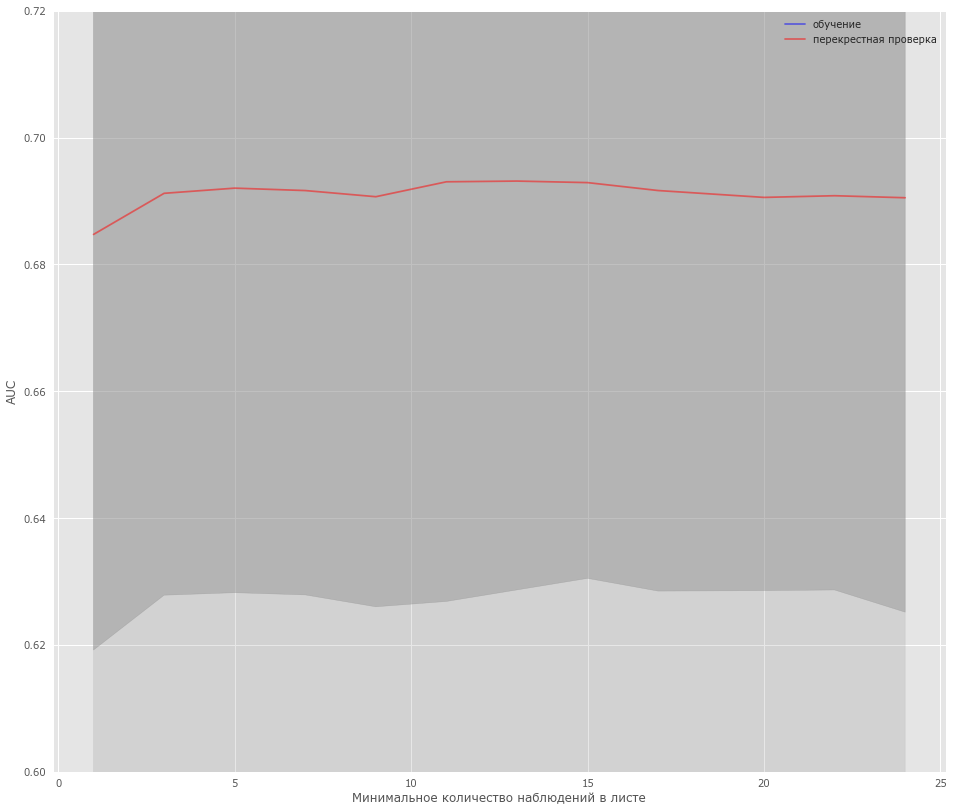

In [80]:
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for min_samples_leaf in min_samples_leaf_grid:
    rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_features=8, max_depth=9,
                                min_samples_leaf=min_samples_leaf)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    print('Trained on value: {}, AUC: {:.3f}'.format(min_samples_leaf, np.array(temp_test_auc).mean()))

train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
display(DataFrame({'AUC': [max(test_auc.mean(axis=1))],
                   'Value': min_samples_leaf_grid[np.argmax(test_auc.mean(axis=1))]}, index=['Best']))

fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(min_samples_leaf_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(min_samples_leaf_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(min_samples_leaf_grid, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.6, 0.72])
ax.set_ylabel("AUC")
ax.set_xlabel("Минимальное количество наблюдений в листе")

In [81]:
forest = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_features=8, max_depth=9,
                                min_samples_leaf=13)
forest.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict_proba(Xtest)[:, 1])

0.66919767907162875

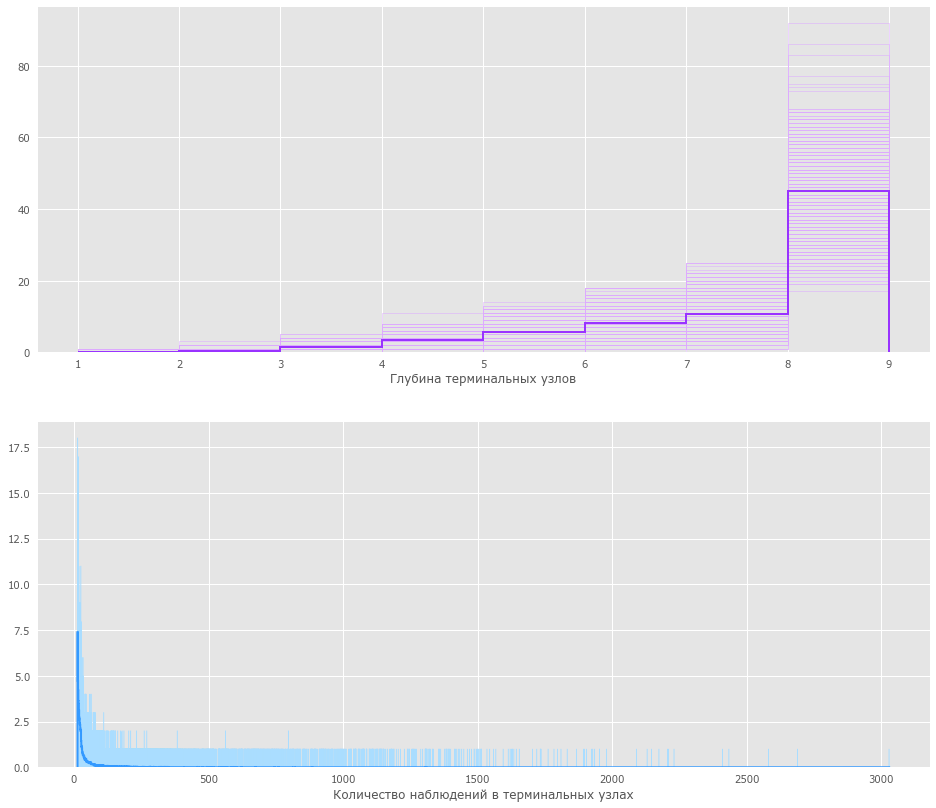

In [92]:
draw_ensemble(forest)

In [82]:
roc_auc_score(y, forest.predict_proba(X)[:, 1])

0.68906939100733544

In [83]:
feat_labels = Xtrain.columns
importances =  forest.feature_importances_
indices = np.argsort(importances)[::-1]
display(DataFrame({'feature': feat_labels[indices], 'importance': importances[indices]}))

,feature,importance
0,SOLVENCY,0.0599
1,AGE,0.0470
2,PERSONAL_INCOME,0.0447
3,WORK_TIME,0.0420
4,FACT_LIVING_TERM,0.0368
5,FST_PAYMENT,0.0360
6,LOAN_AVG_DLQ_AMT,0.0353
7,CREDIT,0.0317
8,LOAN_MAX_DLQ_AMT,0.0316
9,FACT_ADDRESS_PROVINCE,0.0269


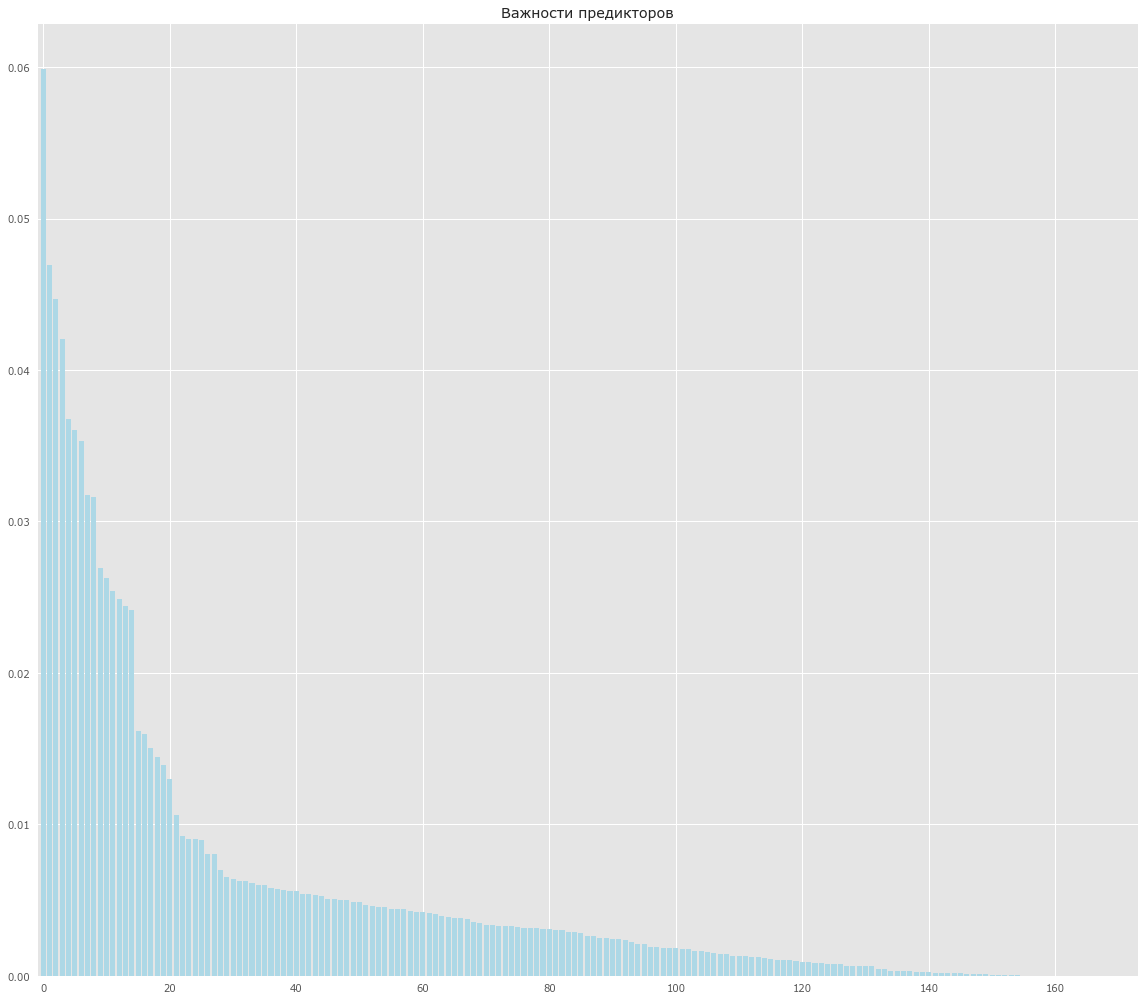

In [84]:
fig, ax = plt.subplots(figsize=(16, 14))

plt.title('Важности предикторов')

plt.bar(range(Xtrain.shape[1]), importances[indices],
              color='lightblue', align='center')

plt.xlim([-1, Xtrain.shape[1]])
plt.tight_layout()
plt.show()

### Grid Search

In [98]:
params = {'max_features': [9, 12, 15, 18, 21, 24, 27, 30, 33], 'max_depth': [3, 4, 5, 7, 9, 12, 15]}

In [100]:
rf = RandomForestClassifier(n_estimators=450, random_state=42)
grid_search = GridSearchCV(rf, params, n_jobs=-1, cv=strat, scoring='roc_auc', verbose=True)

In [101]:
grid_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:  4.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=450, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [9, 12, 15, 18, 21, 24, 27, 30, 33], 'max_depth': [3, 4, 5, 7, 9, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True)

In [102]:
grid_search.best_score_

0.67703549547269426

In [103]:
grid_search.best_params_

{'max_depth': 9, 'max_features': 9}

In [104]:
forest = RandomForestClassifier(n_estimators=400, max_depth=9, max_features=9, n_jobs=-1)
forest.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict_proba(Xtest)[:, 1])

0.69501190050392225

In [105]:
roc_auc_score(y, forest.predict_proba(X)[:, 1])

0.80042859062564797

In [106]:
feat_labels = Xtrain.columns
importances =  forest.feature_importances_
indices = np.argsort(importances)[::-1]
display(DataFrame({'feature': feat_labels[indices], 'importance': importances[indices]}))

,feature,importance
0,SOLVENCY,0.0487
1,PERSONAL_INCOME,0.0453
2,CREDIT,0.0401
3,FST_PAYMENT,0.0399
4,AGE,0.0396
5,FACT_LIVING_TERM,0.0349
6,WORK_TIME,0.0343
7,TERM,0.0267
8,REG_ADDRESS_PROVINCE,0.0260
9,FACT_ADDRESS_PROVINCE,0.0259


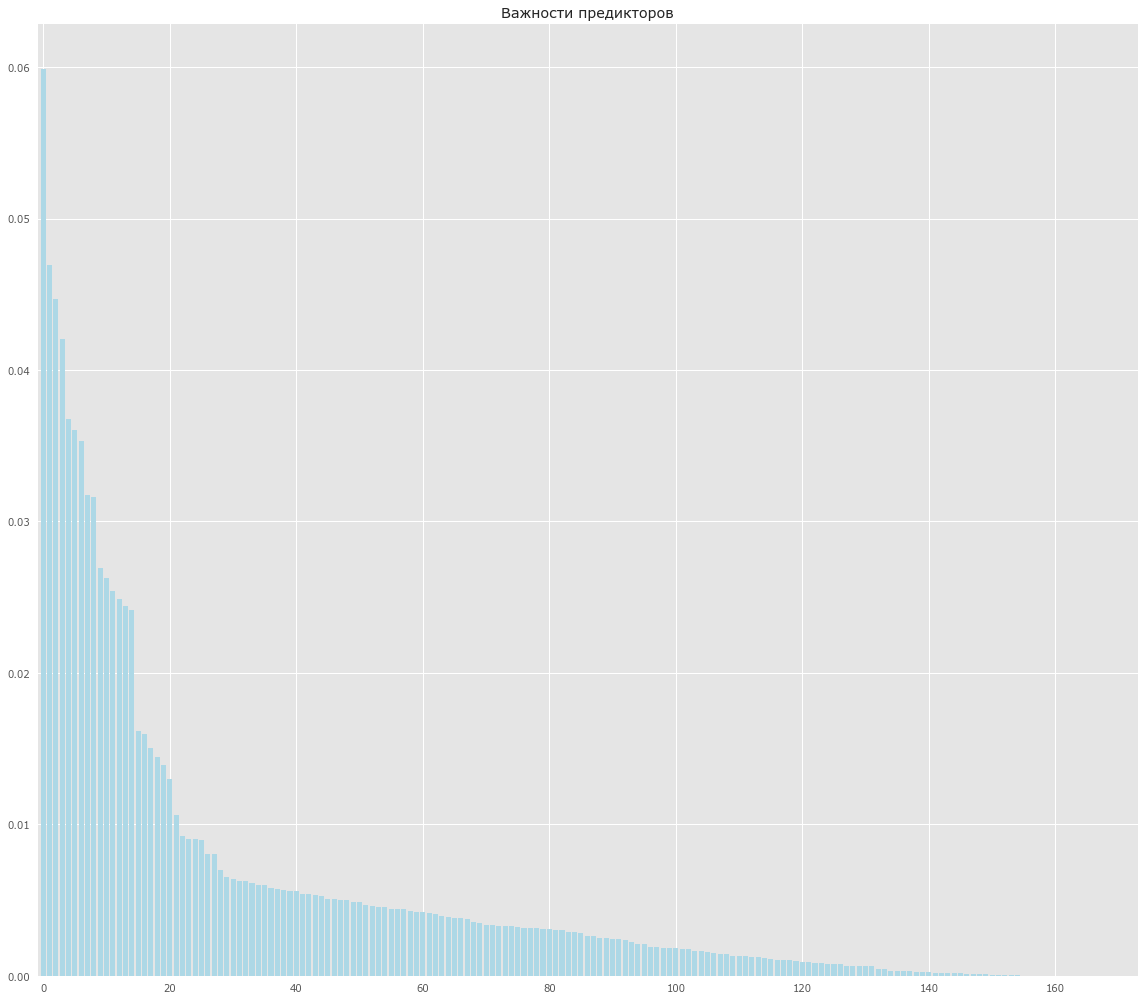

In [86]:
fig, ax = plt.subplots(figsize=(16, 14))

plt.title('Важности предикторов')
plt.bar(range(Xtrain.shape[1]), importances[indices],
              color='lightblue', align='center')

plt.xlim([-1, Xtrain.shape[1]])
plt.tight_layout()
plt.show()

In [87]:
pred_forest = forest.predict(Xtest)
confusion = confusion_matrix(ytest, pred_forest)
print("Матрица ошибок:\n{}".format(confusion))

Матрица ошибок:
[[2805    0]
 [ 392    0]]


In [90]:
print(classification_report(ytest, pred_forest,
                            target_names=["Не откликнулся", "Откликнулся"]))

                precision    recall  f1-score   support

Не откликнулся       0.88      1.00      0.93      2805
   Откликнулся       0.00      0.00      0.00       392

   avg / total       0.77      0.88      0.82      3197



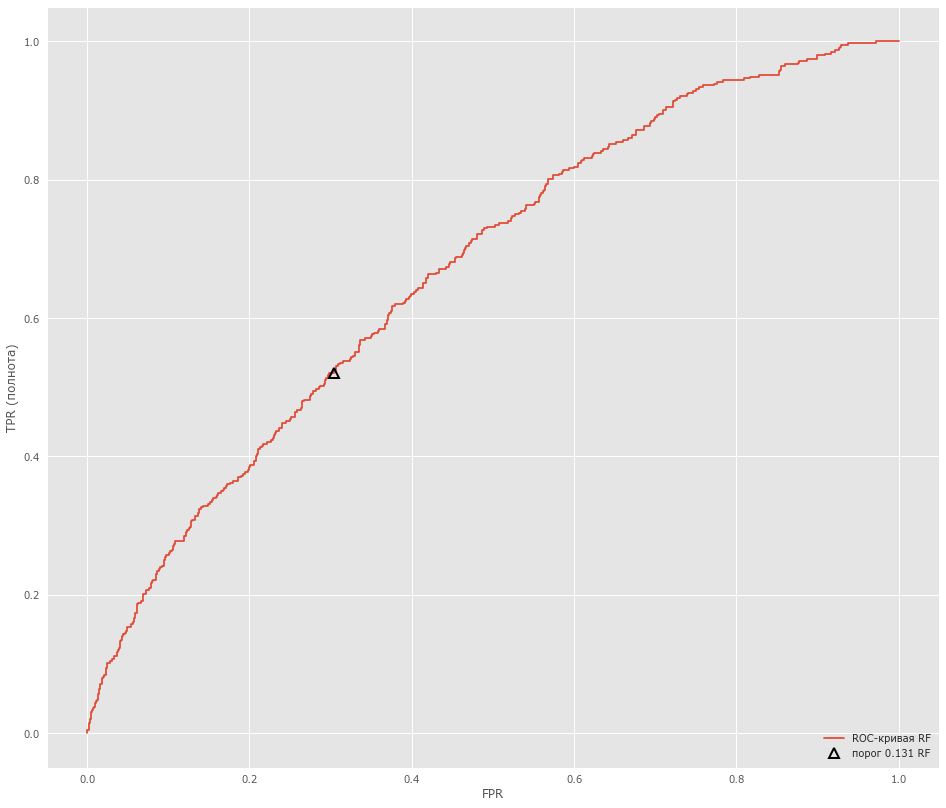

In [91]:
fig, ax = plt.subplots(figsize=(16, 14))

# Из модуля sklearn.metrics импортируем функцию roc_curve

# Вычисляем значения FPR и TPR для всех возможных порогов отсечения, передав функции 
# roc_curve в качестве аргументов фактические значения зависимой переменной, 
# записанные в y_control, и вероятности положительного класса, вычисленные 
# с помощью метода predict_proba
fpr_rf, tpr_rf, thresholds_rf = roc_curve(ytest, forest.predict_proba(Xtest)[:, 1])

# Создаем заголовок ROC-кривой
plt.plot(fpr_rf, tpr_rf, label="ROC-кривая RF")
# Задаем название для оси x
plt.xlabel("FPR")
# Задаем название для оси y
plt.ylabel("TPR (полнота)")
# Задаем порог отсечения по умолчанию 0.5
close_default_rf = np.argmin(np.abs(thresholds_rf-0.131))
# Строим ROC-кривую и наносим порог отсечения 0.5
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="порог 0.131 RF", fillstyle="none", c='k', mew=2)
# Задаем расположение легенды
plt.legend(loc=4)

## Логистическая регрессия

### Условия

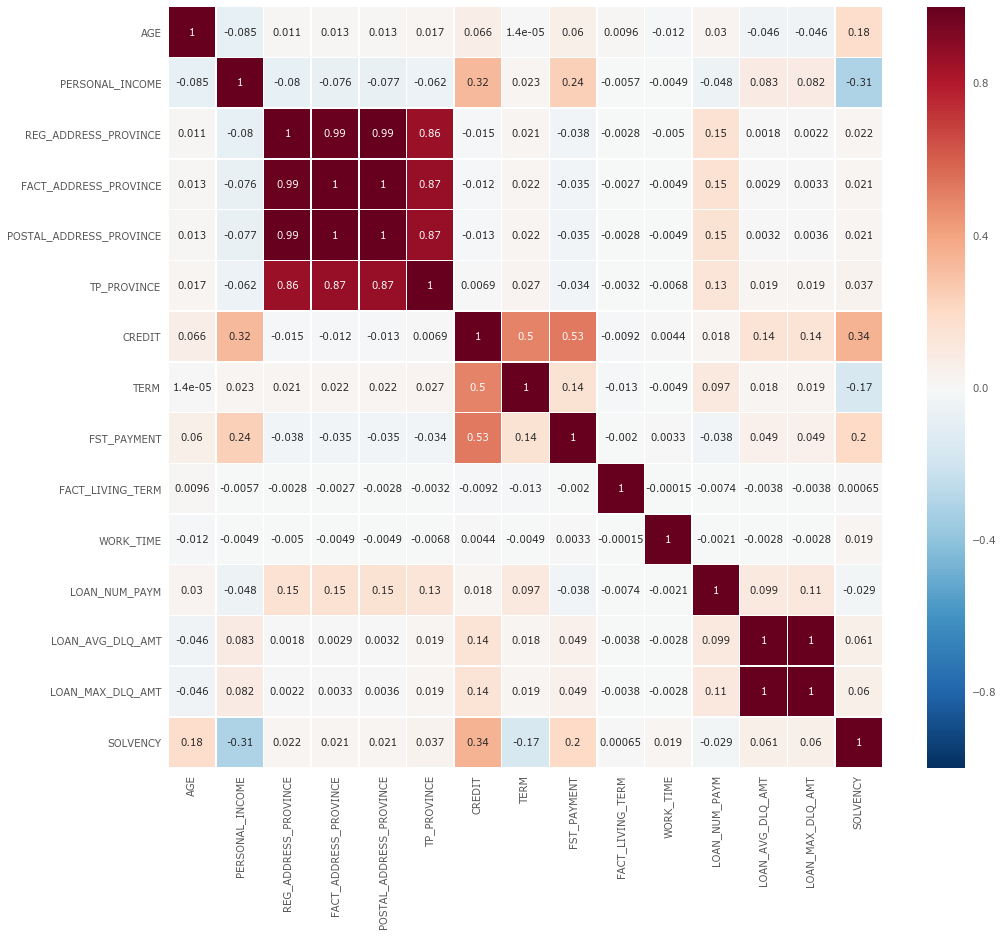

In [43]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(train_data.corr(), center=0, annot=True, linewidths=.5)

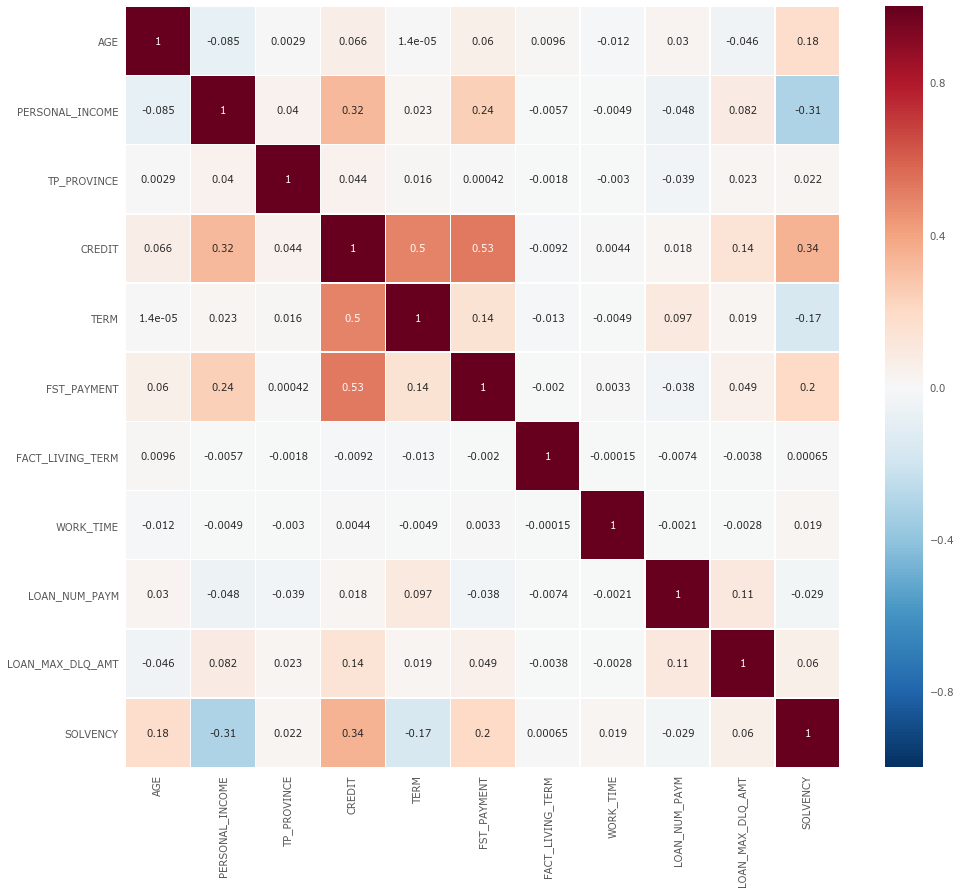

In [44]:
to_drop = ['FACT_ADDRESS_PROVINCE', 'LOAN_AVG_DLQ_AMT', 'REG_ADDRESS_PROVINCE']
tmp_data = train_data.drop(to_drop, axis=1)
tmp_data['TP_PROVINCE'] = tmp_data['TP_PROVINCE']/tmp_data['POSTAL_ADDRESS_PROVINCE']
tmp_data = tmp_data.drop('POSTAL_ADDRESS_PROVINCE', axis=1)
fig, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(tmp_data.corr(), center=0, annot=True, linewidths=.5)

In [45]:
to_drop = ['FACT_ADDRESS_PROVINCE', 'LOAN_AVG_DLQ_AMT', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE']
tmp_data = train_data.drop(to_drop, axis=1)
tmp_data['TP_PROVINCE'] = tmp_data['TP_PROVINCE']/tmp_data['REG_ADDRESS_PROVINCE']

In [46]:
tmp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10656 entries, 5558 to 1515
Data columns (total 48 columns):
TARGET                        10656 non-null object
AGE                           10656 non-null int64
SOCSTATUS_WORK_FL             10656 non-null object
SOCSTATUS_PENS_FL             10656 non-null object
GENDER                        10656 non-null object
CHILD_TOTAL                   10656 non-null object
DEPENDANTS                    10656 non-null object
EDUCATION                     10656 non-null object
MARITAL_STATUS                10656 non-null object
GEN_INDUSTRY                  10656 non-null object
GEN_TITLE                     10656 non-null object
ORG_TP_STATE                  10656 non-null object
ORG_TP_FCAPITAL               10656 non-null object
JOB_DIR                       10656 non-null object
FAMILY_INCOME                 10656 non-null object
PERSONAL_INCOME               10656 non-null float64
REG_ADDRESS_PROVINCE          10656 non-null int64
TP_PRO

In [47]:
tmp_cats, tmp_nums = columns(tmp_data)

In [48]:
tmp_nums

['AGE',
 'PERSONAL_INCOME',
 'REG_ADDRESS_PROVINCE',
 'TP_PROVINCE',
 'CREDIT',
 'TERM',
 'FST_PAYMENT',
 'FACT_LIVING_TERM',
 'WORK_TIME',
 'LOAN_NUM_PAYM',
 'LOAN_MAX_DLQ_AMT',
 'SOLVENCY']

AGE


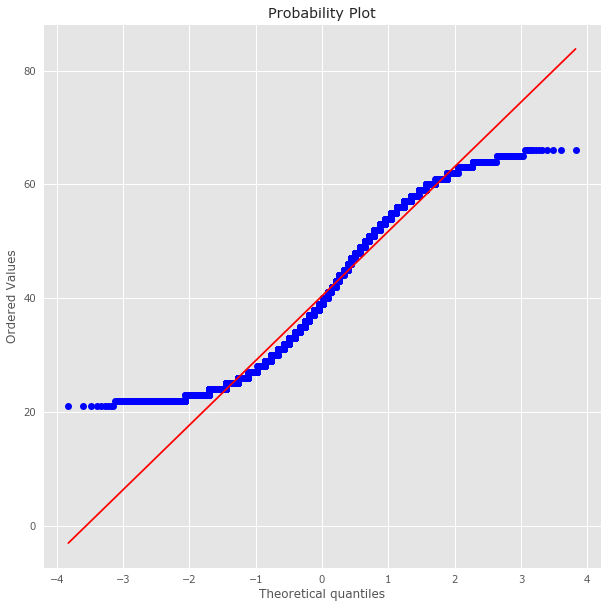

AGE ^1/3


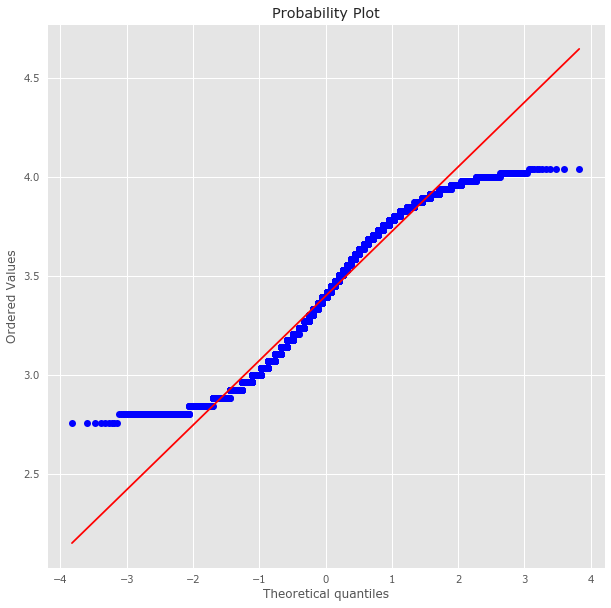


PERSONAL_INCOME


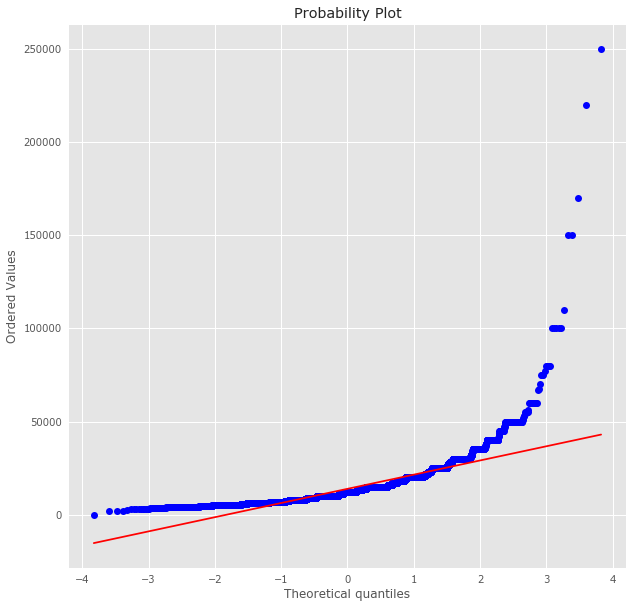

PERSONAL_INCOME ^1/3


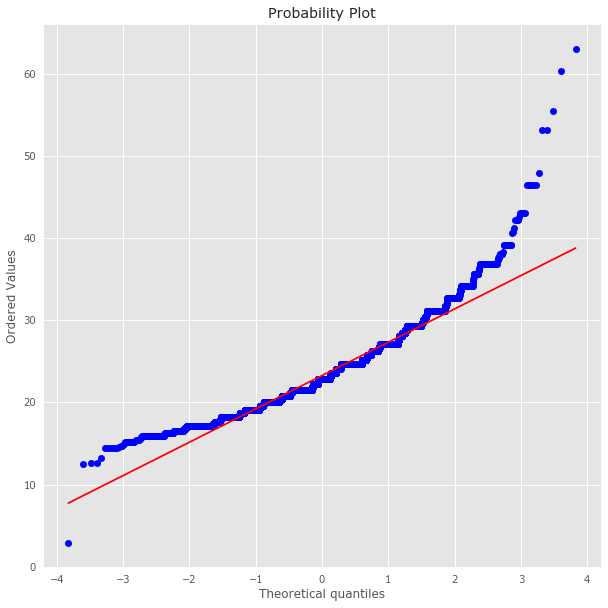


REG_ADDRESS_PROVINCE


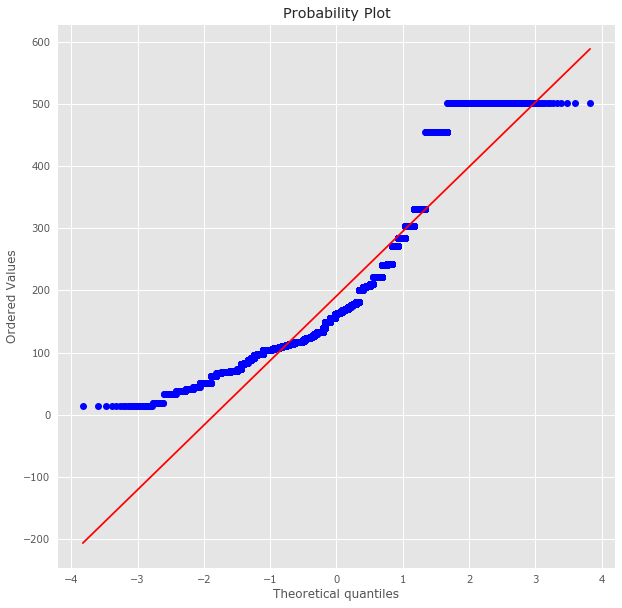

REG_ADDRESS_PROVINCE ^1/3


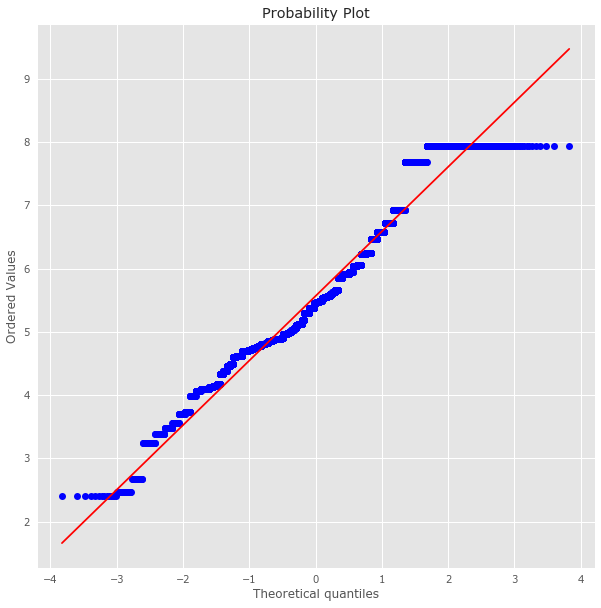


TP_PROVINCE


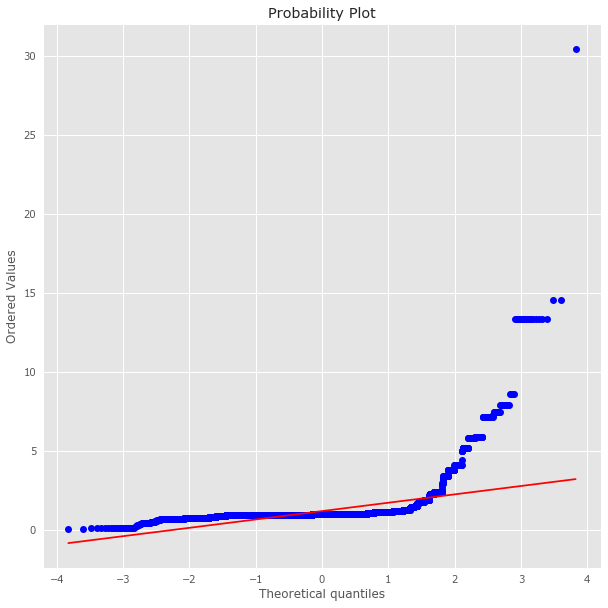

TP_PROVINCE ^1/3


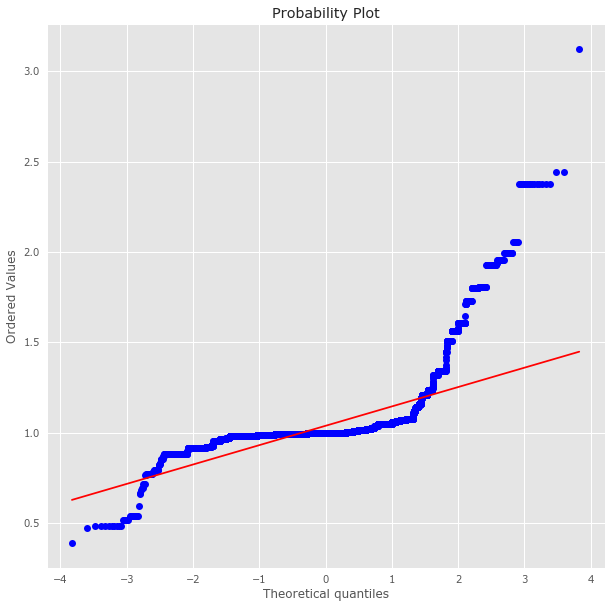


CREDIT


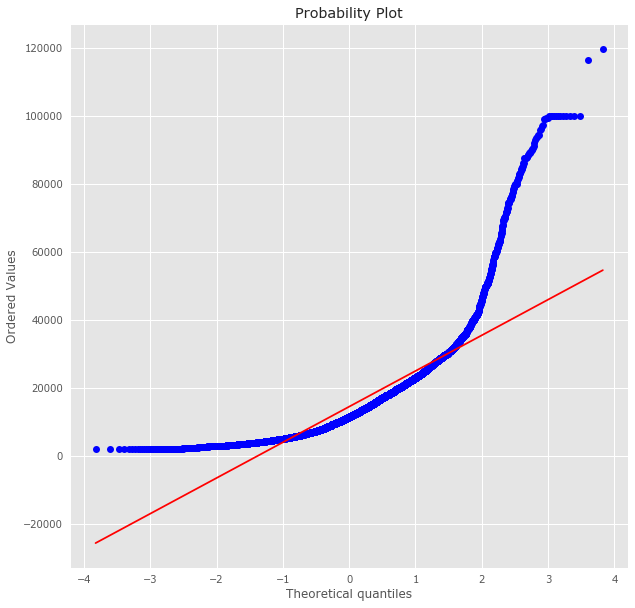

CREDIT ^1/3


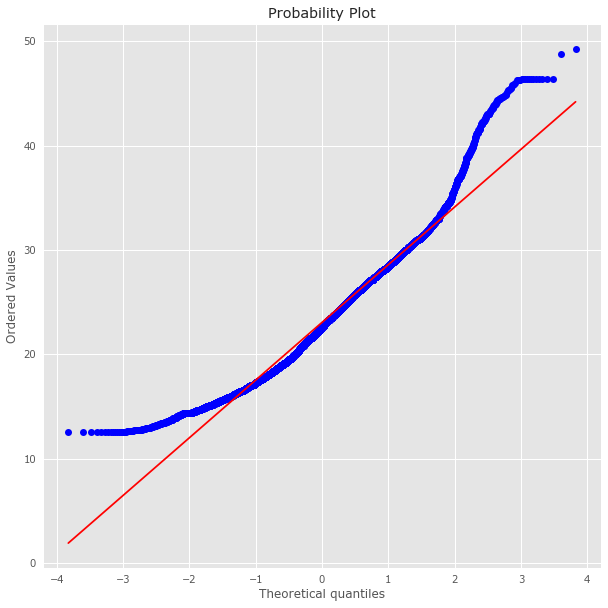


TERM


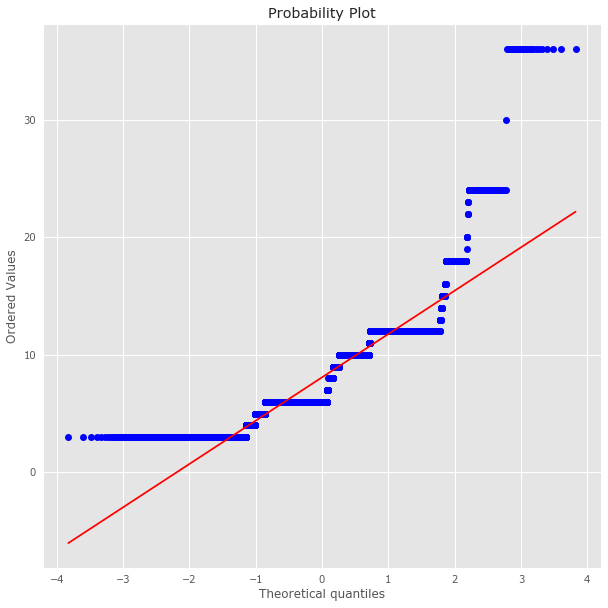

TERM ^1/3


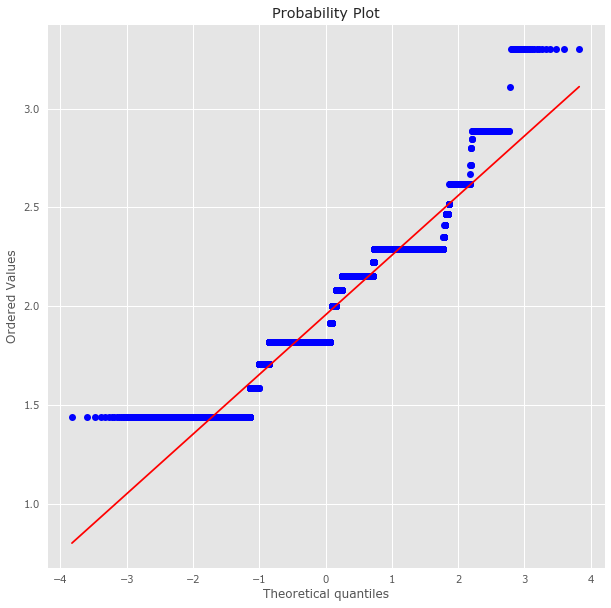


FST_PAYMENT


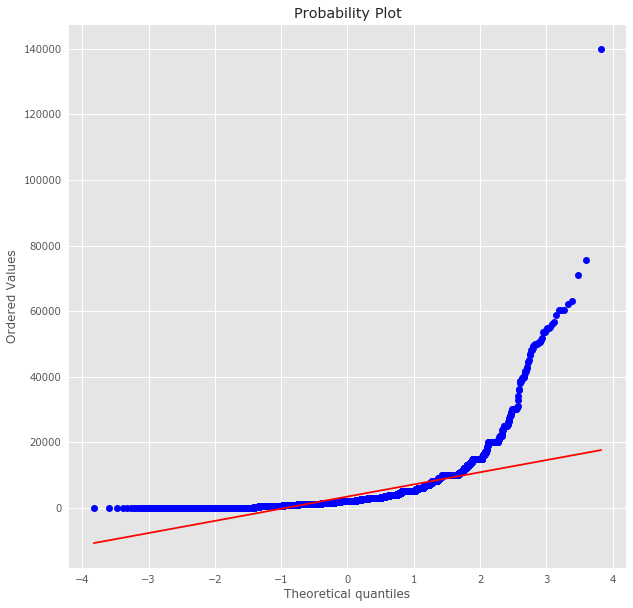

FST_PAYMENT ^1/3


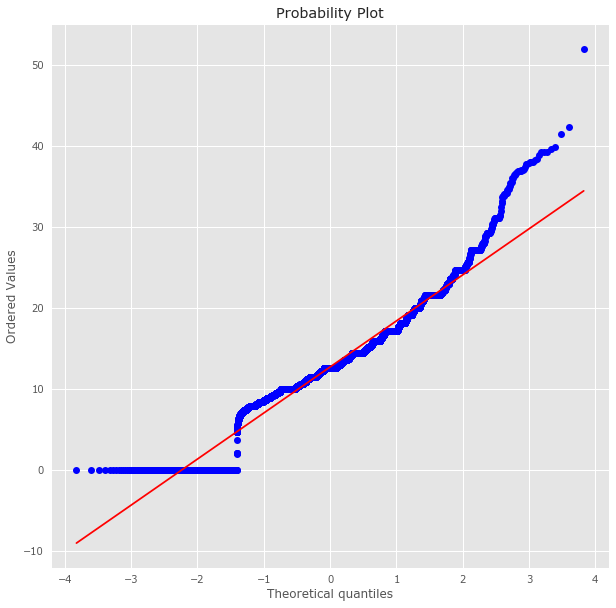


FACT_LIVING_TERM


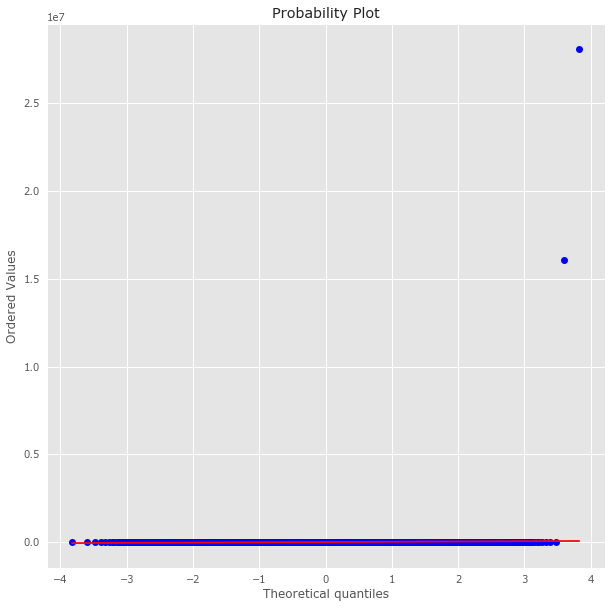

FACT_LIVING_TERM ^1/3


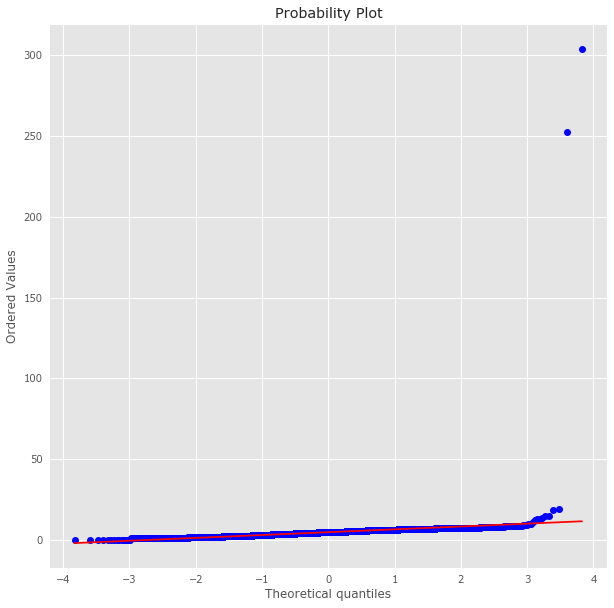


WORK_TIME


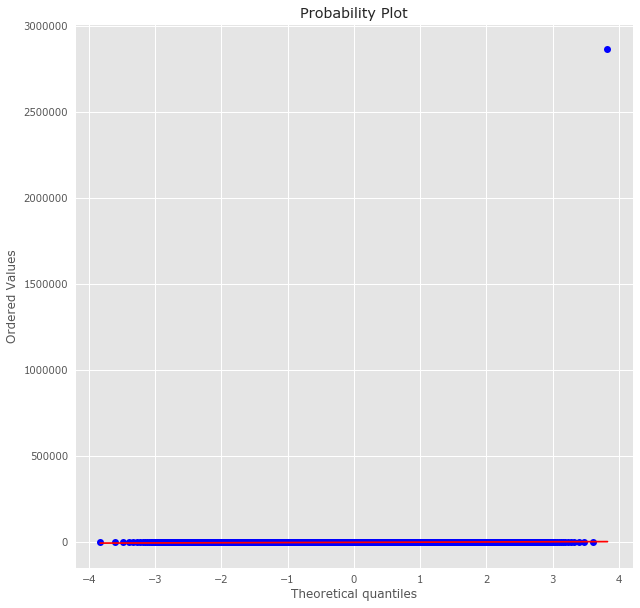

WORK_TIME ^1/3


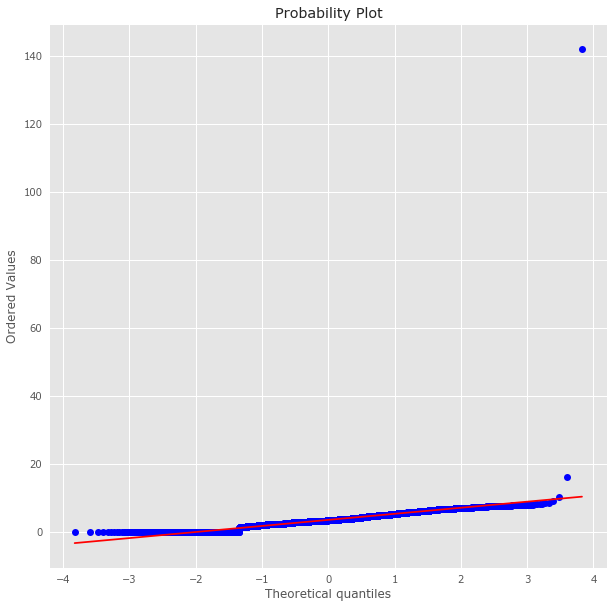


LOAN_NUM_PAYM


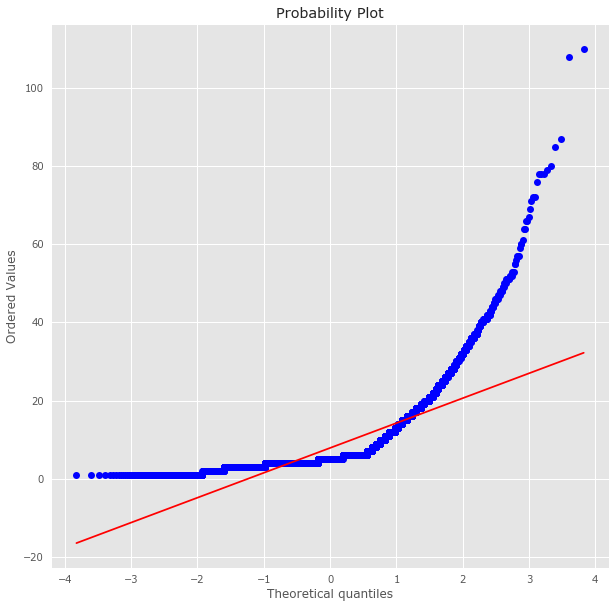

LOAN_NUM_PAYM ^1/3


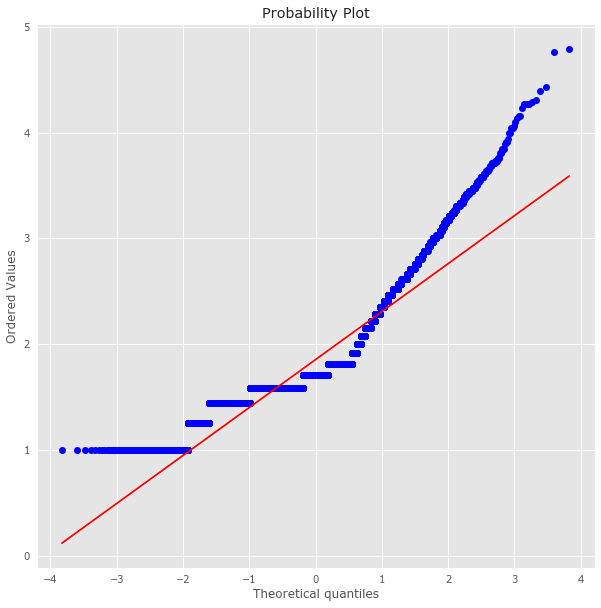


LOAN_MAX_DLQ_AMT


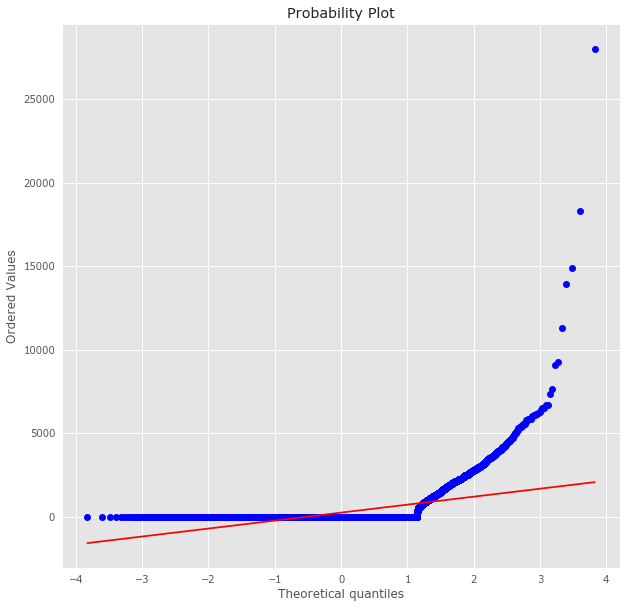

LOAN_MAX_DLQ_AMT ^1/3


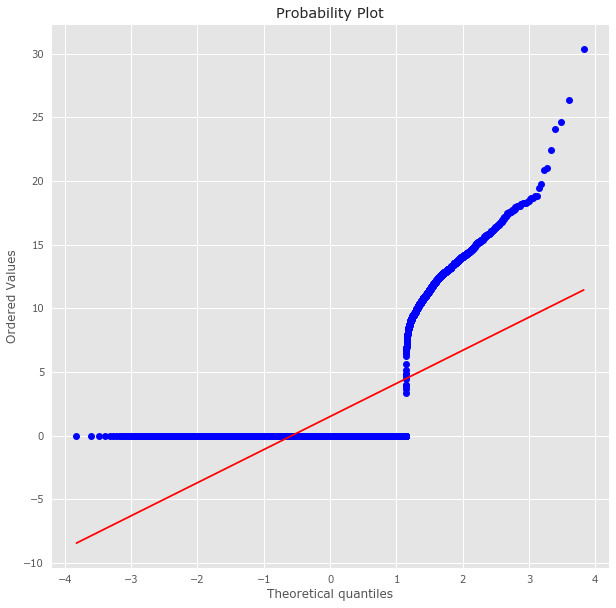


SOLVENCY


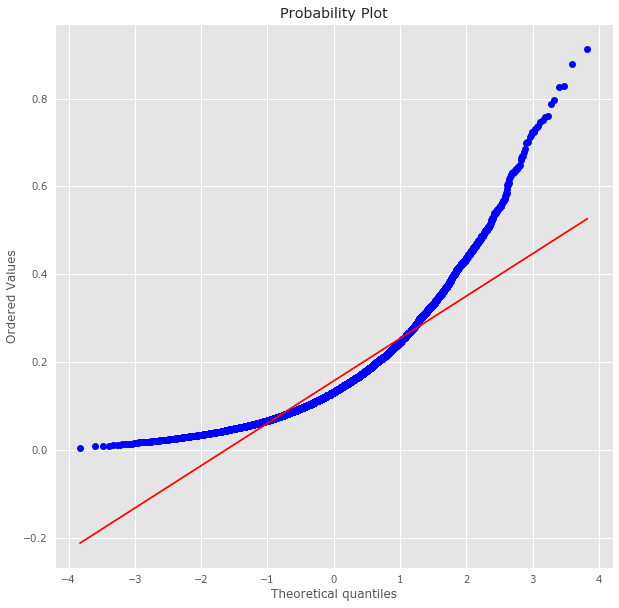

SOLVENCY ^1/3


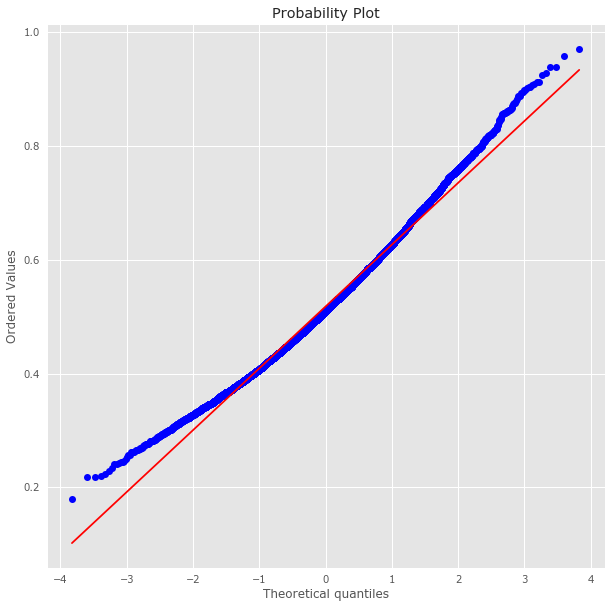

In [49]:
for col in tmp_nums:
    
    plt.subplots(figsize=(10, 10))
    print(col)

    stats.probplot(tmp_data[col], dist="norm", plot=plt)
    plt.show()
    
    plt.subplots(figsize=(10, 10))
    print(col, '^1/3')

    stats.probplot(tmp_data[col]**(1/3), dist="norm", plot=plt)
    plt.show()
    
    print()

In [190]:
def process_for_log_reg(train, test):
    
    def pre_proc(dataset):
    
        to_drop = ['FACT_ADDRESS_PROVINCE', 'LOAN_AVG_DLQ_AMT', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE']
        dataset = dataset.drop(to_drop, axis=1)
        dataset['TP_PROVINCE'] = dataset['TP_PROVINCE']/dataset['REG_ADDRESS_PROVINCE']


        dataset['PERSONAL_INCOME'] = dataset['PERSONAL_INCOME']**(1/3)
        dataset['REG_ADDRESS_PROVINCE'] = dataset['REG_ADDRESS_PROVINCE']**(1/3)

        dataset['CREDIT'] = dataset['CREDIT']**(1/3)
        dataset['TERM'] = dataset['TERM']**(1/3)

        dataset['FST_PAYMENT'] = dataset['FST_PAYMENT']**(1/3)
        dataset['FACT_LIVING_TERM'] = dataset['FACT_LIVING_TERM']**(1/3)

        dataset['WORK_TIME'] = dataset['WORK_TIME']**(1/3)
        dataset['LOAN_NUM_PAYM'] = dataset['LOAN_NUM_PAYM']**(1/3)

        dataset['TP_PROVINCE'] = dataset['TP_PROVINCE']**(1/3)
        dataset['SOLVENCY'] = dataset['SOLVENCY']**(1/3)


        dataset['PERSONAL_INCOME'][dataset['PERSONAL_INCOME'] == np.inf] = 1
        dataset['REG_ADDRESS_PROVINCE'][dataset['REG_ADDRESS_PROVINCE'] == np.inf] = 1

        dataset['CREDIT'][dataset['CREDIT'] == np.inf] = 1
        dataset['TERM'][dataset['TERM'] == np.inf] = 1

        dataset['FST_PAYMENT'][dataset['FST_PAYMENT'] == np.inf] = 1
        dataset['FACT_LIVING_TERM'][dataset['FACT_LIVING_TERM'] == np.inf] = 1

        dataset['WORK_TIME'][dataset['WORK_TIME'] == np.inf] = 1
        dataset['LOAN_NUM_PAYM'][dataset['LOAN_NUM_PAYM'] == np.inf] = 1

        dataset['TP_PROVINCE'][dataset['TP_PROVINCE'] == np.inf] = 1
        dataset['SOLVENCY'][dataset['SOLVENCY'] == np.inf] = 1

        dataset.drop('LOAN_MAX_DLQ_AMT', axis=1, inplace=True)
    
        return dataset
    
    train = pre_proc(train)
    test = pre_proc(test)
    
    cats, nums = columns(train)
    
    for i in nums:
        
        scaler = MinMaxScaler()
        scaler = scaler.fit(train.loc[:, i])
        train[i] = scaler.transform(train.loc[:, i])
        test[i] = scaler.transform(test.loc[:, i])
        
    train_dummy = pd.get_dummies(train)
    test_dummy = pd.get_dummies(test)
    
    return train_dummy, test_dummy, cats, nums

In [191]:
log_reg = LogisticRegression(n_jobs=-1)

In [192]:
logreg_train, logreg_test, cats_log, nums_log = process_for_log_reg(train_data, test_data)

In [196]:
logreg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Columns: 171 entries, AGE to DELAY_1
dtypes: float64(11), uint8(160)
memory usage: 2.5 MB


In [122]:
Xtrain_lg, Xtest_lg, ytrain_lg, ytest_lg = train_test_split(logreg_train.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                            logreg_train.loc[:, 'TARGET_1'], test_size=0.3)

In [123]:
Xtrain_lg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7459 entries, 7454 to 10143
Columns: 169 entries, AGE to DELAY_1
dtypes: float64(11), uint8(158)
memory usage: 1.8 MB


In [124]:
Xtest_lg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 9773 to 4366
Columns: 169 entries, AGE to DELAY_1
dtypes: float64(11), uint8(158)
memory usage: 793.0 KB


In [125]:
logreg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Columns: 171 entries, AGE to DELAY_1
dtypes: float64(11), uint8(160)
memory usage: 2.5 MB


In [126]:
log_reg.fit(Xtrain_lg, ytrain_lg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [138]:
X_log = logreg_test.drop(['TARGET_0', 'TARGET_1'], axis=1)
y_log = logreg_test.loc[:, 'TARGET_1']

In [139]:
roc_auc_score(y_log, log_reg.predict_proba(X_log)[:, 1])

0.68968881261428427

## H2O

### Случайный лес

In [140]:
import h2o
import os
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 days 3 hours 29 mins
H2O cluster version:,3.10.4.8
H2O cluster version age:,5 months and 3 days !!!
H2O cluster name:,H2O_from_python_boriszubarev_yt4nc8
H2O cluster total nodes:,1
H2O cluster free memory:,12.02 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [141]:
Xtr, Xts, ytr, yts = train_test_split(train_data.drop('TARGET', axis=1), 
                                      train_data.loc[:, 'TARGET'], test_size=0.3)

In [142]:
training = h2o.H2OFrame(train_data)
validation = h2o.H2OFrame(test_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [143]:
cats, nums = columns(train_data)

In [144]:
for i in cats:
    
    training[i] = training[i].asfactor()
    validation[i] = validation[i].asfactor()

In [146]:
X_col = list(Xtr.columns)
y_col = 'TARGET'

In [147]:
from h2o.estimators import H2ORandomForestEstimator

In [151]:
rf = H2ORandomForestEstimator(model_id='RF_OTP', ntrees=500, max_depth=9, score_tree_interval=100, seed=42)

In [152]:
rf.train(X_col, y_col, training_frame=training, validation_frame=validation)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [153]:
rf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  RF_OTP


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1011382683310693
RMSE: 0.3180224336915075
LogLoss: 0.3462141436305276
Mean Per-Class Error: 0.36829003451289954
AUC: 0.6815218816989518
Gini: 0.36304376339790356
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14111974257508814: 


,0,1,Error,Rate
0,6956.0,2422.0,0.2583,(2422.0/9378.0)
1,633.0,645.0,0.4953,(633.0/1278.0)
Total,7589.0,3067.0,0.2867,(3055.0/10656.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1411197,0.2968930,202.0
max f2,0.1063248,0.4554029,264.0
max f0point5,0.1722120,0.2561072,156.0
max accuracy,0.6204302,0.8801614,0.0
max precision,0.6204302,1.0,0.0
max recall,0.0094209,1.0,397.0
max specificity,0.6204302,1.0,0.0
max absolute_mcc,0.1506052,0.1773894,186.0
max min_per_class_accuracy,0.1250644,0.6274259,231.0
max mean_per_class_accuracy,0.1207794,0.6317100,239.0


Gains/Lift Table: Avg response rate: 11,99 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100413,0.4510008,8.3380282,8.3380282,1.0,1.0,0.0837246,0.0837246,733.8028169,733.8028169
,2,0.0200826,0.3663052,8.3380282,8.3380282,1.0,1.0,0.0837246,0.1674491,733.8028169,733.8028169
,3,0.0300300,0.3192558,8.1807069,8.2859155,0.9811321,0.99375,0.0813772,0.2488263,718.0706883,728.5915493
,4,0.0400713,0.2699162,8.0263262,8.2208662,0.9626168,0.9859485,0.0805947,0.3294210,702.6326181,722.0866181
,5,0.0500188,0.2426513,6.2141908,7.8217900,0.7452830,0.9380863,0.0618153,0.3912363,521.4190805,682.1790027
,6,0.1000375,0.1882905,3.6762413,5.7490157,0.4409006,0.6894934,0.1838811,0.5751174,267.6241313,474.9015670
,7,0.1500563,0.1660716,2.6124779,4.7035031,0.3133208,0.5641026,0.1306729,0.7057903,161.2477869,370.3503070
,8,0.2000751,0.1521881,1.4548529,3.8913405,0.1744841,0.4666979,0.0727700,0.7785603,45.4852945,289.1340539
,9,0.3000188,0.1331082,1.0569331,2.9471291,0.1267606,0.3534564,0.1056338,0.8841941,5.6933148,194.7129131
,10,0.4000563,0.1194536,0.5084164,2.3373079,0.0609756,0.2803190,0.0508607,0.9350548,-49.1583648,133.7307920




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.09949246386191046
RMSE: 0.315424260103611
LogLoss: 0.3419381968345757
Mean Per-Class Error: 0.3578074518183785
AUC: 0.6808014591232816
Gini: 0.3616029182465632
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13493324934519252: 


,0,1,Error,Rate
0,2822.0,1211.0,0.3003,(1211.0/4033.0)
1,230.0,304.0,0.4307,(230.0/534.0)
Total,3052.0,1515.0,0.3155,(1441.0/4567.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1349332,0.2967301,201.0
max f2,0.1069319,0.4491399,258.0
max f0point5,0.1739606,0.2526848,138.0
max accuracy,0.5540516,0.8828553,0.0
max precision,0.3656583,0.3181818,14.0
max recall,0.0206087,1.0,385.0
max specificity,0.5540516,0.9997520,0.0
max absolute_mcc,0.1349332,0.1835962,201.0
max min_per_class_accuracy,0.1265838,0.6315398,218.0
max mean_per_class_accuracy,0.1193439,0.6421925,233.0


Gains/Lift Table: Avg response rate: 11,69 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100723,0.3243671,2.4169923,2.4169923,0.2826087,0.2826087,0.0243446,0.0243446,141.6992347,141.6992347
,2,0.0201445,0.2918967,1.4873799,1.9521861,0.1739130,0.2282609,0.0149813,0.0393258,48.7379906,95.2186126
,3,0.0299978,0.2680055,2.4707033,2.1225020,0.2888889,0.2481752,0.0243446,0.0636704,147.0703288,112.2501982
,4,0.0400701,0.2500314,2.7888373,2.2899961,0.3260870,0.2677596,0.0280899,0.0917603,178.8837323,128.9996111
,5,0.0501423,0.2348526,1.6733024,2.1661188,0.1956522,0.2532751,0.0168539,0.1086142,67.3302394,116.6118771
,6,0.1000657,0.1931923,1.9880659,2.0772871,0.2324561,0.2428884,0.0992509,0.2078652,98.8065904,107.7287144
,7,0.1499891,0.1715208,1.9130445,2.0226195,0.2236842,0.2364964,0.0955056,0.3033708,91.3044550,102.2619536
,8,0.2001314,0.1579752,1.4191813,1.8714299,0.1659389,0.2188184,0.0711610,0.3745318,41.9181264,87.1429859
,9,0.2999781,0.1395636,1.3691397,1.7042442,0.1600877,0.1992701,0.1367041,0.5112360,36.9139727,70.4244238
,10,0.4000438,0.1260772,1.2164294,1.5822238,0.1422319,0.1850027,0.1217228,0.6329588,21.6429409,58.2223780



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-10-24 21:21:33,0.043 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2017-10-24 21:21:33,0.955 sec,100.0,0.3186593,0.3476830,0.6698994,8.3380282,0.3354917,0.3158154,0.3431055,0.6733410,2.2310699,0.3227502
,2017-10-24 21:21:35,2.421 sec,200.0,0.3182018,0.3465642,0.6773451,8.3380282,0.2789977,0.3154837,0.3421176,0.6794718,2.2310699,0.3201226
,2017-10-24 21:21:37,4.520 sec,300.0,0.3181222,0.3462092,0.6800041,8.3380282,0.2930743,0.3154475,0.3420608,0.6804825,2.4169923,0.3185899
,2017-10-24 21:21:40,7.443 sec,400.0,0.3180164,0.3461402,0.6809581,8.3380282,0.2687688,0.3154127,0.3419413,0.6807824,2.0451474,0.3192468
,2017-10-24 21:21:45,12.399 sec,500.0,0.3180224,0.3462141,0.6815219,8.3380282,0.2866929,0.3154243,0.3419382,0.6808015,2.4169923,0.3155244


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
GEN_INDUSTRY,9187.2285156,1.0,0.1217510
REGION_NM,6020.7514648,0.6553393,0.0797882
GEN_TITLE,4478.0112305,0.4874170,0.0593435
AGE,3903.0026855,0.4248292,0.0517234
SOLVENCY,3309.2963867,0.3602062,0.0438555
---,---,---,---
AUTO_RUS_FL,241.5337372,0.0262902,0.0032009
SOCSTATUS_WORK_FL,211.8247681,0.0230564,0.0028071
FACT_POST_FL,197.4897614,0.0214961,0.0026172
GAR_PRESENCE_FL,118.1491318,0.0128601,0.0015657



See the whole table with table.as_data_frame()


### Логистическая регрессия

In [176]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [177]:
glm = H2OGeneralizedLinearEstimator(model_id='LogReg_OTP', seed=42)

In [178]:
training_log = h2o.H2OFrame(logreg_train)
validation_log = h2o.H2OFrame(logreg_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [197]:
logreg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Columns: 171 entries, AGE to DELAY_1
dtypes: float64(11), uint8(160)
memory usage: 2.5 MB


In [202]:
categorical_columns = [col for col in logreg_train.columns if logreg_train[col].dtype.name == 'uint8']
numerical_columns = [col for col in logreg_train.columns if logreg_train[col].dtype.name != 'uint8']

In [203]:
for i in categorical_columns:
    
    training_log[i] = training_log[i].asfactor()
    validation_log[i] = validation_log[i].asfactor()

In [204]:
X_log_col = list(Xtrain_lg.columns)
y_log_col = 'TARGET_1'

In [209]:
training_log.describe()

Rows:10657
Cols:171




,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,SOLVENCY,TARGET_0,TARGET_1,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,DEPENDANTS_2,DEPENDANTS_3,DEPENDANTS_4,EDUCATION_Высшее,EDUCATION_Неоконченное высшее,EDUCATION_Неполное среднее,EDUCATION_Среднее,EDUCATION_Среднее специальное,MARITAL_STATUS_Вдовец/Вдова,MARITAL_STATUS_Гражданский брак,MARITAL_STATUS_Не состоял в браке,MARITAL_STATUS_Разведен(а),MARITAL_STATUS_Состою в браке,GEN_INDUSTRY_nan,GEN_INDUSTRY_Банк/Финансы,GEN_INDUSTRY_Государственная служба,GEN_INDUSTRY_Другие сферы,GEN_INDUSTRY_Здравоохранение,GEN_INDUSTRY_Информационные технологии,GEN_INDUSTRY_Информационные услуги,GEN_INDUSTRY_Коммунальное хоз-во/Дорожные службы,GEN_INDUSTRY_Металлургия/Промышленность/Машиностроение,GEN_INDUSTRY_Наука,GEN_INDUSTRY_Нефтегазовая промышленность,GEN_INDUSTRY_Образование,GEN_INDUSTRY_Развлечения/Искусство,GEN_INDUSTRY_Ресторанный бизнес/Общественное питание,GEN_INDUSTRY_СМИ/Реклама/PR-агенства,GEN_INDUSTRY_Салоны красоты и здоровья,GEN_INDUSTRY_Сборочные производства,GEN_INDUSTRY_Сельское хозяйство,GEN_INDUSTRY_Страхование,GEN_INDUSTRY_Строительство,GEN_INDUSTRY_Торговля,GEN_INDUSTRY_Транспорт,GEN_INDUSTRY_Химия/Парфюмерия/Фармацевтика,GEN_INDUSTRY_ЧОП/Детективная д-ть,GEN_INDUSTRY_Энергетика,GEN_INDUSTRY_Юридические услуги/нотариальные услуги,GEN_TITLE_nan,GEN_TITLE_Военнослужащий по контракту,GEN_TITLE_Высококвалифиц. специалист,GEN_TITLE_Другое,GEN_TITLE_Индивидуальный предприниматель,GEN_TITLE_Партнер,GEN_TITLE_Работник сферы услуг,GEN_TITLE_Рабочий,GEN_TITLE_Руководитель высшего звена,GEN_TITLE_Руководитель низшего звена,GEN_TITLE_Руководитель среднего звена,GEN_TITLE_Служащий,GEN_TITLE_Специалист,ORG_TP_STATE_nan,ORG_TP_STATE_Государственная комп./учреж.,ORG_TP_STATE_Индивидуальный предприниматель,ORG_TP_STATE_Некоммерческая организация,ORG_TP_STATE_Частная компания,ORG_TP_FCAPITAL_nan,ORG_TP_FCAPITAL_Без участия,ORG_TP_FCAPITAL_С участием,JOB_DIR_nan,JOB_DIR_Адм-хоз. и трансп. службы,"JOB_DIR_Бухгалтерия, финансы, планир.",JOB_DIR_Вспомогательный техперсонал,JOB_DIR_Кадровая служба и секретариат,JOB_DIR_Пр-техн. обесп. и телеком.,JOB_DIR_Служба безопасности,JOB_DIR_Снабжение и сбыт,JOB_DIR_Участие в основ. деятельности,JOB_DIR_Юридическая служба,FAMILY_INCOME_до 5000 руб.,FAMILY_INCOME_от 10000 до 20000 руб.,FAMILY_INCOME_от 20000 до 50000 руб.,FAMILY_INCOME_от 5000 до 10000 руб.,FAMILY_INCOME_свыше 50000 руб.,REGION_NM_ВОСТОЧНО-СИБИРСКИЙ,REGION_NM_ДАЛЬНЕВОСТОЧНЫЙ,REGION_NM_ЗАПАДНО-СИБИРСКИЙ,REGION_NM_ПОВОЛЖСКИЙ,REGION_NM_ПРИВОЛЖСКИЙ,REGION_NM_СЕВЕРО-ЗАПАДНЫЙ,REGION_NM_УРАЛЬСКИЙ,REGION_NM_ЦЕНТРАЛЬНЫЙ 1,REGION_NM_ЦЕНТРАЛЬНЫЙ 2,REGION_NM_ЦЕНТРАЛЬНЫЙ ОФИС,REGION_NM_ЮЖНЫЙ,REG_FACT_FL_0,REG_FACT_FL_1,FACT_POST_FL_0,FACT_POST_FL_1,REG_POST_FL_0,REG_POST_FL_1,REG_FACT_POST_FL_0,REG_FACT_POST_FL_1,REG_FACT_POST_TP_FL_0,REG_FACT_POST_TP_FL_1,FL_PRESENCE_FL_0,FL_PRESENCE_FL_1,OWN_AUTO_0,OWN_AUTO_1,AUTO_RUS_FL_0,AUTO_RUS_FL_1,HS_PRESENCE_FL_0,HS_PRESENCE_FL_1,COT_PRESENCE_FL_0,COT_PRESENCE_FL_1,GAR_PRESENCE_FL_0,GAR_PRESENCE_FL_1,LAND_PRESENCE_FL_0,LAND_PRESENCE_FL_1,GPF_DOCUMENT_FL_0,GPF_DOCUMENT_FL_1,FACT_PHONE_FL_0,FACT_PHONE_FL_1,REG_PHONE_FL_0,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
type,real,real,real,real,real,real,real,real,real,real,real,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,e

In [207]:
glm.train(X_log_col, y_log_col, training_frame=training_log, validation_frame=validation_log)

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Name lookup of 'py_272_sid_9cb0' failed
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_393_sid_9cb0 (:= (tmp= py_392_sid_9cb0 (:= (tmp= py_391_sid_9cb0 (:= (tmp= py_390_sid_9cb0 (:= (tmp= py_389_sid_9cb0 (:= (tmp= py_388_sid_9cb0 (:= (tmp= py_387_sid_9cb0 (:= (tmp= py_386_sid_9cb0 (:= (tmp= py_385_sid_9cb0 (:= (tmp= py_384_sid_9cb0 (:= (tmp= py_383_sid_9cb0 (:= (tmp= py_382_sid_9cb0 (:= (tmp= py_381_sid_9cb0 (:= (tmp= py_380_sid_9cb0 (:= (tmp= py_379_sid_9cb0 (:= (tmp= py_378_sid_9cb0 (:= (tmp= py_377_sid_9cb0 (:= (tmp= py_376_sid_9cb0 (:= (tmp= py_375_sid_9cb0 (:= (tmp= py_374_sid_9cb0 (:= (tmp= py_373_sid_9cb0 (:= (tmp= py_372_sid_9cb0 (:= (tmp= py_371_sid_9cb0 (:= (tmp= py_370_sid_9cb0 (:= (tmp= py_369_sid_9cb0 (:= (tmp= py_368_sid_9cb0 (:= (tmp= py_367_sid_9cb0 (:= (tmp= py_366_sid_9cb0 (:= (tmp= py_365_sid_9cb0 (:= (tmp= py_364_sid_9cb0 (:= (tmp= py_363_sid_9cb0 (:= (tmp= py_362_sid_9cb0 (:= (tmp= py_361_sid_9cb0 (:= (tmp= py_360_sid_9cb0 (:= (tmp= py_359_sid_9cb0 (:= (tmp= py_358_sid_9cb0 (:= (tmp= py_357_sid_9cb0 (:= (tmp= py_356_sid_9cb0 (:= (tmp= py_355_sid_9cb0 (:= (tmp= py_354_sid_9cb0 (:= (tmp= py_353_sid_9cb0 (:= (tmp= py_352_sid_9cb0 (:= (tmp= py_351_sid_9cb0 (:= (tmp= py_350_sid_9cb0 (:= (tmp= py_349_sid_9cb0 (:= (tmp= py_348_sid_9cb0 (:= (tmp= py_347_sid_9cb0 (:= (tmp= py_346_sid_9cb0 (:= (tmp= py_345_sid_9cb0 (:= (tmp= py_344_sid_9cb0 (:= (tmp= py_343_sid_9cb0 (:= (tmp= py_342_sid_9cb0 (:= (tmp= py_341_sid_9cb0 (:= (tmp= py_340_sid_9cb0 (:= (tmp= py_339_sid_9cb0 (:= (tmp= py_338_sid_9cb0 (:= (tmp= py_337_sid_9cb0 (:= (tmp= py_336_sid_9cb0 (:= (tmp= py_335_sid_9cb0 (:= (tmp= py_334_sid_9cb0 (:= (tmp= py_333_sid_9cb0 (:= (tmp= py_332_sid_9cb0 (:= (tmp= py_331_sid_9cb0 (:= (tmp= py_330_sid_9cb0 (:= (tmp= py_329_sid_9cb0 (:= (tmp= py_328_sid_9cb0 (:= (tmp= py_327_sid_9cb0 (:= (tmp= py_326_sid_9cb0 (:= (tmp= py_325_sid_9cb0 (:= (tmp= py_324_sid_9cb0 (:= (tmp= py_323_sid_9cb0 (:= (tmp= py_322_sid_9cb0 (:= (tmp= py_321_sid_9cb0 (:= (tmp= py_320_sid_9cb0 (:= (tmp= py_319_sid_9cb0 (:= (tmp= py_318_sid_9cb0 (:= (tmp= py_317_sid_9cb0 (:= (tmp= py_316_sid_9cb0 (:= (tmp= py_315_sid_9cb0 (:= (tmp= py_314_sid_9cb0 (:= (tmp= py_313_sid_9cb0 (:= (tmp= py_312_sid_9cb0 (:= (tmp= py_311_sid_9cb0 (:= (tmp= py_310_sid_9cb0 (:= (tmp= py_309_sid_9cb0 (:= (tmp= py_308_sid_9cb0 (:= (tmp= py_307_sid_9cb0 (:= (tmp= py_306_sid_9cb0 (:= (tmp= py_305_sid_9cb0 (:= (tmp= py_304_sid_9cb0 (:= (tmp= py_303_sid_9cb0 (:= (tmp= py_302_sid_9cb0 (:= (tmp= py_301_sid_9cb0 (:= (tmp= py_300_sid_9cb0 (:= (tmp= py_299_sid_9cb0 (:= (tmp= py_298_sid_9cb0 (:= (tmp= py_297_sid_9cb0 (:= (tmp= py_296_sid_9cb0 (:= (tmp= py_295_sid_9cb0 (:= (tmp= py_294_sid_9cb0 (:= (tmp= py_293_sid_9cb0 (:= (tmp= py_292_sid_9cb0 (:= (tmp= py_291_sid_9cb0 (:= (tmp= py_290_sid_9cb0 (:= (tmp= py_289_sid_9cb0 (:= (tmp= py_288_sid_9cb0 (:= (tmp= py_287_sid_9cb0 (:= (tmp= py_286_sid_9cb0 (:= (tmp= py_285_sid_9cb0 (:= (tmp= py_284_sid_9cb0 (:= (tmp= py_283_sid_9cb0 (:= (tmp= py_282_sid_9cb0 (:= (tmp= py_281_sid_9cb0 (:= (tmp= py_280_sid_9cb0 (:= (tmp= py_279_sid_9cb0 (:= (tmp= py_278_sid_9cb0 (:= (tmp= py_277_sid_9cb0 (:= (tmp= py_276_sid_9cb0 (:= (tmp= py_275_sid_9cb0 (:= (tmp= py_274_sid_9cb0 (:= (tmp= py_273_sid_9cb0 (:= py_272_sid_9cb0 (as.factor (cols_py py_272_sid_9cb0 'GEN_INDUSTRY_Образование')) 50 [])) (as.factor (cols_py py_273_sid_9cb0 'GEN_INDUSTRY_Развлечения/Искусство')) 51 [])) (as.factor (cols_py py_274_sid_9cb0 'GEN_INDUSTRY_Ресторанный бизнес/Общественное питание')) 52 [])) (as.factor (cols_py py_275_sid_9cb0 'GEN_INDUSTRY_СМИ/Реклама/PR-агенства')) 53 [])) (as.factor (cols_py py_276_sid_9cb0 'GEN_INDUSTRY_Салоны красоты и здоровья')) 54 [])) (as.factor (cols_py py_277_sid_9cb0 'GEN_INDUSTRY_Сборочные производства')) 55 [])) (as.factor (cols_py py_278_sid_9cb0 'GEN_INDUSTRY_Сельское хозяйство')) 56 [])) (as.factor (cols_py py_279_sid_9cb0 'GEN_INDUSTRY_Страхование')) 57 [])) (as.factor (cols_py py_280_sid_9cb0 'GEN_INDUSTRY_Строительство')) 58 [])) (as.factor (cols_py py_281_sid_9cb0 'GEN_INDUSTRY_Торговля')) 59 [])) (as.factor (cols_py py_282_sid_9cb0 'GEN_INDUSTRY_Транспорт')) 60 [])) (as.factor (cols_py py_283_sid_9cb0 'GEN_INDUSTRY_Химия/Парфюмерия/Фармацевтика')) 61 [])) (as.factor (cols_py py_284_sid_9cb0 'GEN_INDUSTRY_ЧОП/Детективная д-ть')) 62 [])) (as.factor (cols_py py_285_sid_9cb0 'GEN_INDUSTRY_Энергетика')) 63 [])) (as.factor (cols_py py_286_sid_9cb0 'GEN_INDUSTRY_Юридические услуги/нотариальные услуги')) 64 [])) (as.factor (cols_py py_287_sid_9cb0 'GEN_TITLE_nan')) 65 [])) (as.factor (cols_py py_288_sid_9cb0 'GEN_TITLE_Военнослужащий по контракту')) 66 [])) (as.factor (cols_py py_289_sid_9cb0 'GEN_TITLE_Высококвалифиц. специалист')) 67 [])) (as.factor (cols_py py_290_sid_9cb0 'GEN_TITLE_Другое')) 68 [])) (as.factor (cols_py py_291_sid_9cb0 'GEN_TITLE_Индивидуальный предприниматель')) 69 [])) (as.factor (cols_py py_292_sid_9cb0 'GEN_TITLE_Партнер')) 70 [])) (as.factor (cols_py py_293_sid_9cb0 'GEN_TITLE_Работник сферы услуг')) 71 [])) (as.factor (cols_py py_294_sid_9cb0 'GEN_TITLE_Рабочий')) 72 [])) (as.factor (cols_py py_295_sid_9cb0 'GEN_TITLE_Руководитель высшего звена')) 73 [])) (as.factor (cols_py py_296_sid_9cb0 'GEN_TITLE_Руководитель низшего звена')) 74 [])) (as.factor (cols_py py_297_sid_9cb0 'GEN_TITLE_Руководитель среднего звена')) 75 [])) (as.factor (cols_py py_298_sid_9cb0 'GEN_TITLE_Служащий')) 76 [])) (as.factor (cols_py py_299_sid_9cb0 'GEN_TITLE_Специалист')) 77 [])) (as.factor (cols_py py_300_sid_9cb0 'ORG_TP_STATE_nan')) 78 [])) (as.factor (cols_py py_301_sid_9cb0 'ORG_TP_STATE_Государственная комп./учреж.')) 79 [])) (as.factor (cols_py py_302_sid_9cb0 'ORG_TP_STATE_Индивидуальный предприниматель')) 80 [])) (as.factor (cols_py py_303_sid_9cb0 'ORG_TP_STATE_Некоммерческая организация')) 81 [])) (as.factor (cols_py py_304_sid_9cb0 'ORG_TP_STATE_Частная компания')) 82 [])) (as.factor (cols_py py_305_sid_9cb0 'ORG_TP_FCAPITAL_nan')) 83 [])) (as.factor (cols_py py_306_sid_9cb0 'ORG_TP_FCAPITAL_Без участия')) 84 [])) (as.factor (cols_py py_307_sid_9cb0 'ORG_TP_FCAPITAL_С участием')) 85 [])) (as.factor (cols_py py_308_sid_9cb0 'JOB_DIR_nan')) 86 [])) (as.factor (cols_py py_309_sid_9cb0 'JOB_DIR_Адм-хоз. и трансп. службы')) 87 [])) (as.factor (cols_py py_310_sid_9cb0 'JOB_DIR_Бухгалтерия, финансы, планир.')) 88 [])) (as.factor (cols_py py_311_sid_9cb0 'JOB_DIR_Вспомогательный техперсонал')) 89 [])) (as.factor (cols_py py_312_sid_9cb0 'JOB_DIR_Кадровая служба и секретариат')) 90 [])) (as.factor (cols_py py_313_sid_9cb0 'JOB_DIR_Пр-техн. обесп. и телеком.')) 91 [])) (as.factor (cols_py py_314_sid_9cb0 'JOB_DIR_Служба безопасности')) 92 [])) (as.factor (cols_py py_315_sid_9cb0 'JOB_DIR_Снабжение и сбыт')) 93 [])) (as.factor (cols_py py_316_sid_9cb0 'JOB_DIR_Участие в основ. деятельности')) 94 [])) (as.factor (cols_py py_317_sid_9cb0 'JOB_DIR_Юридическая служба')) 95 [])) (as.factor (cols_py py_318_sid_9cb0 'FAMILY_INCOME_до 5000 руб.')) 96 [])) (as.factor (cols_py py_319_sid_9cb0 'FAMILY_INCOME_от 10000 до 20000 руб.')) 97 [])) (as.factor (cols_py py_320_sid_9cb0 'FAMILY_INCOME_от 20000 до 50000 руб.')) 98 [])) (as.factor (cols_py py_321_sid_9cb0 'FAMILY_INCOME_от 5000 до 10000 руб.')) 99 [])) (as.factor (cols_py py_322_sid_9cb0 'FAMILY_INCOME_свыше 50000 руб.')) 100 [])) (as.factor (cols_py py_323_sid_9cb0 'REGION_NM_ВОСТОЧНО-СИБИРСКИЙ')) 101 [])) (as.factor (cols_py py_324_sid_9cb0 'REGION_NM_ДАЛЬНЕВОСТОЧНЫЙ')) 102 [])) (as.factor (cols_py py_325_sid_9cb0 'REGION_NM_ЗАПАДНО-СИБИРСКИЙ')) 103 [])) (as.factor (cols_py py_326_sid_9cb0 'REGION_NM_ПОВОЛЖСКИЙ')) 104 [])) (as.factor (cols_py py_327_sid_9cb0 'REGION_NM_ПРИВОЛЖСКИЙ')) 105 [])) (as.factor (cols_py py_328_sid_9cb0 'REGION_NM_СЕВЕРО-ЗАПАДНЫЙ')) 106 [])) (as.factor (cols_py py_329_sid_9cb0 'REGION_NM_УРАЛЬСКИЙ')) 107 [])) (as.factor (cols_py py_330_sid_9cb0 'REGION_NM_ЦЕНТРАЛЬНЫЙ 1')) 108 [])) (as.factor (cols_py py_331_sid_9cb0 'REGION_NM_ЦЕНТРАЛЬНЫЙ 2')) 109 [])) (as.factor (cols_py py_332_sid_9cb0 'REGION_NM_ЦЕНТРАЛЬНЫЙ ОФИС')) 110 [])) (as.factor (cols_py py_333_sid_9cb0 'REGION_NM_ЮЖНЫЙ')) 111 [])) (as.factor (cols_py py_334_sid_9cb0 'REG_FACT_FL_0')) 112 [])) (as.factor (cols_py py_335_sid_9cb0 'REG_FACT_FL_1')) 113 [])) (as.factor (cols_py py_336_sid_9cb0 'FACT_POST_FL_0')) 114 [])) (as.factor (cols_py py_337_sid_9cb0 'FACT_POST_FL_1')) 115 [])) (as.factor (cols_py py_338_sid_9cb0 'REG_POST_FL_0')) 116 [])) (as.factor (cols_py py_339_sid_9cb0 'REG_POST_FL_1')) 117 [])) (as.factor (cols_py py_340_sid_9cb0 'REG_FACT_POST_FL_0')) 118 [])) (as.factor (cols_py py_341_sid_9cb0 'REG_FACT_POST_FL_1')) 119 [])) (as.factor (cols_py py_342_sid_9cb0 'REG_FACT_POST_TP_FL_0')) 120 [])) (as.factor (cols_py py_343_sid_9cb0 'REG_FACT_POST_TP_FL_1')) 121 [])) (as.factor (cols_py py_344_sid_9cb0 'FL_PRESENCE_FL_0')) 122 [])) (as.factor (cols_py py_345_sid_9cb0 'FL_PRESENCE_FL_1')) 123 [])) (as.factor (cols_py py_346_sid_9cb0 'OWN_AUTO_0')) 124 [])) (as.factor (cols_py py_347_sid_9cb0 'OWN_AUTO_1')) 125 [])) (as.factor (cols_py py_348_sid_9cb0 'AUTO_RUS_FL_0')) 126 [])) (as.factor (cols_py py_349_sid_9cb0 'AUTO_RUS_FL_1')) 127 [])) (as.factor (cols_py py_350_sid_9cb0 'HS_PRESENCE_FL_0')) 128 [])) (as.factor (cols_py py_351_sid_9cb0 'HS_PRESENCE_FL_1')) 129 [])) (as.factor (cols_py py_352_sid_9cb0 'COT_PRESENCE_FL_0')) 130 [])) (as.factor (cols_py py_353_sid_9cb0 'COT_PRESENCE_FL_1')) 131 [])) (as.factor (cols_py py_354_sid_9cb0 'GAR_PRESENCE_FL_0')) 132 [])) (as.factor (cols_py py_355_sid_9cb0 'GAR_PRESENCE_FL_1')) 133 [])) (as.factor (cols_py py_356_sid_9cb0 'LAND_PRESENCE_FL_0')) 134 [])) (as.factor (cols_py py_357_sid_9cb0 'LAND_PRESENCE_FL_1')) 135 [])) (as.factor (cols_py py_358_sid_9cb0 'GPF_DOCUMENT_FL_0')) 136 [])) (as.factor (cols_py py_359_sid_9cb0 'GPF_DOCUMENT_FL_1')) 137 [])) (as.factor (cols_py py_360_sid_9cb0 'FACT_PHONE_FL_0')) 138 [])) (as.factor (cols_py py_361_sid_9cb0 'FACT_PHONE_FL_1')) 139 [])) (as.factor (cols_py py_362_sid_9cb0 'REG_PHONE_FL_0')) 140 [])) (as.factor (cols_py py_363_sid_9cb0 'REG_PHONE_FL_1')) 141 [])) (as.factor (cols_py py_364_sid_9cb0 'GEN_PHONE_FL_0')) 142 [])) (as.factor (cols_py py_365_sid_9cb0 'GEN_PHONE_FL_1')) 143 [])) (as.factor (cols_py py_366_sid_9cb0 'LOAN_NUM_TOTAL_1')) 144 [])) (as.factor (cols_py py_367_sid_9cb0 'LOAN_NUM_TOTAL_2')) 145 [])) (as.factor (cols_py py_368_sid_9cb0 'LOAN_NUM_TOTAL_3')) 146 [])) (as.factor (cols_py py_369_sid_9cb0 'LOAN_NUM_TOTAL_4')) 147 [])) (as.factor (cols_py py_370_sid_9cb0 'LOAN_NUM_TOTAL_5')) 148 [])) (as.factor (cols_py py_371_sid_9cb0 'LOAN_NUM_TOTAL_6')) 149 [])) (as.factor (cols_py py_372_sid_9cb0 'LOAN_NUM_TOTAL_7')) 150 [])) (as.factor (cols_py py_373_sid_9cb0 'LOAN_NUM_CLOSED_0')) 151 [])) (as.factor (cols_py py_374_sid_9cb0 'LOAN_NUM_CLOSED_1')) 152 [])) (as.factor (cols_py py_375_sid_9cb0 'LOAN_NUM_CLOSED_2')) 153 [])) (as.factor (cols_py py_376_sid_9cb0 'LOAN_NUM_CLOSED_3')) 154 [])) (as.factor (cols_py py_377_sid_9cb0 'LOAN_NUM_CLOSED_4')) 155 [])) (as.factor (cols_py py_378_sid_9cb0 'LOAN_NUM_CLOSED_5')) 156 [])) (as.factor (cols_py py_379_sid_9cb0 'LOAN_NUM_CLOSED_6')) 157 [])) (as.factor (cols_py py_380_sid_9cb0 'LOAN_NUM_CLOSED_7')) 158 [])) (as.factor (cols_py py_381_sid_9cb0 'LOAN_DLQ_NUM_0')) 159 [])) (as.factor (cols_py py_382_sid_9cb0 'LOAN_DLQ_NUM_1')) 160 [])) (as.factor (cols_py py_383_sid_9cb0 'LOAN_DLQ_NUM_2')) 161 [])) (as.factor (cols_py py_384_sid_9cb0 'LOAN_DLQ_NUM_3')) 162 [])) (as.factor (cols_py py_385_sid_9cb0 'LOAN_DLQ_NUM_4')) 163 [])) (as.factor (cols_py py_386_sid_9cb0 'LOAN_DLQ_NUM_5')) 164 [])) (as.factor (cols_py py_387_sid_9cb0 'LOAN_DLQ_NUM_6')) 165 [])) (as.factor (cols_py py_388_sid_9cb0 'LOAN_DLQ_NUM_7')) 166 [])) (as.factor (cols_py py_389_sid_9cb0 'PREVIOUS_CARD_NUM_UTILIZED_0.0')) 167 [])) (as.factor (cols_py py_390_sid_9cb0 'PREVIOUS_CARD_NUM_UTILIZED_1.0')) 168 [])) (as.factor (cols_py py_391_sid_9cb0 'DELAY_0')) 169 [])) (as.factor (cols_py py_392_sid_9cb0 'DELAY_1')) 170 []))", 'session_id': '_sid_9cb0'}


In [208]:
glm

No model trained yet


### Градиентный бустинг

In [269]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [270]:
gbm_data = pd.concat([train_data, test_data])
gbm_data.reset_index(inplace=True)
gbm_data.drop('index', axis=1, inplace=True)
gbm_data.to_csv('data/data_for_h2o_gbm.csv', encoding='utf-8')

In [271]:
gbm_data = h2o.import_file('data/data_for_h2o_gbm.csv')
gbm_data = gbm_data.drop('C1')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [272]:
gbm_data.head()

TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,DELAY,SOLVENCY
0,22,1,0,0,0,0,Среднее специальное,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 5000 до 10000 руб.,6500,119,123,122,122,ЦЕНТРАЛЬНЫЙ 2,1,1,1,1,1,0,0,0,1,0,0,0,11590,12,4000,0,108,15,0,0,1,1,0,5,0,0,0,0,0,0.14859
0,57,1,1,1,0,0,Среднее специальное,Состою в браке,Транспорт,Рабочий,Частная компания,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,17000,177,178,178,180,ДАЛЬНЕВОСТОЧНЫЙ,1,1,1,1,1,0,0,0,0,0,0,0,10804,3,3385,0,230,6,1,0,1,1,1,3,0,0,0,0,0,0.211843
0,50,1,0,1,2,0,Среднее,Состою в браке,Сельское хозяйство,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 20000 до 50000 руб.,10000,170,168,170,203,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,3222.9,5,358.1,0,155,72,1,0,1,1,0,4,0,0,0,0,0,0.064458
0,39,1,0,1,1,1,Высшее,Разведен(а),Образование,Служащий,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,10000,109,108,108,107,ПОВОЛЖСКИЙ,0,0,1,0,1,1,0,0,0,0,0,0,6490,6,5050,0,2,180,1,0,1,1,0,5,0,0,0,0,0,0.108167
0,29,1,0,1,1,1,Среднее,Состою в браке,Наука,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,11000,473,472,472,466,ЗАПАДНО-СИБИРСКИЙ,1,1,1,1,1,1,0,0,0,0,0,0,18553,7,10000,1,17,39,0,0,1,3,3,21,0,0,0,0,0,0.240948
0,51,1,0,0,0,0,Среднее специальное,Состою в браке,Здравоохранение,Рабочий,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,15000,283,283,283,281,ДАЛЬНЕВОСТОЧНЫЙ,1,1,1,1,1,0,0,0,0,0,0,0,33000,24,9190,0,360,132,1,0,1,1,0,4,0,0,0,0,0,0.0916667
1,28,1,0,1,1,1,Среднее специальное,Состою в браке,Транспорт,Специалист,Некоммерческая организация,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,20000,292,292,292,282,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,34100,12,0,0,112,72,0,0,1,1,0,4,2,3960,3960,0,1,0.142083
0,33,1,0,1,1,1,Среднее,Состою в браке,Сельское хозяйство,Рабочий,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,10000,469,469,469,548,ЮЖНЫЙ,1,1,1,1,1,0,0,0,1,0,0,0,14781,8,3000,0,180,108,0,0,1,1,0,4,0,0,0,0,0,0.184762
0,47,1,0,0,2,1,Среднее,Состою в браке,Строительство,Рабочий,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,5000,300,297,299,286,ЗАПАДНО-СИБИРСКИЙ,1,1,1,1,1,1,1,1,0,0,0,0,6004,6,0,1,48,60,0,0,1,1,0,6,0,0,0,0,0,0.200133
0,34,1,0,1,0,0,Среднее специальное,Не состоял в браке,Государственная служба,Рабочий,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,11000,177,175,175,177,ПОВОЛЖСКИЙ,0,1,0,0,1,0,0,0,0,0,0,0,7549.89,3,5000,0,60,132,1,0,1,1,1,3,0,0,0,0,0,0.228785


In [273]:
train, valid, test = gbm_data.split_frame(
    ratios=[0.6, 0.2], 
    seed=42, 
    destination_frames=['train.hex','valid.hex','test.hex']
)

In [274]:
for i in cats:
    
    train[i] = train[i].asfactor()
    valid[i] = valid[i].asfactor()
    test[i] = test[i].asfactor()

In [275]:
gbm = H2OGradientBoostingEstimator()
gbm.train(x=train.col_names, y='TARGET', training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [276]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1508676610818_534


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07350960082413789
RMSE: 0.27112654024299776
LogLoss: 0.25406902547781096
Mean Per-Class Error: 0.17119703306241618
AUC: 0.9139374485689485
Gini: 0.8278748971378971
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20473551633777706: 


,0,1,Error,Rate
0,7554.0,496.0,0.0616,(496.0/8050.0)
1,375.0,727.0,0.3403,(375.0/1102.0)
Total,7929.0,1223.0,0.0952,(871.0/9152.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2047355,0.6253763,190.0
max f2,0.1437811,0.6806128,242.0
max f0point5,0.2817737,0.7061380,145.0
max accuracy,0.2716290,0.9229677,150.0
max precision,0.9185638,1.0,0.0
max recall,0.0415786,1.0,365.0
max specificity,0.9185638,1.0,0.0
max absolute_mcc,0.2510916,0.5888304,161.0
max min_per_class_accuracy,0.1466465,0.8259627,239.0
max mean_per_class_accuracy,0.1437811,0.8288030,242.0


Gains/Lift Table: Avg response rate: 12,04 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100524,0.5691654,8.3049002,8.3049002,1.0,1.0,0.0834846,0.0834846,730.4900181,730.4900181
,2,0.0201049,0.4683205,8.2146295,8.2597649,0.9891304,0.9945652,0.0825771,0.1660617,721.4629527,725.9764854
,3,0.0300481,0.4069642,7.3922738,7.9727042,0.8901099,0.96,0.0735027,0.2395644,639.2273788,697.2704174
,4,0.0401005,0.3655916,6.6800284,7.6486547,0.8043478,0.9209809,0.0671506,0.3067151,568.0028407,664.8654663
,5,0.0500437,0.3307676,5.9320716,7.3075868,0.7142857,0.8799127,0.0589837,0.3656987,493.2071558,630.7586841
,6,0.1000874,0.2364501,4.0980512,5.7028190,0.4934498,0.6866812,0.2050817,0.5707804,309.8051181,470.2819011
,7,0.1500219,0.1924574,2.2170631,4.5425929,0.2669584,0.5469774,0.1107078,0.6814882,121.7063068,354.2592889
,8,0.2000656,0.1668830,1.6682332,3.8236105,0.2008734,0.4604042,0.0834846,0.7649728,66.8233224,282.3610515
,9,0.3000437,0.1308933,1.0800908,2.9094370,0.1300546,0.3503277,0.1079855,0.8729583,8.0090843,190.9436990
,10,0.4000219,0.1073553,0.5445836,2.3183851,0.0655738,0.2791587,0.0544465,0.9274047,-45.5416382,131.8385137




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1006400521020208
RMSE: 0.31723816306053215
LogLoss: 0.34452597725301604
Mean Per-Class Error: 0.366822972773166
AUC: 0.6818914245883386
Gini: 0.36378284917667725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1514469124646258: 


,0,1,Error,Rate
0,2167.0,542.0,0.2001,(542.0/2709.0)
1,208.0,159.0,0.5668,(208.0/367.0)
Total,2375.0,701.0,0.2438,(750.0/3076.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1514469,0.2977528,194.0
max f2,0.0703050,0.4538821,307.0
max f0point5,0.2650213,0.2827763,100.0
max accuracy,0.8381052,0.8810143,0.0
max precision,0.8381052,1.0,0.0
max recall,0.0185419,1.0,393.0
max specificity,0.8381052,1.0,0.0
max absolute_mcc,0.1514469,0.1801843,194.0
max min_per_class_accuracy,0.1088825,0.6249539,251.0
max mean_per_class_accuracy,0.1055254,0.6331770,255.0


Gains/Lift Table: Avg response rate: 11,93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100780,0.4660407,3.2444405,3.2444405,0.3870968,0.3870968,0.0326975,0.0326975,224.4440538,224.4440538
,2,0.0201560,0.3716161,2.1629604,2.7037004,0.2580645,0.3225806,0.0217984,0.0544959,116.2960359,170.3700448
,3,0.0302341,0.3333587,2.7037004,2.7037004,0.3225806,0.3225806,0.0272480,0.0817439,170.3700448,170.3700448
,4,0.0403121,0.3122429,2.7037004,2.7037004,0.3225806,0.3225806,0.0272480,0.1089918,170.3700448,170.3700448
,5,0.0500650,0.2906708,1.9556767,2.5579815,0.2333333,0.3051948,0.0190736,0.1280654,95.5676658,155.7981528
,6,0.1001300,0.2163119,2.2314307,2.3947061,0.2662338,0.2857143,0.1117166,0.2397820,123.1430695,139.4706111
,7,0.1501951,0.1815570,1.0885028,1.9593050,0.1298701,0.2337662,0.0544959,0.2942779,8.8502778,95.9305000
,8,0.2002601,0.1601634,1.6871793,1.8912736,0.2012987,0.2256494,0.0844687,0.3787466,68.7179306,89.1273577
,9,0.3000650,0.1302795,1.4196629,1.7344107,0.1693811,0.2069339,0.1416894,0.5204360,41.9662906,73.4410656
,10,0.4001951,0.1094420,1.0340776,1.5591852,0.1233766,0.1860276,0.1035422,0.6239782,3.4077639,55.9185173



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-10-24 22:33:26,0.001 sec,0.0,0.3254413,0.3677428,0.5,1.0,0.8795892,0.3241557,0.3655553,0.5,1.0,0.8806892
,2017-10-24 22:33:26,0.029 sec,1.0,0.3231339,0.3612587,0.6904596,5.1294972,0.3079108,0.3231898,0.3626754,0.6199473,1.9916368,0.3273732
,2017-10-24 22:33:26,0.051 sec,2.0,0.3213859,0.3567099,0.7120406,5.9578632,0.2151442,0.3223479,0.3602282,0.6369771,2.4333304,0.2675553
,2017-10-24 22:33:26,0.078 sec,3.0,0.3193050,0.3512961,0.7442323,6.5069321,0.1857517,0.3214359,0.3575955,0.6570856,2.1629604,0.2600780
,2017-10-24 22:33:26,0.110 sec,4.0,0.3172073,0.3459798,0.7667440,6.6800284,0.1744974,0.3207835,0.3557421,0.6551273,2.1629604,0.1963589
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2017-10-24 22:33:29,3.206 sec,46.0,0.2737999,0.2586473,0.9077172,8.3049002,0.0938593,0.3170063,0.3437707,0.6843180,3.2444405,0.2395969
,2017-10-24 22:33:29,3.298 sec,47.0,0.2730716,0.2572944,0.9103931,8.3049002,0.0983392,0.3170431,0.3438742,0.6840449,2.9740705,0.2581274
,2017-10-24 22:33:30,3.420 sec,48.0,0.2723395,0.2560499,0.9122932,8.3049002,0.0960446,0.3171486,0.3442100,0.6825663,2.7037004,0.2951886
,2017-10-24 22:33:30,3.511 sec,49.0,0.2713791,0.2545351,0.9134659,8.3049002,0.0809659,0.3171497,0.3443908,0.6817632,3.2444405,0.2672302



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
GEN_INDUSTRY,303.1761169,1.0,0.2347873
REGION_NM,163.7718506,0.5401872,0.1268291
GEN_TITLE,76.6171341,0.2527149,0.0593342
AGE,70.0805359,0.2311545,0.0542721
PERSONAL_INCOME,54.9234924,0.1811604,0.0425341
---,---,---,---
ORG_TP_FCAPITAL,0.0,0.0,0.0
COT_PRESENCE_FL,0.0,0.0,0.0
LAND_PRESENCE_FL,0.0,0.0,0.0
GEN_PHONE_FL,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [277]:
perf = gbm.model_performance(test)

In [278]:
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.09879336047399284
RMSE: 0.3143141111595101
LogLoss: 0.34193579788486345
Mean Per-Class Error: 0.37080766372483054
AUC: 0.6627249801019309
Gini: 0.32544996020386185
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10024577844488002: 


,0,1,Error,Rate
0,1528.0,1124.0,0.4238,(1124.0/2652.0)
1,109.0,234.0,0.3178,(109.0/343.0)
Total,1637.0,1358.0,0.4117,(1233.0/2995.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1002458,0.2751323,268.0
max f2,0.0665417,0.4325362,319.0
max f0point5,0.1982731,0.2516356,152.0
max accuracy,0.6773967,0.8854758,1.0
max precision,0.6773967,0.5,1.0
max recall,0.0164527,1.0,397.0
max specificity,0.7079799,0.9996229,0.0
max absolute_mcc,0.1002458,0.1652823,268.0
max min_per_class_accuracy,0.1089563,0.6151603,256.0
max mean_per_class_accuracy,0.1002458,0.6291923,268.0


Gains/Lift Table: Avg response rate: 11,45 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100167,0.4585984,2.6195335,2.6195335,0.3,0.3,0.0262391,0.0262391,161.9533528,161.9533528
,2,0.0200334,0.3819652,3.2016521,2.9105928,0.3666667,0.3333333,0.0320700,0.0583090,220.1652089,191.0592809
,3,0.0300501,0.3451469,1.7463557,2.5225138,0.2,0.2888889,0.0174927,0.0758017,74.6355685,152.2513767
,4,0.0400668,0.3070783,2.6195335,2.5467687,0.3,0.2916667,0.0262391,0.1020408,161.9533528,154.6768707
,5,0.0500835,0.2845139,1.4552964,2.3284742,0.1666667,0.2666667,0.0145773,0.1166181,45.5296404,132.8474247
,6,0.1001669,0.2241557,1.7463557,2.0374150,0.2,0.2333333,0.0874636,0.2040816,74.6355685,103.7414966
,7,0.1502504,0.1891336,2.0374150,2.0374150,0.2333333,0.2333333,0.1020408,0.3061224,103.7414966,103.7414966
,8,0.2,0.1659513,1.2306533,1.8367347,0.1409396,0.2103506,0.0612245,0.3673469,23.0653335,83.6734694
,9,0.3001669,0.1336483,1.0769193,1.5831812,0.1233333,0.1813126,0.1078717,0.4752187,7.6919339,58.3181183
,10,0.4,0.1101717,1.3433505,1.5233236,0.1538462,0.1744574,0.1341108,0.6093294,34.3350527,52.3323615


In [279]:
cv_gbm = H2OGradientBoostingEstimator(nfolds = 4, seed = 0xDECAF)
cv_gbm.train(x=train.col_names, y='TARGET', training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [280]:
cv_summary = cv_gbm.cross_validation_metrics_summary().as_data_frame()

perf_cv = cv_gbm.model_performance(xval=True)
perf_cv.auc()

0.6727690478069236

In [283]:
gbm_lucky = H2OGradientBoostingEstimator(
  ntrees = 10000,                                                            
  learn_rate = 0.01,                                                         
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 
  sample_rate = 0.8,                                                       
  col_sample_rate = 0.8,                                                   
  seed = 42,                                                             
  score_tree_interval = 10
)

gbm_lucky.train(x=train.columns, y='TARGET', training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [294]:
perf_lucky = gbm_lucky.model_performance(test)
perf_lucky.auc()

0.6676610204521369

In [296]:
import math

In [301]:
hyper_params_tune = {'max_depth' : list(range(4,30+1,1)),
                     'sample_rate': [x/100. for x in range(20,101)],
                     'col_sample_rate' : [x/100. for x in range(20,101)],
                     'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                     'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                     'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                     'nbins': [2**x for x in range(4,11)],
                     'nbins_cats': [2**x for x in range(4,13)],
                     'min_split_improvement': [0,1e-8,1e-6,1e-4],
                     'histogram_type': ["UniformAdaptive",
                                        "QuantilesGlobal",
                                        "RoundRobin"]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 3600,
                        'max_models': 100,
                        'seed' : 42,
                        'stopping_rounds' : 5,
                        'stopping_metric' : "AUC",
                        'stopping_tolerance': 1e-3}

In [302]:
gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                                              ntrees=10000,
                                              learn_rate=0.05,
                                              learn_rate_annealing = 0.99,
                                              score_tree_interval = 10,
                                              seed = 42,
                                              stopping_rounds = 5,
                                              stopping_metric = "AUC",
                                              stopping_tolerance = 1e-4)
            
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                           grid_id = 'final_grid',
                           search_criteria = search_criteria_tune)


final_grid.train(x=train.columns,
                 y='TARGET',
                 max_runtime_secs = 3600,
                 training_frame = train,
                 validation_frame = valid)

final_grid

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
      col_sample_rate col_sample_rate_change_per_level  \
0                0.48                             0.99   
1                0.87                              0.9   
2                0.51                              1.1   
3                0.98                             1.02   
4                0.72                             1.08   
5                0.33                             1.06   
6                0.44                             1.03   
7                 0.9                             1.01   
8                0.95                             1.03   
9                0.42                             0.98   
10               0.37                             0.93   
11                0.7                             0.92   
12               0.52                              1.1   
13                0.5                             0.94   
14                0.2                            

[100 rows x 13 columns]


In [303]:
sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)

sorted_final_grid

      col_sample_rate col_sample_rate_change_per_level  \
0                0.44                             1.03   
1                0.87                              0.9   
2                0.48                             0.99   
3                0.42                             0.98   
4                0.37                             0.93   
5                0.72                             1.08   
6                0.51                              1.1   
7                0.95                             1.03   
8                0.98                             1.02   
9                0.33                             1.06   
10                0.9                             1.01   
11               0.52                              1.1   
12                0.2                             0.94   
13               0.34                             1.07   
14                0.5                             0.94   
15                0.4                             1.01   
16            

[100 rows x 13 columns]


In [304]:
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(test)
performance_best_model.auc()

0.6668628990057561

In [322]:
params_list = []
for key, value in enumerate(best_model.params):
#     print(key, value)
#     params_list.append(str(key)+" = "+str(value['actual']))
# params_list

SyntaxError: unexpected EOF while parsing (<ipython-input-322-8badf61d0cf8>, line 5)

In [320]:
gbm = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
params = gbm.params
new_params = {"nfolds":5, "model_id":None}
for key in new_params.keys():
    params[key]['actual'] = new_params[key] 
gbm_best = H2OGradientBoostingEstimator()
for key in params.keys():
    if key in dir(gbm_best) and getattr(gbm_best,key) != params[key]['actual']:
        setattr(gbm_best,key,params[key]['actual'])

H2OTypeError: Argument `training_frame` should be an ?H2OFrame, got H2OResponse {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'py_726_sid_9cb0', 'type': 'Key<Frame>', 'URL': '/3/Frames/py_726_sid_9cb0'}

In [324]:
gbm_best.train(x=train.columns, y='TARGET', training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [325]:
gbm_best.cross_validation_metrics_summary()

No cross-validation metrics summary for this model


In [328]:
train.describe()

Rows:9152
Cols:51




,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,DELAY,SOLVENCY
type,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,int,int,int,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,int,real,enum,int,int,enum,enum,enum,enum,enum,int,enum,real,real,enum,enum,real
mins,,21.0,,,,,,,,,,,,,,2000.0,16.0,16.0,16.0,13.0,,,,,,,,,,,,,,2000.0,3.0,0.0,,0.0,0.0,,,,,,1.0,,0.0,0.0,,,0.0057977777777777776
mean,,40.38767482517482,,,,,,,,,,,,,,13943.455457823426,188.86101398601397,188.43203671328675,188.65275349650352,206.24923513986013,,,,,,,,,,,,,,14758.767129589161,8.140952797202797,3439.1570192307686,,129.49213286713288,391.7456293706293,,,,,,7.8114073426573425,,238.94925199706077,242.69141499125874,,,0.15755752265236897
maxs,,67.0,,,,,,,,,,,,,,250000.0,473.0,472.0,472.0,548.0,,,,,,,,,,,,,,119700.0,36.0,140000.0,,696.0,2867959.0,,,,,,114.0,,28012.2,28012.2,,,1.1904761904761905
sigma,,11.549225343000977,,,,,,,,,,,,,,8871.815480201385,108.55263462824307,108.38233628796145,108.4616970546075,119.56517058906464,,,,,,,,,,,,,,12440.137522169878,4.202659950580455,5462.995321993071,,106.89784116838467,29978.225414090408,,,,,,7.855670587794467,,851.8596596144946,860.9470532180507,,,0.1047676774914706
zeros,,0,,,,,,,,,,,,,,0,0,0,0,0,,,,,,,,,,,,,,0,0,724,,14,571,,,,,,0,,7998,7998,,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,22.0,1,0,0,0,0,Среднее специальное,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 5000 до 10000 руб.,6500.0,119.0,123.0,122.0,122.0,ЦЕНТРАЛЬНЫЙ 2,1,1,1,1,1,0,0,0,1,0,0,0,11590.0,12.0,4000.0,0,108.0,15.0,0,0,1,1,0,5.0,0,0.0,0.0,0,0,0.14858974358974358
1,0,50.0,1,0,1,2,0,Среднее,Состою в браке,Сельское хозяйство,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 20000 до 50000 руб.,10000.0,170.0,168.0,170.0,203.0,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,3222.9,5.0,358.1,0,155.0,72.0,1,0,1,1,0,4.0,0,0.0,0.0,0,0,0.064458
2,0,39.0,1,0,1,1,1,Высшее,Разведен(а),Образование,Служащий,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,10000.0,109.0,108.0,108.0,107.0,ПОВОЛЖСКИЙ,0,0,1,0,1,1,0,0,0,0,0,0,6490.0,6.0,5050.0,0,2.0,180.0,1,0,1,1,0,5.0,0,0.0,0.0,0,0,0.10816666666666669


## LightGBM

In [329]:
import lightgbm as lgb

In [416]:
categorical_columns_1 = [col for col in train_dummy.columns if train_dummy[col].dtype.name == 'uint8' and col != 'TARGET_0' and col != 'TARGET_1']
categorical_columns_2 = [col for col in train_dummy.columns if train_dummy[col].dtype.name == 'uint8' and col != 'TARGET_0']
numerical_columns = [col for col in train_dummy.columns if train_dummy[col].dtype.name != 'uint8']

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                train_dummy.loc[:, 'TARGET_1'], test_size=0.3)

In [432]:
Xtrain_lgb, Xtest_lgb, ytrain_lgb, ytest_lgb = train_test_split(train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                                train_dummy.loc[:, 'TARGET_1'], test_size=0.3)

Xtrain_lgb.reset_index(inplace=True)
Xtrain_lgb.drop('index', axis=1, inplace=True)

Xtest_lgb.reset_index(inplace=True)
Xtest_lgb.drop('index', axis=1, inplace=True)

ytrain_lgb = ytrain_lgb.reset_index()
ytrain_lgb.drop('index', axis=1, inplace=True)
ytrain_lgb = ytrain_lgb['TARGET_1']

ytest_lgb = ytest_lgb.reset_index()
ytest_lgb.drop('index', axis=1, inplace=True)
ytest_lgb = ytest_lgb['TARGET_1']

In [443]:
train_data_lgb = lgb.Dataset(Xtrain_lgb, ytrain_lgb, categorical_feature=categorical_columns_1, free_raw_data=False)

In [444]:
valid_data_lgb = lgb.Dataset(Xtest_lgb, ytest_lgb, categorical_feature=categorical_columns_1, 
                             reference=train_data_lgb, free_raw_data=False)

In [445]:
test_data_lgb = lgb.Dataset(test_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1), test_dummy.loc[:, 'TARGET_1'],
                            categorical_feature=categorical_columns_1, reference=train_data_lgb, free_raw_data=False)

In [493]:
param = {'num_trees':100, 'objective':'binary', 'metric':'auc'}

In [494]:
bst = lgb.train(param, train_data_lgb, 1, valid_sets=[valid_data_lgb], verbose_eval=False)

In [495]:
bst.best_score['valid_0']['auc']

0.67094053023933631

In [496]:
X_val_lgb = train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1)
y_val_lgb = train_dummy.loc[:, 'TARGET_1']

Trained on value: 11, AUC: 0.649
Trained on value: 21, AUC: 0.661
Trained on value: 31, AUC: 0.668
Trained on value: 41, AUC: 0.671
Trained on value: 51, AUC: 0.671
Trained on value: 61, AUC: 0.673
Trained on value: 71, AUC: 0.673
Trained on value: 81, AUC: 0.675
Trained on value: 91, AUC: 0.675
Trained on value: 101, AUC: 0.674
Trained on value: 111, AUC: 0.673
Trained on value: 121, AUC: 0.673
Trained on value: 131, AUC: 0.673
Trained on value: 141, AUC: 0.673
Trained on value: 151, AUC: 0.671
Trained on value: 161, AUC: 0.671
Trained on value: 171, AUC: 0.670
Trained on value: 181, AUC: 0.669
Trained on value: 191, AUC: 0.667


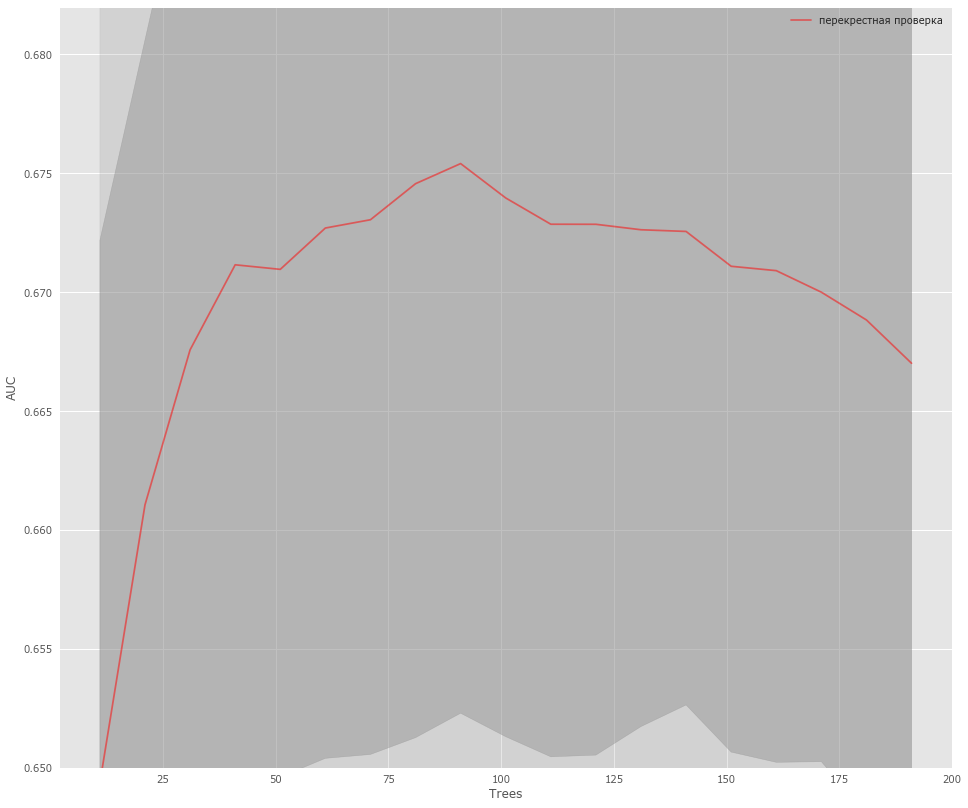

In [580]:
test_auc = []
temp_test_auc = []
# trees_list = list(range(50, 351, 50))
trees_list = list(range(11, 201, 10))

for trees in trees_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=trees, objective='train', n_jobs=-1, random_state=42) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(trees, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(trees_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(trees_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Trees")

In [ ]:
micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42, learning_rate=) 

Trained on value: 0.02, AUC: 0.665
Trained on value: 0.03, AUC: 0.673
Trained on value: 0.04, AUC: 0.675
Trained on value: 0.05, AUC: 0.675
Trained on value: 0.055, AUC: 0.675
Trained on value: 0.06, AUC: 0.676
Trained on value: 0.065, AUC: 0.674
Trained on value: 0.07, AUC: 0.668
Trained on value: 0.08, AUC: 0.674
Trained on value: 0.01, AUC: 0.651


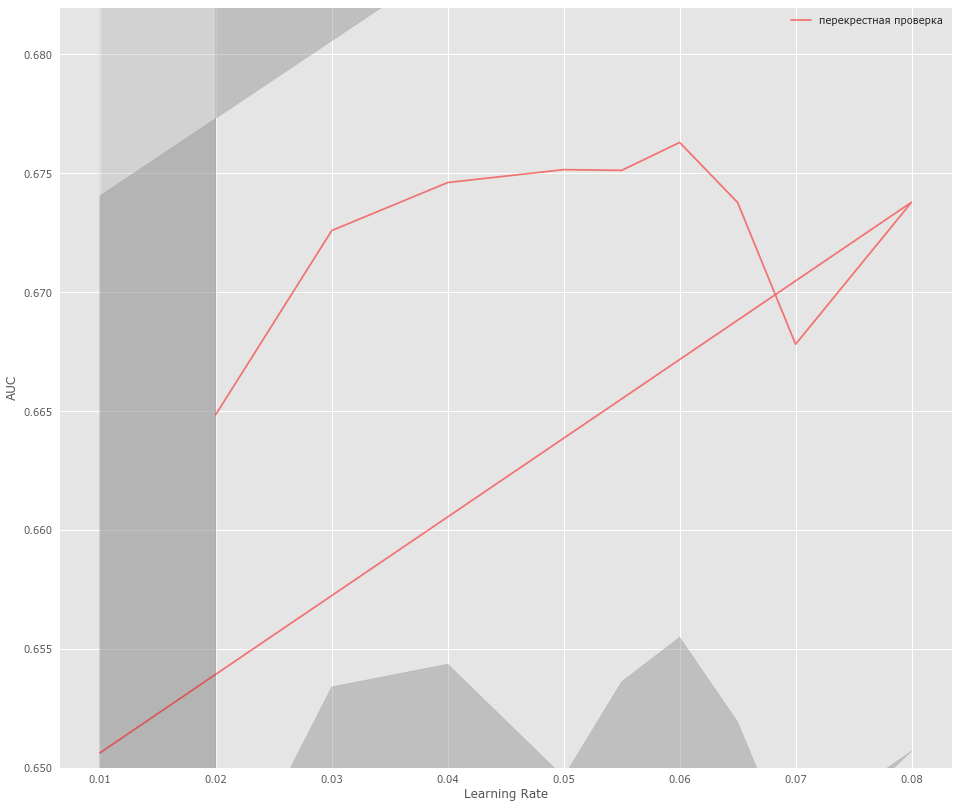

In [585]:
test_auc = []
temp_test_auc = []

# learning_rate_list = [0.04, 0.06, 0.08, 0.010, 0.012, 0.014, 0.016, 0.018, 0.02]
learning_rate_list = [0.02, 0.03, 0.04, 0.05, 0.055, 0.06, 0.065, 0.07, 0.08, 0.010]

for learning_rate in learning_rate_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42,
                                         learning_rate=learning_rate) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(learning_rate, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(learning_rate_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(learning_rate_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(learning_rate_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Learning Rate")

Trained on value: 5, AUC: 0.672
Trained on value: 7, AUC: 0.675
Trained on value: 9, AUC: 0.676
Trained on value: 11, AUC: 0.675
Trained on value: 15, AUC: 0.677
Trained on value: 17, AUC: 0.677
Trained on value: 19, AUC: 0.676
Trained on value: 21, AUC: 0.677
Trained on value: 23, AUC: 0.675
Trained on value: 25, AUC: 0.674


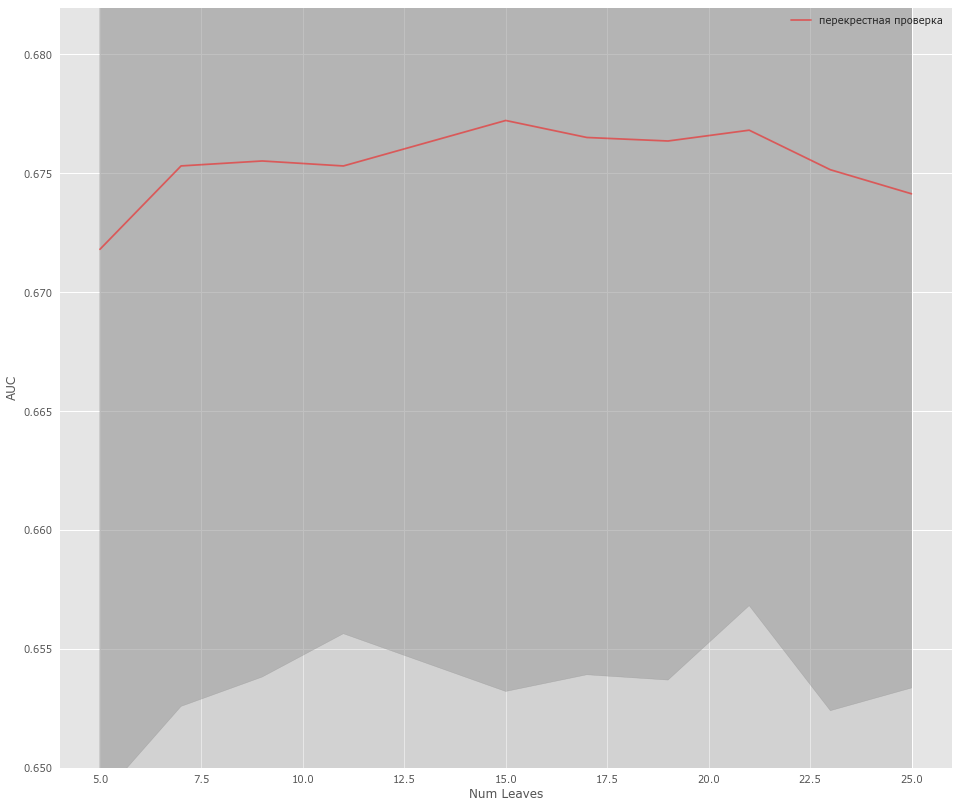

In [587]:
test_auc = []
temp_test_auc = []

num_leaves_list = [5, 7, 9, 11, 15, 17, 19, 21, 23, 25]

for num_leaves in num_leaves_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42,
                                         learning_rate=0.06, num_leaves=num_leaves) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(num_leaves, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(num_leaves_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(num_leaves_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(num_leaves_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Num Leaves")

Trained on value: 1, AUC: 0.649
Trained on value: 2, AUC: 0.665
Trained on value: 3, AUC: 0.669
Trained on value: 4, AUC: 0.668
Trained on value: 5, AUC: 0.673
Trained on value: 6, AUC: 0.672
Trained on value: 7, AUC: 0.670
Trained on value: 9, AUC: 0.675
Trained on value: 11, AUC: 0.672


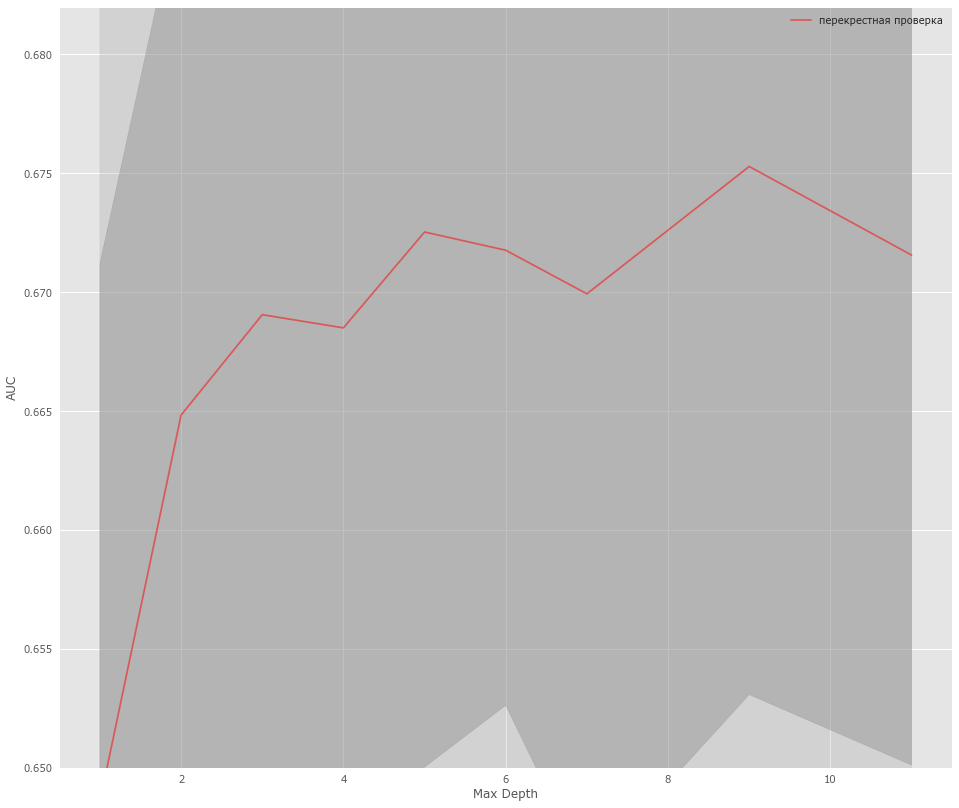

In [591]:
test_auc = []
temp_test_auc = []

max_depth_list = [1, 2, 3, 4, 5, 6, 7, 9, 11]

for max_depth in max_depth_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42,
                                         learning_rate=0.06, max_depth=max_depth) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(max_depth, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(max_depth_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(max_depth_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Max Depth")

Trained on value: 5, AUC: 0.672
Trained on value: 7, AUC: 0.675
Trained on value: 9, AUC: 0.676
Trained on value: 11, AUC: 0.676
Trained on value: 15, AUC: 0.675
Trained on value: 17, AUC: 0.677
Trained on value: 19, AUC: 0.676
Trained on value: 21, AUC: 0.673
Trained on value: 23, AUC: 0.675
Trained on value: 25, AUC: 0.675


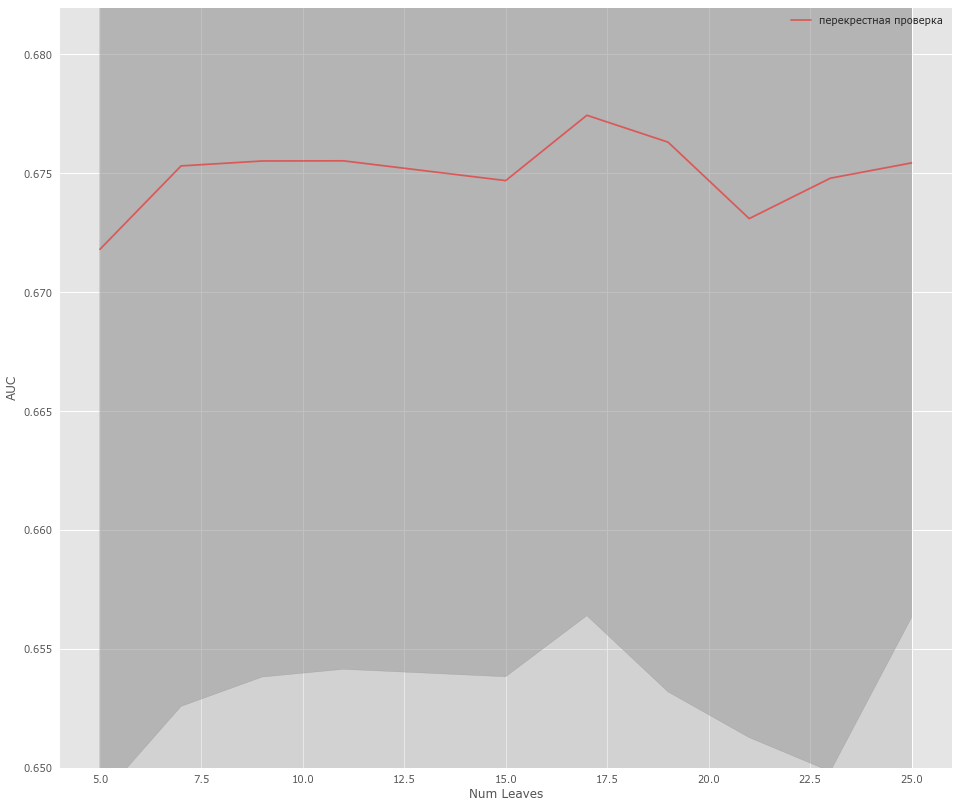

In [592]:
test_auc = []
temp_test_auc = []

num_leaves_list = [5, 7, 9, 11, 15, 17, 19, 21, 23, 25]

for num_leaves in num_leaves_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42,
                                         learning_rate=0.06, max_depth=9, num_leaves=num_leaves) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(num_leaves, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(num_leaves_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(num_leaves_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(num_leaves_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Num Leaves")

## XGBoost

In [594]:
import xgboost as xgb
import hyperopt

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [601]:
Xtrain_xgb, Xtest_xgb, ytrain_xgb, ytest_xgb = train_test_split(train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                                train_dummy.loc[:, 'TARGET_1'], test_size=0.3)

In [602]:
def score(params):
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(Xtrain_xgb, label=ytrain_xgb)
    dvalid = xgb.DMatrix(Xtest_xgb, label=ytest_xgb)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 9))
    score = log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}


def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'num_class' : 9,
             'eval_metric': 'mlogloss',
             'objective': 'multi:softprob',
             'nthread' : -1,
             'silent' : 1
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)

    print(best)

trials = Trials()

optimize(trials)

XGBoostError: b"Invalid Parameter format for max_depth expect int but value='11.0'"